In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive/

# 他社債務(24か月)

## 参考
https://www.kaggle.com/code/willkoehrsen/introduction-to-manual-feature-engineering

## モジュールとCSVの読み込み

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 869092211022264747
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1745276110
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5524514672692971941
 physical_device_desc: "device: 0, name: NVIDIA RTX A2000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [4]:
import torch
# GPUの名称、CUDA Compute Capabilityを取得
print(torch.cuda.get_device_name())

NVIDIA RTX A2000 Laptop GPU


In [5]:
import pandas as pd
#import pandas_profiling
import numpy as np
import cupy as cp
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import roc_auc_score
from sklearn.tree import plot_tree

from six import StringIO

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import math
from scipy import stats
import numpy as np
import optuna.integration.lightgbm as lgb
import pandas as pd
import tensorflow as tf

from datetime import datetime
from tensorflow import feature_column
from tensorflow.keras import layers

print("OK\n")

OK



In [6]:
app_train_origin = pd.read_csv('./home-credit-default-risk/exports/app_train.csv')
app_test_origin =  pd.read_csv('./home-credit-default-risk/exports/app_test.csv')
bureau_origin = pd.read_csv('./home-credit-default-risk/bureau.csv')
bureau_balance_origin = pd.read_csv('./home-credit-default-risk/bureau_balance.csv')
app_br_train_origin = pd.read_csv('./home-credit-default-risk/exports/app_train_br_all-domein_24-monthes.csv')
app_br_test_origin = pd.read_csv('./home-credit-default-risk/exports/app_test_br_all-domein_24-monthes.csv')
#POS_CASH_balance_origin = pd.read_csv('./home-credit-default-risk/POS_CASH_balance.csv')
#credit_card_balance_origin = pd.read_csv('./home-credit-default-risk/credit_card_balance.csv')
#previous_application_origin = pd.read_csv('./home-credit-default-risk/previous_application.csv')
#installments_payments_origin = pd.read_csv('./home-credit-default-risk/installments_payments.csv')
# custo data
#app_br_train_origin = pd.read_csv('./home-credit-default-risk/datasets/app_train_Loan_From_other_banks_cash-consumer-loans.csv')
#app_br_test_origin = pd.read_csv('./home-credit-default-risk/datasets/app_test_Loan_From_other_banks_cash-consumer-loans.csv')
#app_train_br_overdue_hist_origin = pd.read_csv('./home-credit-default-risk/datasets/app_train_br_overdue_hist.csv')
#app_test_br_overdue_hist_origin = pd.read_csv('./home-credit-default-risk/datasets/app_test_br_overdue_hist.csv')
#app_train_br_debt_credit_ratio_none_origin = pd.read_csv('./home-credit-default-risk/datasets/app_train_br_debt_credit_ratio_none.csv')
#app_test_br_debt_credit_ratio_none_origin = pd.read_csv('./home-credit-default-risk/datasets/app_test_br_debt_credit_ratio_none.csv')

app_train_origin.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0            1             0   
1      100003       0                   0            0             0   
2      100004       0                   1            1             1   
3      100006       0                   0            0             0   
4      100007       0                   0            1             0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ...  FLAG_DOCUMENT_16  AMT_REQ_CREDIT_BUREAU_MON  \
0  ...                 0                        0.0   
1  ...                 0                        0.0   
2  ...                 0                        0.0   
3  ...                 0                        NaN   
4  ...                 0                        0.0   

   AMT_REQ_CREDIT_BUREAU_YEAR  CREDIT_TERM  DAYS_EMPLOYED_PERCENT  \
0                         1.0     0.060749              -0.067329   
1                         0.0     0.027598              -0.070862   
2                         0.0     0.050000              -0.011814   
3                         NaN     0.094941              -0.159905   
4                         0.0     0.042623              -0.152418   

   credit_annuity_ratio  DAYS_EMPLOYED_ANOM  credit_goods_price_ratio  \
0             16.461104               False                  1.158397   
1             36.234085               False                  1.145199   
2             20.000000               False                  1.000000   
3             10.532818               False                  1.052803   
4             23.461618               False                  1.000000   

   credit_downpayment    AGE_INT  
0            -55597.5 -25.920548  
1           -164002.5 -45.931507  
2                 0.0 -52.180822  
3            -15682.5 -52.068493  
4                 0.0 -54.608219  

[5 rows x 93 columns]

In [7]:
app_train = app_train_origin.copy()
app_test = app_test_origin.copy()
bureau = bureau_origin.copy()
bureau_balance = bureau_balance_origin.copy()
app_br_train = app_br_train_origin.copy()
app_br_test = app_br_test_origin.copy()

In [8]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

## 他金融機関での借り入れ情報(bureau)前処理

In [9]:
len(app_train)

307511

In [10]:
len(app_test)

48744

In [11]:
len(app_br_train)

90978

In [12]:
len(app_br_test)

42311

In [13]:
#app_train = app_train[['SK_ID_CURR','TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].copy()
#app_test = app_test[['SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].copy()
app_train = app_train[['SK_ID_CURR','TARGET']].copy()
app_test = app_test[['SK_ID_CURR']].copy()
len(app_test)

48744

In [14]:
app_br_train = app_br_train.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
app_br_test = app_br_test.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
len(app_br_test)

42311

In [15]:
# trainへマージ
app_train = pd.merge(app_train, app_br_train, on='SK_ID_CURR', how='left')
# testへマージ
app_test = pd.merge(app_test, app_br_test, on='SK_ID_CURR', how='left')
len(app_test)

48744

### br_min_credit_day_overdue

In [16]:
app_train[['TARGET', 'br_min_credit_day_overdue']].corr()

TARGET  br_min_credit_day_overdue
TARGET                     1.00000                    0.01126
br_min_credit_day_overdue  0.01126                    1.00000

The correlation between br_min_credit_day_overdue and the TARGET is 0.0113
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


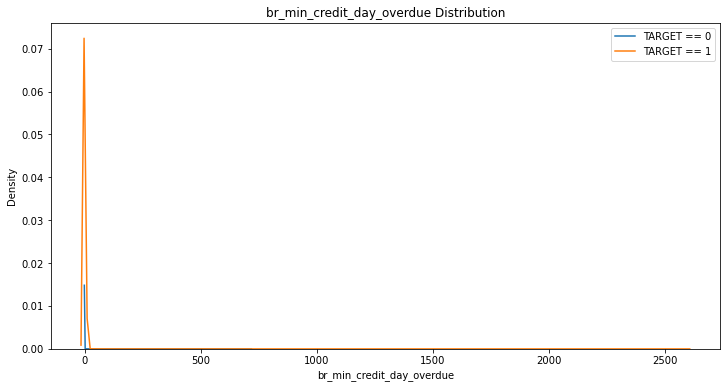

In [17]:
kde_target('br_min_credit_day_overdue', app_train)

In [18]:
## Yao-Johnson変換
#num_cols = ['br_min_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_min_credit_day_overdue'] = pt.transform(app_train[num_cols])
#app_test['br_min_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [19]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_min_credit_day_overdue']].corr()

### br_max_credit_day_overdue

In [20]:
app_train[['TARGET', 'br_max_credit_day_overdue']].corr()

TARGET  br_max_credit_day_overdue
TARGET                     1.000000                  -0.000026
br_max_credit_day_overdue -0.000026                   1.000000

The correlation between br_max_credit_day_overdue and the TARGET is -0.0000
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


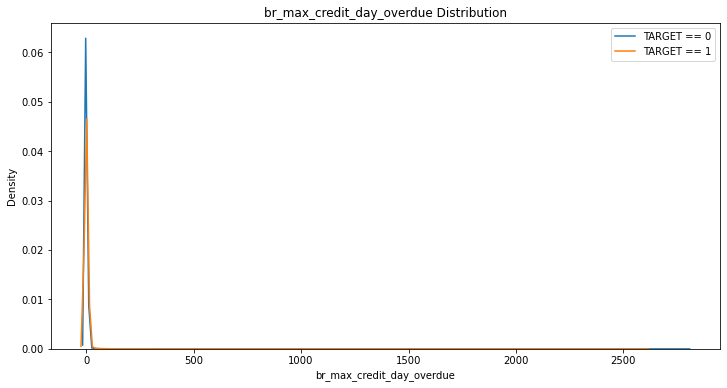

In [21]:
kde_target('br_max_credit_day_overdue', app_train)

In [22]:
## Yao-Johnson変換
num_cols = ['br_max_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_max_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [23]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_credit_day_overdue']].corr()

TARGET  br_max_credit_day_overdue
TARGET                     1.000000                   0.032782
br_max_credit_day_overdue  0.032782                   1.000000

The correlation between br_max_credit_day_overdue and the TARGET is 0.0328
Median value for loan that was not repaid = -0.1094
Median value for loan that was repaid =     -0.1094


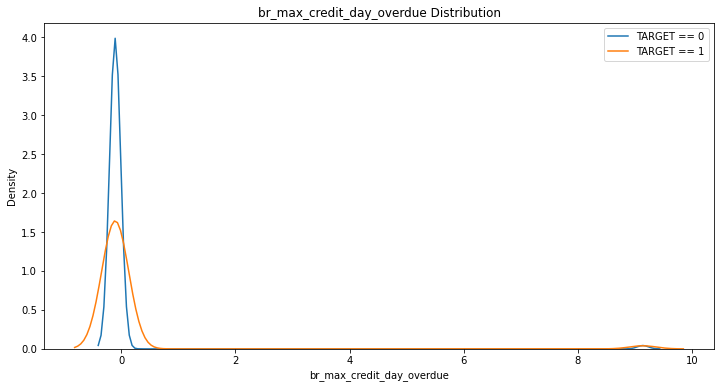

In [24]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_credit_day_overdue', app_train)

### br_sum_credit_day_overdue

In [25]:
app_train[['TARGET', 'br_sum_credit_day_overdue']].corr()

TARGET  br_sum_credit_day_overdue
TARGET                     1.000000                  -0.001824
br_sum_credit_day_overdue -0.001824                   1.000000

The correlation between br_sum_credit_day_overdue and the TARGET is -0.0018
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


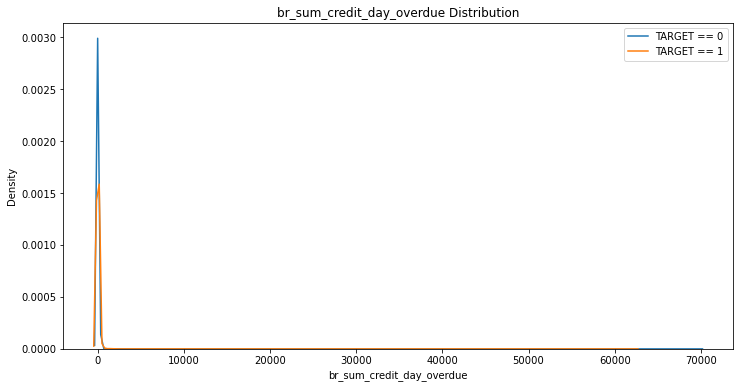

In [26]:
kde_target('br_sum_credit_day_overdue', app_train)

In [27]:
## Yao-Johnson変換
num_cols = ['br_sum_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_sum_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [28]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_credit_day_overdue']].corr()

TARGET  br_sum_credit_day_overdue
TARGET                     1.000000                   0.032782
br_sum_credit_day_overdue  0.032782                   1.000000

The correlation between br_sum_credit_day_overdue and the TARGET is 0.0328
Median value for loan that was not repaid = -0.1094
Median value for loan that was repaid =     -0.1094


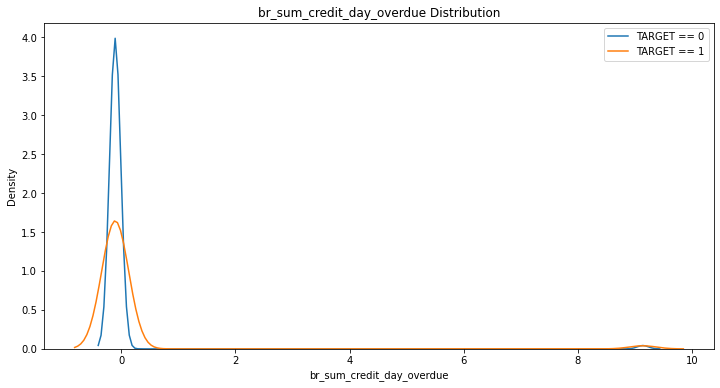

In [29]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_credit_day_overdue', app_train)

### br_avg_credit_day_overdue

In [30]:
app_train[['TARGET', 'br_avg_credit_day_overdue']].corr()

TARGET  br_avg_credit_day_overdue
TARGET                     1.000000                   0.003846
br_avg_credit_day_overdue  0.003846                   1.000000

The correlation between br_avg_credit_day_overdue and the TARGET is 0.0038
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


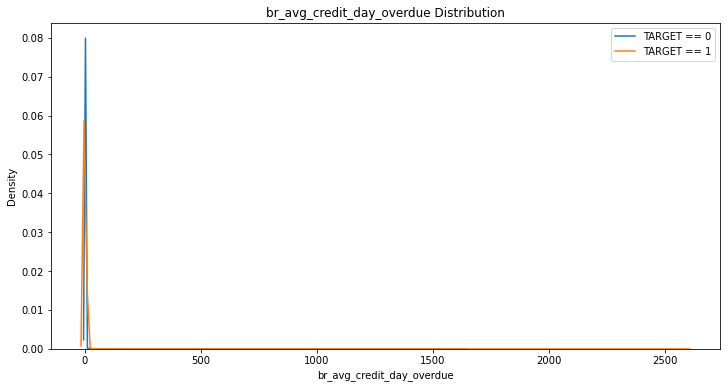

In [31]:
kde_target('br_avg_credit_day_overdue', app_train)

In [32]:
## Yao-Johnson変換
num_cols = ['br_avg_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_avg_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [33]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_credit_day_overdue']].corr()

TARGET  br_avg_credit_day_overdue
TARGET                     1.00000                    0.03282
br_avg_credit_day_overdue  0.03282                    1.00000

The correlation between br_avg_credit_day_overdue and the TARGET is 0.0328
Median value for loan that was not repaid = -0.1094
Median value for loan that was repaid =     -0.1094


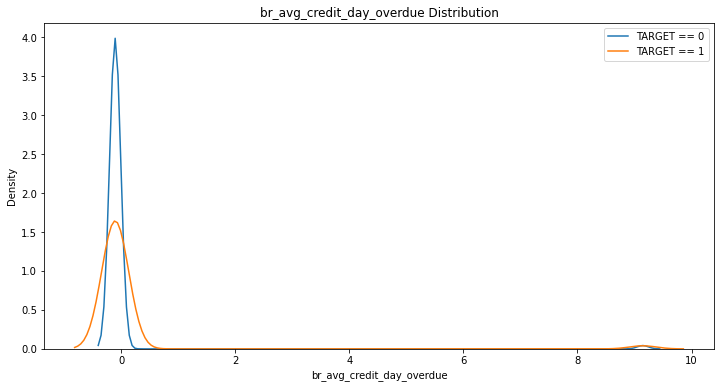

In [34]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_credit_day_overdue', app_train)

### br_cnt_credit_day_overdue

In [35]:
app_train[['TARGET', 'br_cnt_credit_day_overdue']].corr()

TARGET  br_cnt_credit_day_overdue
TARGET                     1.000000                  -0.024241
br_cnt_credit_day_overdue -0.024241                   1.000000

The correlation between br_cnt_credit_day_overdue and the TARGET is -0.0242
Median value for loan that was not repaid = 55.0000
Median value for loan that was repaid =     63.0000


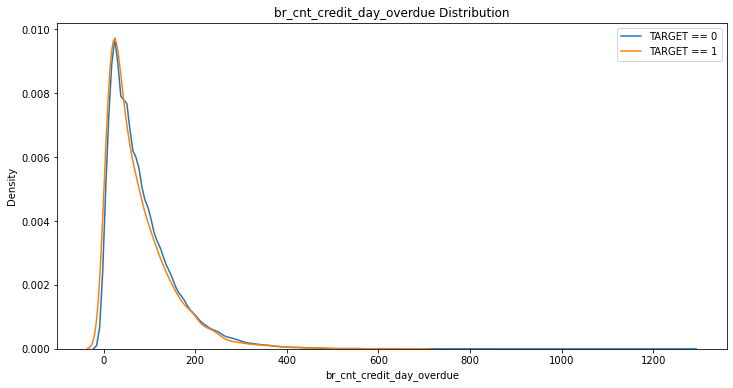

In [36]:
kde_target('br_cnt_credit_day_overdue', app_train)

In [37]:
## Yao-Johnson変換
num_cols = ['br_cnt_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_cnt_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [38]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_credit_day_overdue']].corr()

TARGET  br_cnt_credit_day_overdue
TARGET                     1.000000                  -0.035764
br_cnt_credit_day_overdue -0.035764                   1.000000

The correlation between br_cnt_credit_day_overdue and the TARGET is -0.0358
Median value for loan that was not repaid = -0.1168
Median value for loan that was repaid =     0.0267


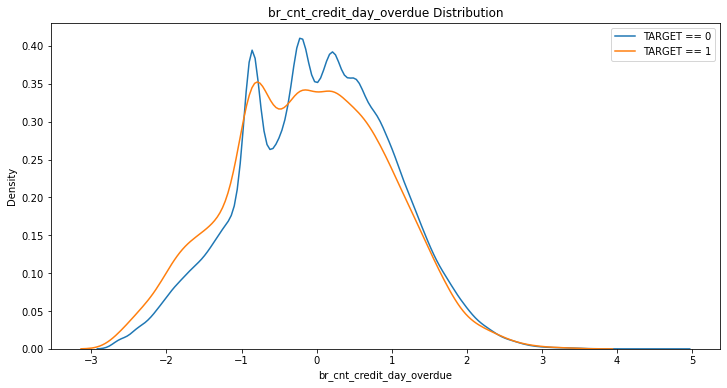

In [39]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_credit_day_overdue', app_train)

### br_stddev_credit_day_overdue

In [40]:
app_train[['TARGET', 'br_stddev_credit_day_overdue']].corr()

TARGET  br_stddev_credit_day_overdue
TARGET                        1.000000                     -0.001964
br_stddev_credit_day_overdue -0.001964                      1.000000

The correlation between br_stddev_credit_day_overdue and the TARGET is -0.0020
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


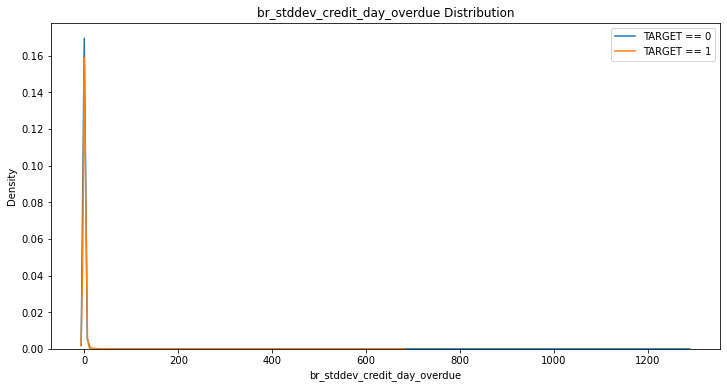

In [41]:
kde_target('br_stddev_credit_day_overdue', app_train)

In [42]:
## Yao-Johnson変換
num_cols = ['br_stddev_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [43]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_credit_day_overdue']].corr()

TARGET  br_stddev_credit_day_overdue
TARGET                        1.000000                      0.031541
br_stddev_credit_day_overdue  0.031541                      1.000000

The correlation between br_stddev_credit_day_overdue and the TARGET is 0.0315
Median value for loan that was not repaid = -0.1065
Median value for loan that was repaid =     -0.1065


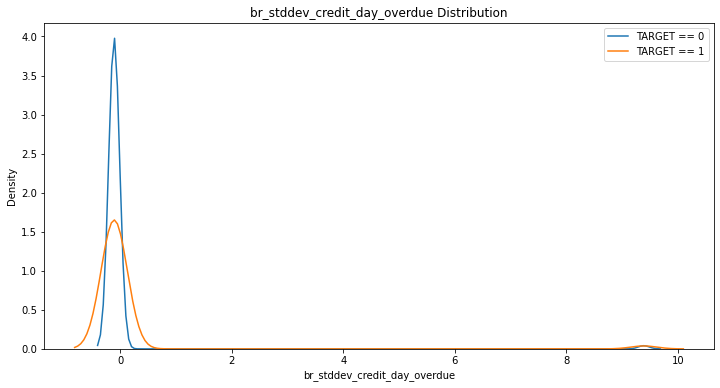

In [44]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_credit_day_overdue', app_train)

### br_stddev_pop_credit_day_overdue

In [45]:
app_train[['TARGET', 'br_stddev_pop_credit_day_overdue']].corr()

TARGET  br_stddev_pop_credit_day_overdue
TARGET                            1.000000                         -0.001964
br_stddev_pop_credit_day_overdue -0.001964                          1.000000

The correlation between br_stddev_pop_credit_day_overdue and the TARGET is -0.0020
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


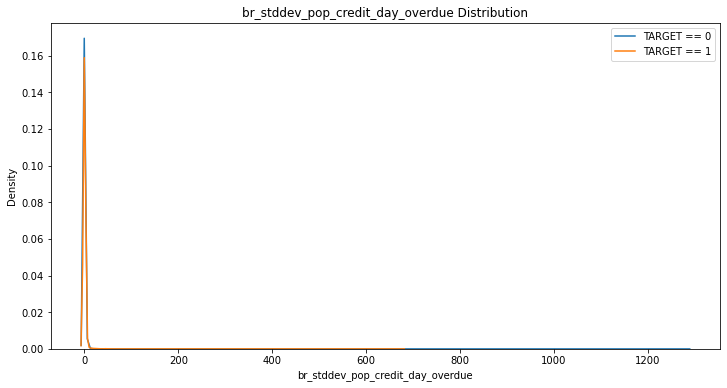

In [46]:
kde_target('br_stddev_pop_credit_day_overdue', app_train)

In [47]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [48]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_credit_day_overdue']].corr()

TARGET  br_stddev_pop_credit_day_overdue
TARGET                            1.000000                          0.031541
br_stddev_pop_credit_day_overdue  0.031541                          1.000000

The correlation between br_stddev_pop_credit_day_overdue and the TARGET is 0.0315
Median value for loan that was not repaid = -0.1065
Median value for loan that was repaid =     -0.1065


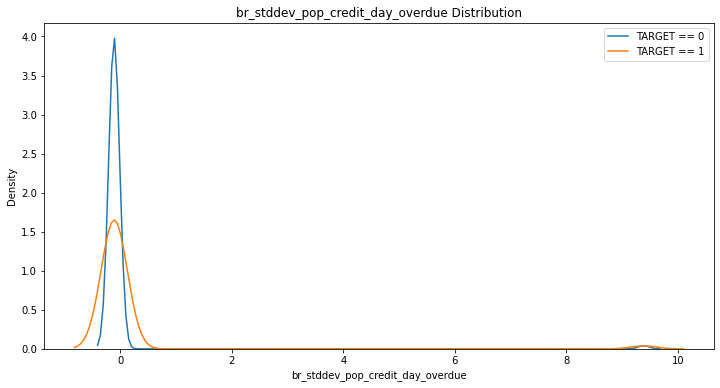

In [49]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_credit_day_overdue', app_train)

### br_var_pop_credit_day_overdue

In [50]:
app_train[['TARGET', 'br_var_pop_credit_day_overdue']].corr()

TARGET  br_var_pop_credit_day_overdue
TARGET                         1.000000                      -0.004095
br_var_pop_credit_day_overdue -0.004095                       1.000000

The correlation between br_var_pop_credit_day_overdue and the TARGET is -0.0041
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


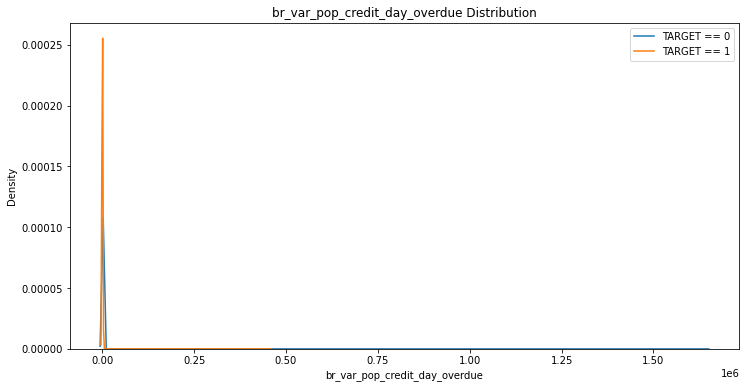

In [51]:
kde_target('br_var_pop_credit_day_overdue', app_train)

In [52]:
## Yao-Johnson変換
num_cols = ['br_var_pop_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [53]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_credit_day_overdue']].corr()

TARGET  br_var_pop_credit_day_overdue
TARGET                         1.000000                       0.031571
br_var_pop_credit_day_overdue  0.031571                       1.000000

The correlation between br_var_pop_credit_day_overdue and the TARGET is 0.0316
Median value for loan that was not repaid = -0.1065
Median value for loan that was repaid =     -0.1065


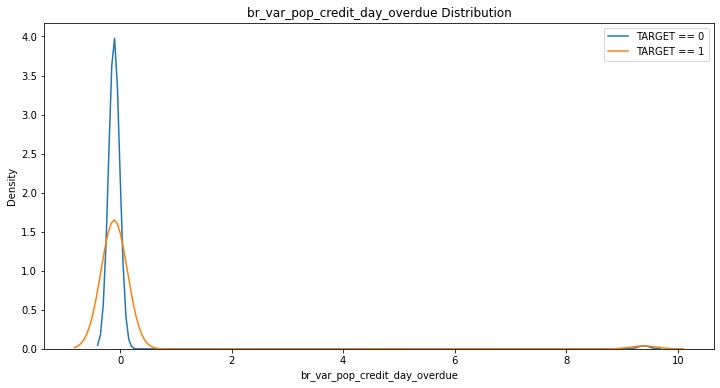

In [54]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_credit_day_overdue', app_train)

### br_var_samp_credit_day_overdue

In [55]:
app_train[['TARGET', 'br_var_samp_credit_day_overdue']].corr()

TARGET  br_var_samp_credit_day_overdue
TARGET                          1.000000                       -0.003936
br_var_samp_credit_day_overdue -0.003936                        1.000000

The correlation between br_var_samp_credit_day_overdue and the TARGET is -0.0039
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


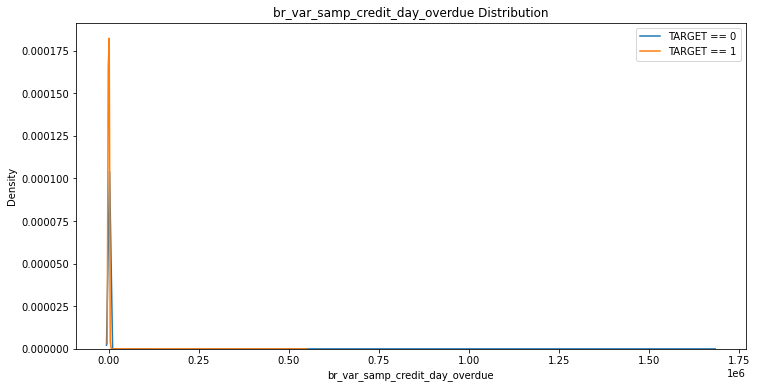

In [56]:
kde_target('br_var_samp_credit_day_overdue', app_train)

In [57]:
## Yao-Johnson変換
num_cols = ['br_var_samp_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [58]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_credit_day_overdue']].corr()

TARGET  br_var_samp_credit_day_overdue
TARGET                          1.000000                        0.031571
br_var_samp_credit_day_overdue  0.031571                        1.000000

The correlation between br_var_samp_credit_day_overdue and the TARGET is 0.0316
Median value for loan that was not repaid = -0.1065
Median value for loan that was repaid =     -0.1065


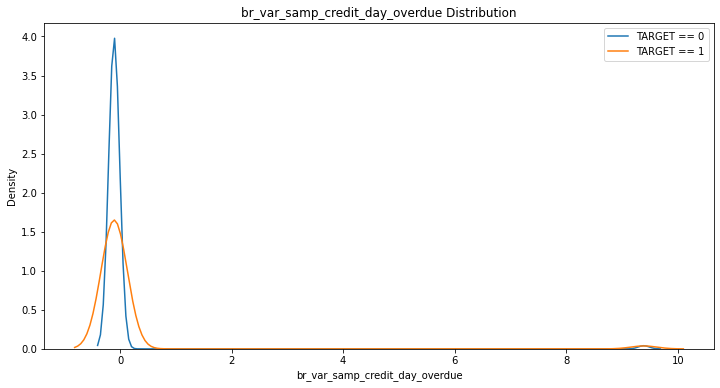

In [59]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_credit_day_overdue', app_train)

### br_variance_pop_credit_day_overdue

In [60]:
app_train[['TARGET', 'br_variance_pop_credit_day_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_credit_day_overdue -0.004095   

                                    br_variance_pop_credit_day_overdue  
TARGET                                                       -0.004095  
br_variance_pop_credit_day_overdue                            1.000000

The correlation between br_variance_pop_credit_day_overdue and the TARGET is -0.0041
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


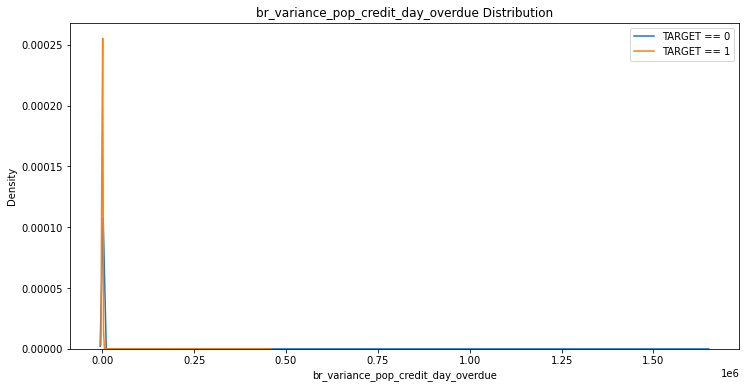

In [61]:
kde_target('br_variance_pop_credit_day_overdue', app_train)

In [62]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_credit_day_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_credit_day_overdue'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_credit_day_overdue'] = pt.transform(app_test[num_cols])

In [63]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_credit_day_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_credit_day_overdue  0.031571   

                                    br_variance_pop_credit_day_overdue  
TARGET                                                        0.031571  
br_variance_pop_credit_day_overdue                            1.000000

The correlation between br_variance_pop_credit_day_overdue and the TARGET is 0.0316
Median value for loan that was not repaid = -0.1065
Median value for loan that was repaid =     -0.1065


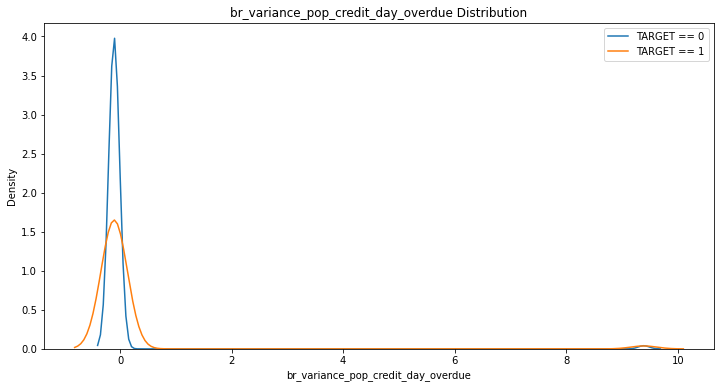

In [64]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_credit_day_overdue', app_train)

### br_min_days_credit_enddate

In [65]:
app_train[['TARGET', 'br_min_days_credit_enddate']].corr()

TARGET  br_min_days_credit_enddate
TARGET                      1.000000                    0.033942
br_min_days_credit_enddate  0.033942                    1.000000

The correlation between br_min_days_credit_enddate and the TARGET is 0.0339
Median value for loan that was not repaid = -604.5000
Median value for loan that was repaid =     -845.0000


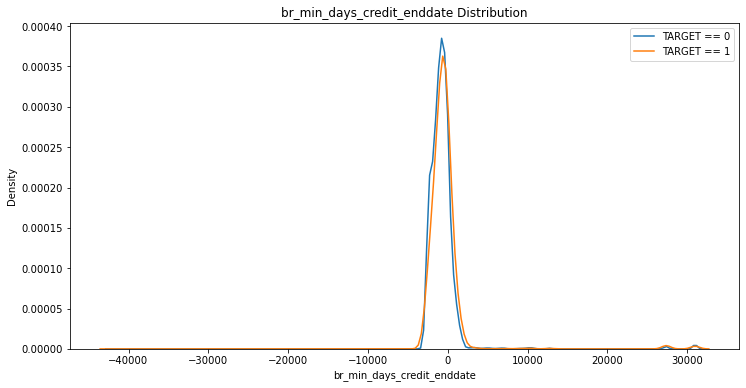

In [66]:
kde_target('br_min_days_credit_enddate', app_train)

In [67]:
## Yao-Johnson変換
num_cols = ['br_min_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_min_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [68]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_days_credit_enddate']].corr()

TARGET  br_min_days_credit_enddate
TARGET                      1.000000                    0.054742
br_min_days_credit_enddate  0.054742                    1.000000

The correlation between br_min_days_credit_enddate and the TARGET is 0.0547
Median value for loan that was not repaid = 0.3437
Median value for loan that was repaid =     0.1049


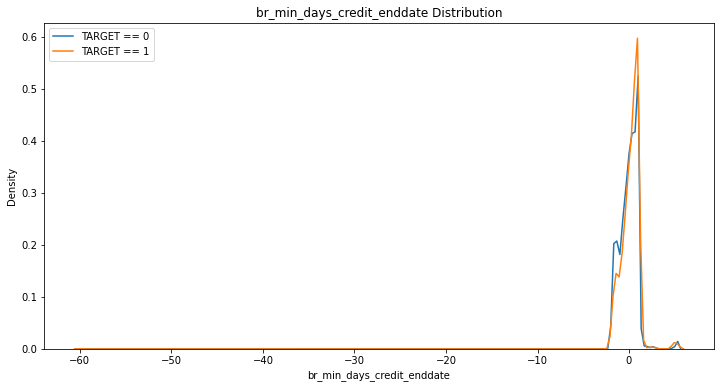

In [69]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_days_credit_enddate', app_train)

### br_max_days_credit_enddate

In [70]:
app_train[['TARGET', 'br_max_days_credit_enddate']].corr()

TARGET  br_max_days_credit_enddate
TARGET                      1.000000                    0.037627
br_max_days_credit_enddate  0.037627                    1.000000

The correlation between br_max_days_credit_enddate and the TARGET is 0.0376
Median value for loan that was not repaid = 1106.5000
Median value for loan that was repaid =     913.0000


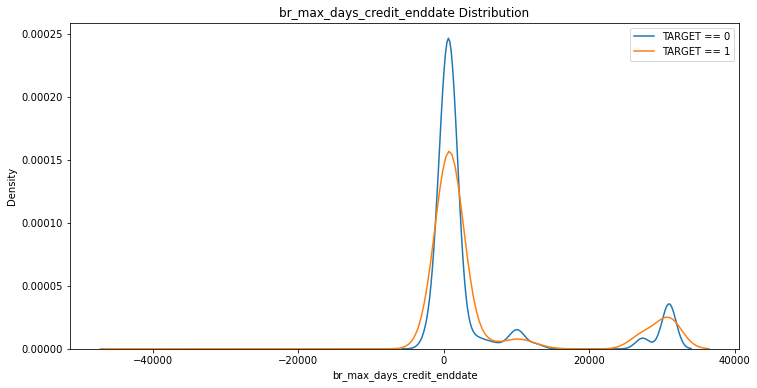

In [71]:
kde_target('br_max_days_credit_enddate', app_train)

In [72]:
## Yao-Johnson変換
#num_cols = ['br_max_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_max_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_max_days_credit_enddate'] = pt.transform(app_test[num_cols])


In [73]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_max_days_credit_enddate']].corr()

In [74]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_max_days_credit_enddate', app_train)

### br_sum_days_credit_enddate

In [75]:
app_train[['TARGET', 'br_sum_days_credit_enddate']].corr()

TARGET  br_sum_days_credit_enddate
TARGET                      1.000000                    0.033882
br_sum_days_credit_enddate  0.033882                    1.000000

The correlation between br_sum_days_credit_enddate and the TARGET is 0.0339
Median value for loan that was not repaid = 3173.0000
Median value for loan that was repaid =     -1074.0000


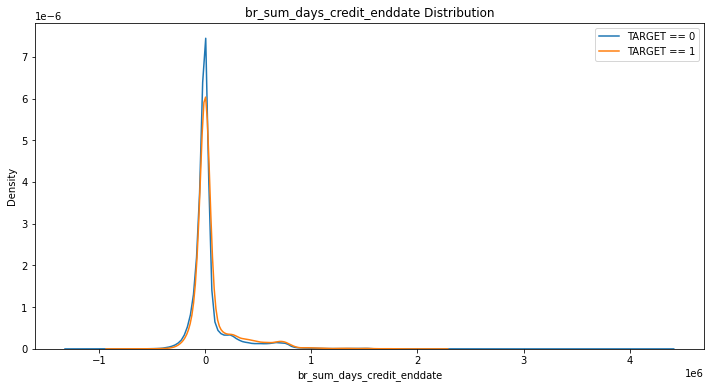

In [76]:
kde_target('br_sum_days_credit_enddate', app_train)

In [77]:
## Yao-Johnson変換
num_cols = ['br_sum_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_sum_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [78]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_days_credit_enddate']].corr()

TARGET  br_sum_days_credit_enddate
TARGET                      1.000000                    0.047382
br_sum_days_credit_enddate  0.047382                    1.000000

The correlation between br_sum_days_credit_enddate and the TARGET is 0.0474
Median value for loan that was not repaid = 0.1169
Median value for loan that was repaid =     0.0935


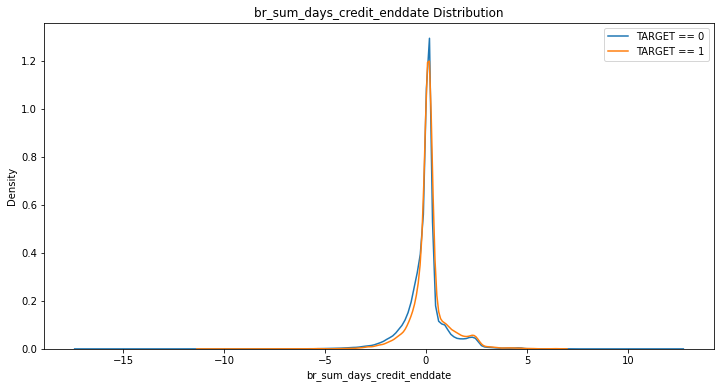

In [79]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_days_credit_enddate', app_train)

### br_avg_days_credit_enddate

In [80]:
app_train[['TARGET', 'br_avg_days_credit_enddate']].corr()

TARGET  br_avg_days_credit_enddate
TARGET                      1.000000                    0.043224
br_avg_days_credit_enddate  0.043224                    1.000000

The correlation between br_avg_days_credit_enddate and the TARGET is 0.0432
Median value for loan that was not repaid = 156.3093
Median value for loan that was repaid =     -38.7708


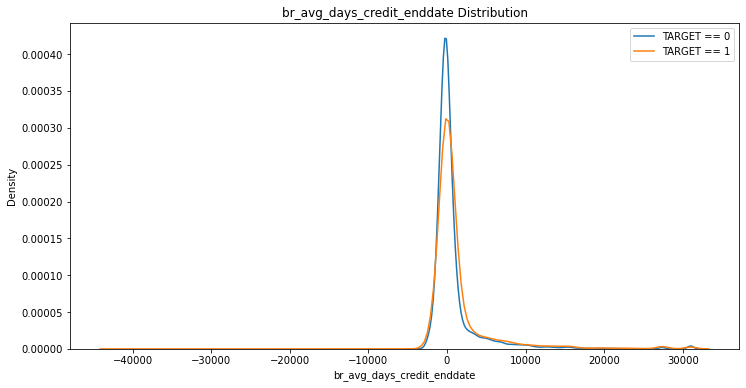

In [81]:
kde_target('br_avg_days_credit_enddate', app_train)

In [82]:
## Yao-Johnson変換
num_cols = ['br_avg_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_avg_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [83]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_days_credit_enddate']].corr()

TARGET  br_avg_days_credit_enddate
TARGET                      1.000000                    0.052647
br_avg_days_credit_enddate  0.052647                    1.000000

The correlation between br_avg_days_credit_enddate and the TARGET is 0.0526
Median value for loan that was not repaid = 0.2060
Median value for loan that was repaid =     0.1263


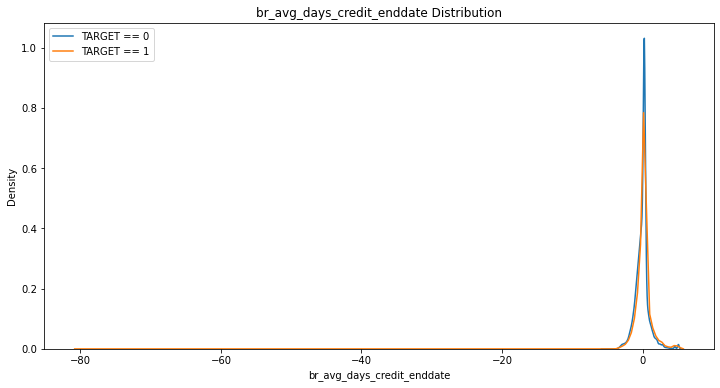

In [84]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_days_credit_enddate', app_train)

### br_cnt_days_credit_enddate

In [85]:
app_train[['TARGET', 'br_cnt_days_credit_enddate']].corr()

TARGET  br_cnt_days_credit_enddate
TARGET                      1.000000                   -0.029017
br_cnt_days_credit_enddate -0.029017                    1.000000

The correlation between br_cnt_days_credit_enddate and the TARGET is -0.0290
Median value for loan that was not repaid = 50.0000
Median value for loan that was repaid =     58.0000


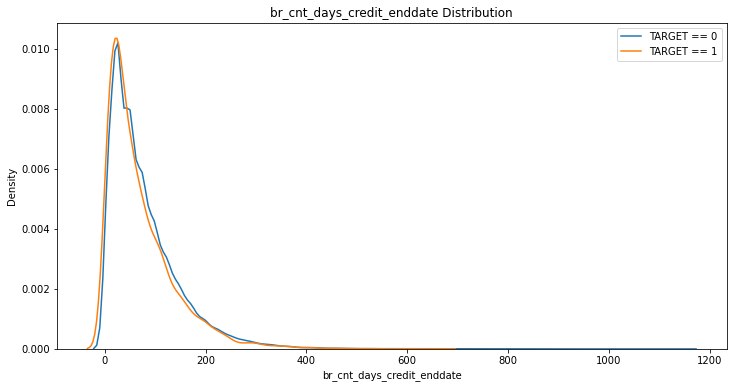

In [86]:
kde_target('br_cnt_days_credit_enddate', app_train)

In [87]:
## Yao-Johnson変換
num_cols = ['br_cnt_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_cnt_days_credit_enddate'] = pt.transform(app_test[num_cols])


In [88]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_days_credit_enddate']].corr()

TARGET  br_cnt_days_credit_enddate
TARGET                      1.000000                   -0.040432
br_cnt_days_credit_enddate -0.040432                    1.000000

The correlation between br_cnt_days_credit_enddate and the TARGET is -0.0404
Median value for loan that was not repaid = -0.1463
Median value for loan that was repaid =     0.0044


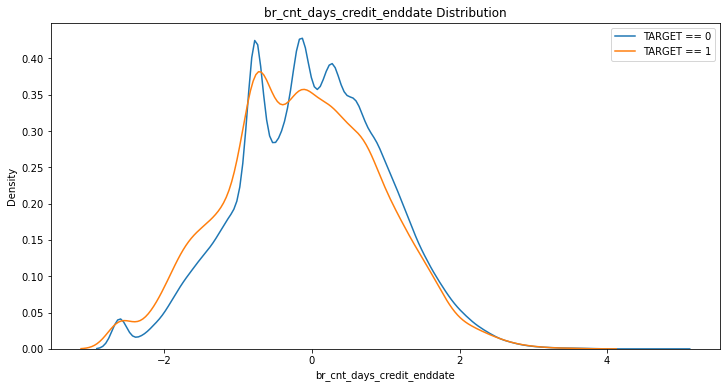

In [89]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_days_credit_enddate', app_train)

### br_stddev_days_credit_enddate

In [90]:
app_train[['TARGET', 'br_stddev_days_credit_enddate']].corr()

TARGET  br_stddev_days_credit_enddate
TARGET                         1.000000                       0.027366
br_stddev_days_credit_enddate  0.027366                       1.000000

The correlation between br_stddev_days_credit_enddate and the TARGET is 0.0274
Median value for loan that was not repaid = 620.3881
Median value for loan that was repaid =     618.9062


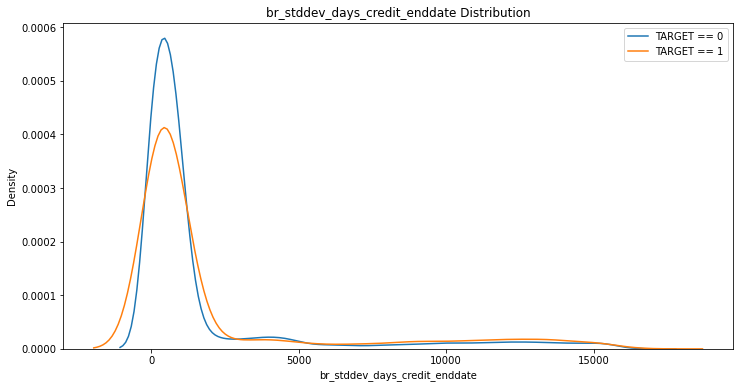

In [91]:
kde_target('br_stddev_days_credit_enddate', app_train)

In [92]:
## Yao-Johnson変換
#num_cols = ['br_stddev_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [93]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_days_credit_enddate']].corr()

In [94]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_days_credit_enddate', app_train)

### br_stddev_pop_days_credit_enddate

In [95]:
app_train[['TARGET', 'br_stddev_pop_days_credit_enddate']].corr()

TARGET  br_stddev_pop_days_credit_enddate
TARGET                             1.000000                           0.027366
br_stddev_pop_days_credit_enddate  0.027366                           1.000000

The correlation between br_stddev_pop_days_credit_enddate and the TARGET is 0.0274
Median value for loan that was not repaid = 620.3881
Median value for loan that was repaid =     618.9062


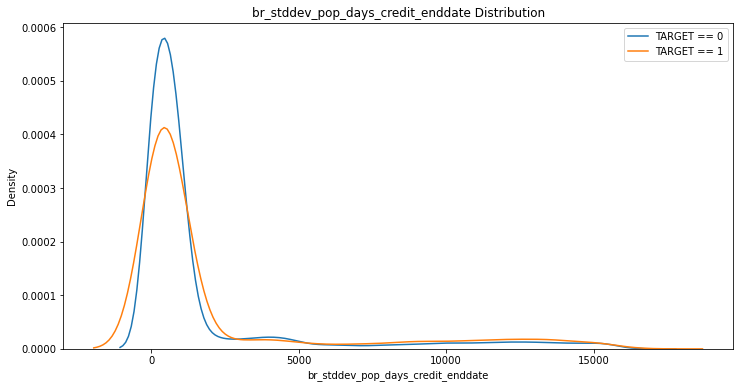

In [96]:
kde_target('br_stddev_pop_days_credit_enddate', app_train)

In [97]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [98]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_days_credit_enddate']].corr()

In [99]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_pop_days_credit_enddate', app_train)

### br_var_pop_days_credit_enddate

In [100]:
app_train[['TARGET', 'br_var_pop_days_credit_enddate']].corr()

TARGET  br_var_pop_days_credit_enddate
TARGET                          1.000000                        0.028361
br_var_pop_days_credit_enddate  0.028361                        1.000000

The correlation between br_var_pop_days_credit_enddate and the TARGET is 0.0284
Median value for loan that was not repaid = 384881.3932
Median value for loan that was repaid =     383044.8725


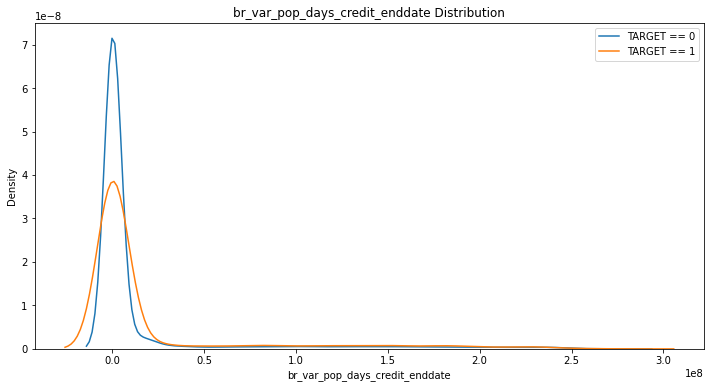

In [101]:
kde_target('br_var_pop_days_credit_enddate', app_train)

In [102]:
## Yao-Johnson変換
num_cols = ['br_var_pop_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_days_credit_enddate'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [103]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_days_credit_enddate']].corr()

TARGET  br_var_pop_days_credit_enddate
TARGET                          1.000000                        0.003952
br_var_pop_days_credit_enddate  0.003952                        1.000000

The correlation between br_var_pop_days_credit_enddate and the TARGET is 0.0040
Median value for loan that was not repaid = 0.1261
Median value for loan that was repaid =     0.1250


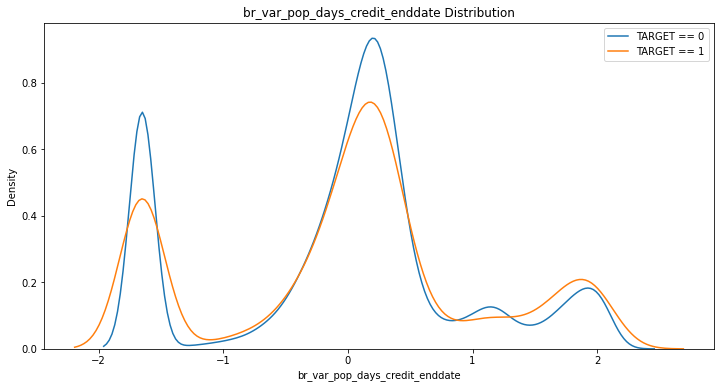

In [104]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_days_credit_enddate', app_train)

### br_var_samp_days_credit_enddate

In [105]:
app_train[['TARGET', 'br_var_samp_days_credit_enddate']].corr()

TARGET  br_var_samp_days_credit_enddate
TARGET                           1.000000                         0.028933
br_var_samp_days_credit_enddate  0.028933                         1.000000

The correlation between br_var_samp_days_credit_enddate and the TARGET is 0.0289
Median value for loan that was not repaid = 392730.8977
Median value for loan that was repaid =     389619.0633


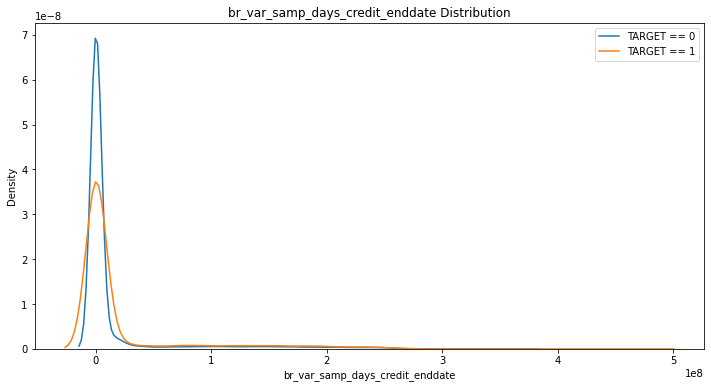

In [106]:
kde_target('br_var_samp_days_credit_enddate', app_train)

In [107]:
## Yao-Johnson変換
#num_cols = ['br_var_samp_days_credit_enddate']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_var_samp_days_credit_enddate'] = pt.transform(app_train[num_cols])
#app_test['br_var_samp_days_credit_enddate'] = pt.transform(app_test[num_cols])

In [108]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_var_samp_days_credit_enddate']].corr()

In [109]:

## Yao-Johnson変換後の特徴量の分布
#kde_target('br_var_samp_days_credit_enddate', app_train)

### br_variance_pop_days_credit_enddate

In [110]:
app_train[['TARGET', 'br_variance_pop_days_credit_enddate']].corr()

TARGET  \
TARGET                               1.000000   
br_variance_pop_days_credit_enddate  0.028361   

                                     br_variance_pop_days_credit_enddate  
TARGET                                                          0.028361  
br_variance_pop_days_credit_enddate                             1.000000

The correlation between br_variance_pop_days_credit_enddate and the TARGET is 0.0284
Median value for loan that was not repaid = 384881.3932
Median value for loan that was repaid =     383044.8725


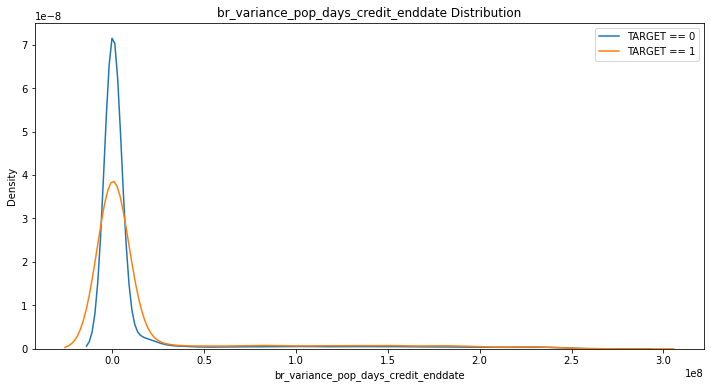

In [111]:
kde_target('br_variance_pop_days_credit_enddate', app_train)

### br_min_days_enddate_fact

In [112]:
app_train[['TARGET', 'br_min_days_enddate_fact']].corr()

TARGET  br_min_days_enddate_fact
TARGET                    1.000000                  0.062834
br_min_days_enddate_fact  0.062834                  1.000000

The correlation between br_min_days_enddate_fact and the TARGET is 0.0628
Median value for loan that was not repaid = -667.0000
Median value for loan that was repaid =     -914.0000


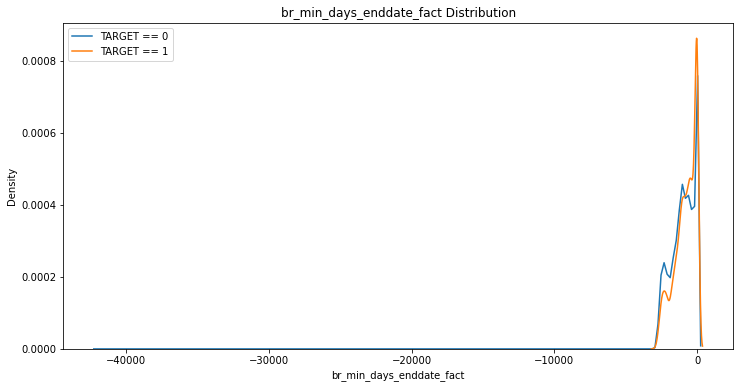

In [113]:
kde_target('br_min_days_enddate_fact', app_train)

In [114]:
## Yao-Johnson変換
num_cols = ['br_min_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_min_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [115]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_days_enddate_fact']].corr()

TARGET  br_min_days_enddate_fact
TARGET                    1.000000                  0.062636
br_min_days_enddate_fact  0.062636                  1.000000

The correlation between br_min_days_enddate_fact and the TARGET is 0.0626
Median value for loan that was not repaid = 0.0243
Median value for loan that was repaid =     -0.2396


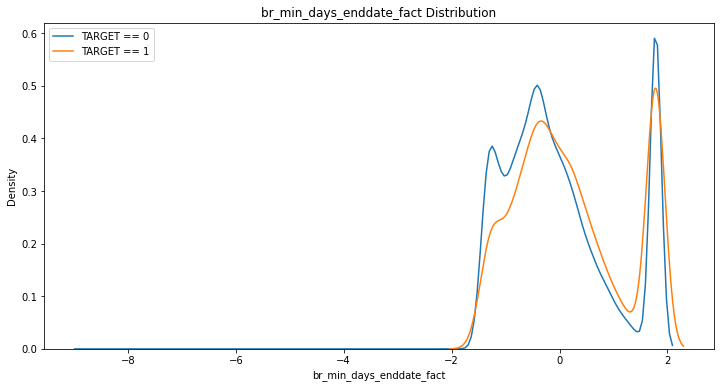

In [116]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_days_enddate_fact', app_train)

### br_max_days_enddate_fact

In [117]:
app_train[['TARGET', 'br_max_days_enddate_fact']].corr()

TARGET  br_max_days_enddate_fact
TARGET                    1.000000                  0.034308
br_max_days_enddate_fact  0.034308                  1.000000

The correlation between br_max_days_enddate_fact and the TARGET is 0.0343
Median value for loan that was not repaid = -201.0000
Median value for loan that was repaid =     -251.0000


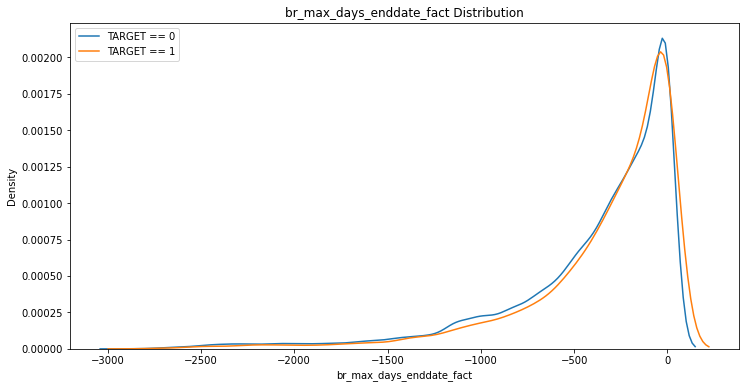

In [118]:
kde_target('br_max_days_enddate_fact', app_train)

In [119]:
## Yao-Johnson変換
num_cols = ['br_max_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_max_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [120]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_days_enddate_fact']].corr()

TARGET  br_max_days_enddate_fact
TARGET                    1.000000                  0.044711
br_max_days_enddate_fact  0.044711                  1.000000

The correlation between br_max_days_enddate_fact and the TARGET is 0.0447
Median value for loan that was not repaid = 0.0041
Median value for loan that was repaid =     -0.1333


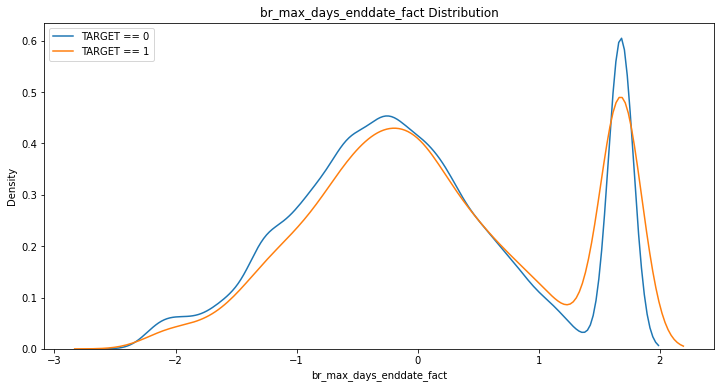

In [121]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_days_enddate_fact', app_train)

### br_sum_days_enddate_fact

In [122]:
app_train[['TARGET', 'br_sum_days_enddate_fact']].corr()

TARGET  br_sum_days_enddate_fact
TARGET                    1.000000                  0.049101
br_sum_days_enddate_fact  0.049101                  1.000000

The correlation between br_sum_days_enddate_fact and the TARGET is 0.0491
Median value for loan that was not repaid = -17290.5000
Median value for loan that was repaid =     -27962.0000


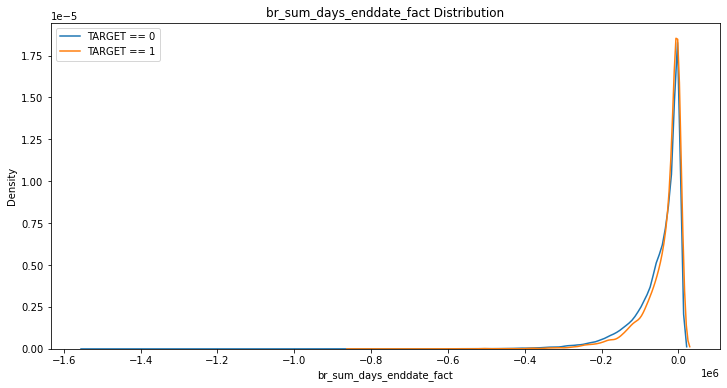

In [123]:
kde_target('br_sum_days_enddate_fact', app_train)

In [124]:
## Yao-Johnson変換
num_cols = ['br_sum_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_sum_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [125]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_days_enddate_fact']].corr()

TARGET  br_sum_days_enddate_fact
TARGET                    1.000000                  0.060465
br_sum_days_enddate_fact  0.060465                  1.000000

The correlation between br_sum_days_enddate_fact and the TARGET is 0.0605
Median value for loan that was not repaid = 0.0314
Median value for loan that was repaid =     -0.1987


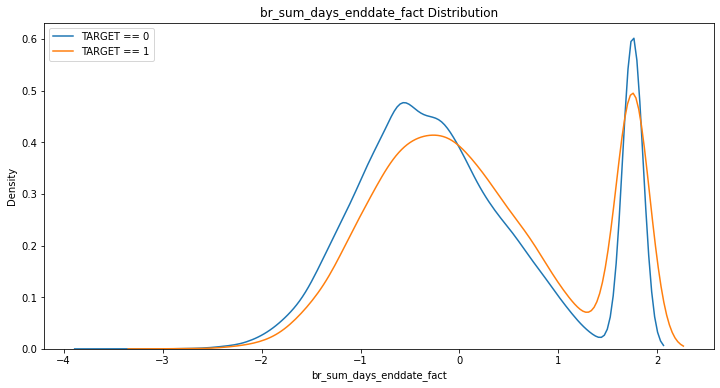

In [126]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_days_enddate_fact', app_train)

### br_avg_days_enddate_fact

In [127]:
app_train[['TARGET', 'br_avg_days_enddate_fact']].corr()

TARGET  br_avg_days_enddate_fact
TARGET                    1.000000                  0.059438
br_avg_days_enddate_fact  0.059438                  1.000000

The correlation between br_avg_days_enddate_fact and the TARGET is 0.0594
Median value for loan that was not repaid = -495.4527
Median value for loan that was repaid =     -639.3874


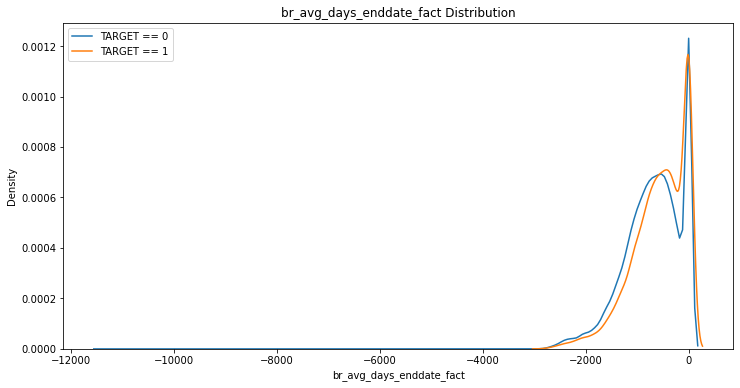

In [128]:
kde_target('br_avg_days_enddate_fact', app_train)

In [129]:
## Yao-Johnson変換
num_cols = ['br_avg_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_avg_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [130]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_days_enddate_fact']].corr()

TARGET  br_avg_days_enddate_fact
TARGET                    1.000000                  0.060823
br_avg_days_enddate_fact  0.060823                  1.000000

The correlation between br_avg_days_enddate_fact and the TARGET is 0.0608
Median value for loan that was not repaid = 0.0030
Median value for loan that was repaid =     -0.2236


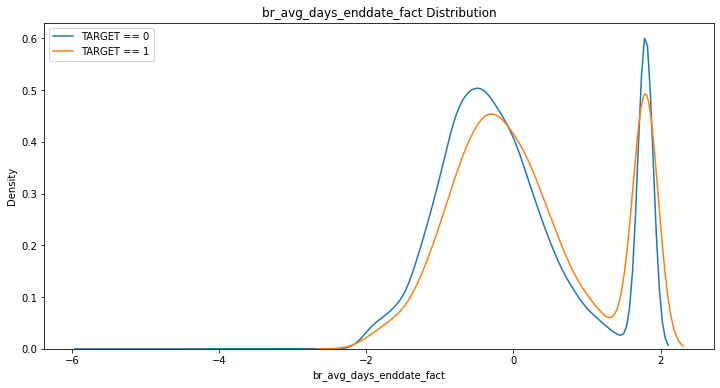

In [131]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_days_enddate_fact', app_train)

### br_cnt_days_enddate_fact

In [132]:
app_train[['TARGET', 'br_cnt_days_enddate_fact']].corr()

TARGET  br_cnt_days_enddate_fact
TARGET                    1.000000                 -0.040258
br_cnt_days_enddate_fact -0.040258                  1.000000

The correlation between br_cnt_days_enddate_fact and the TARGET is -0.0403
Median value for loan that was not repaid = 25.0000
Median value for loan that was repaid =     39.0000


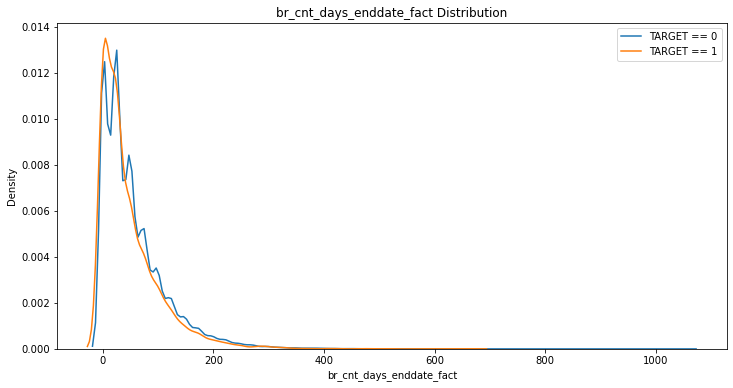

In [133]:
kde_target('br_cnt_days_enddate_fact', app_train)

In [134]:
## Yao-Johnson変換
num_cols = ['br_cnt_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_cnt_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [135]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_days_enddate_fact']].corr()

TARGET  br_cnt_days_enddate_fact
TARGET                    1.000000                 -0.051322
br_cnt_days_enddate_fact -0.051322                  1.000000

The correlation between br_cnt_days_enddate_fact and the TARGET is -0.0513
Median value for loan that was not repaid = -0.2253
Median value for loan that was repaid =     0.0962


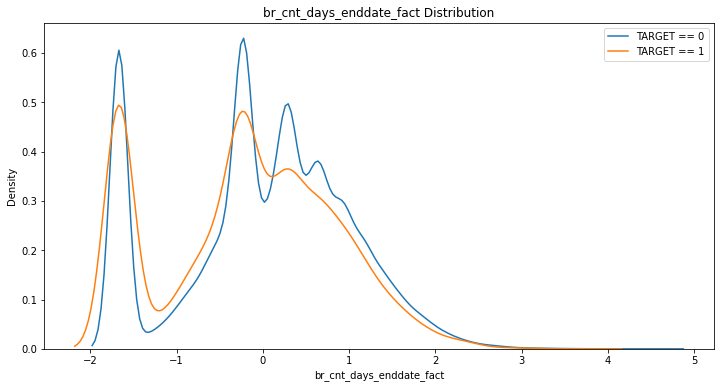

In [136]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_days_enddate_fact', app_train)

### br_stddev_days_enddate_fact

In [137]:
app_train[['TARGET', 'br_stddev_days_enddate_fact']].corr()

TARGET  br_stddev_days_enddate_fact
TARGET                       1.000000                    -0.048393
br_stddev_days_enddate_fact -0.048393                     1.000000

The correlation between br_stddev_days_enddate_fact and the TARGET is -0.0484
Median value for loan that was not repaid = 38.5863
Median value for loan that was repaid =     131.9935


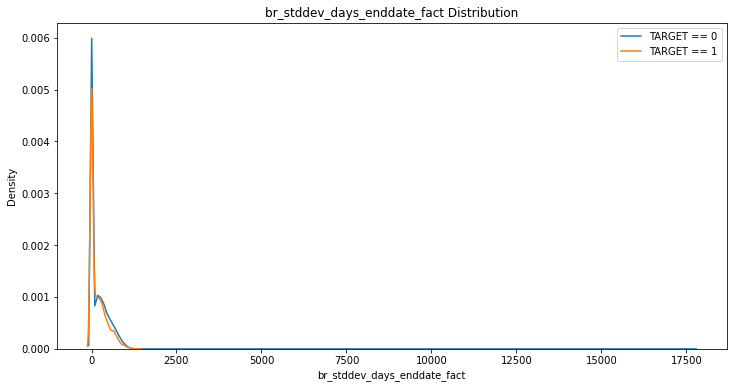

In [138]:
kde_target('br_stddev_days_enddate_fact', app_train)

In [139]:
## Yao-Johnson変換
#num_cols = ['br_stddev_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_days_enddate_fact'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [140]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_days_enddate_fact']].corr()

In [141]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_stddev_days_enddate_fact', app_train)

### br_stddev_pop_days_enddate_fact

In [142]:
app_train[['TARGET', 'br_stddev_pop_days_enddate_fact']].corr()

TARGET  br_stddev_pop_days_enddate_fact
TARGET                           1.000000                        -0.048393
br_stddev_pop_days_enddate_fact -0.048393                         1.000000

The correlation between br_stddev_pop_days_enddate_fact and the TARGET is -0.0484
Median value for loan that was not repaid = 38.5863
Median value for loan that was repaid =     131.9935


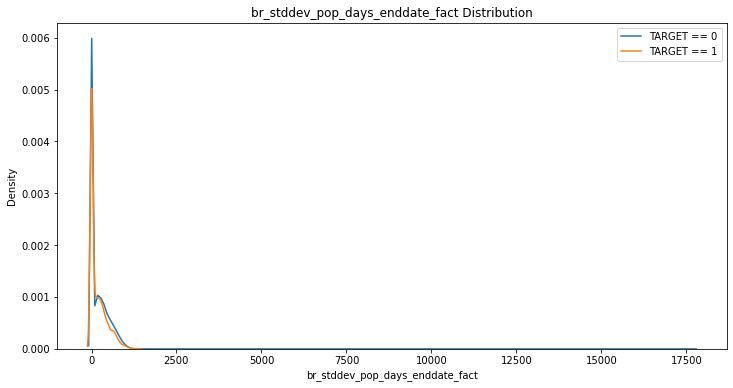

In [143]:
kde_target('br_stddev_pop_days_enddate_fact', app_train)

In [144]:
## Yao-Johnson変換
#num_cols = ['br_stddev_pop_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_stddev_pop_days_enddate_fact'] = pt.transform(app_train[num_cols])
#app_test['br_stddev_pop_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [145]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_stddev_pop_days_enddate_fact']].corr()

The correlation between br_stddev_pop_days_enddate_fact and the TARGET is -0.0484
Median value for loan that was not repaid = 38.5863
Median value for loan that was repaid =     131.9935


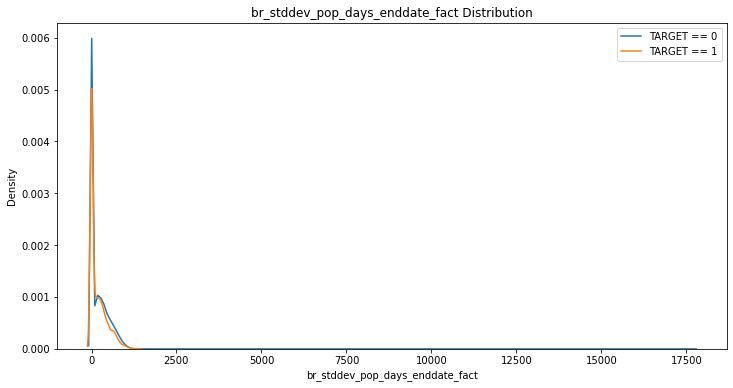

In [146]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_days_enddate_fact', app_train)

### br_var_pop_days_enddate_fact

In [147]:
app_train[['TARGET', 'br_var_pop_days_enddate_fact']].corr()

TARGET  br_var_pop_days_enddate_fact
TARGET                        1.000000                     -0.008913
br_var_pop_days_enddate_fact -0.008913                      1.000000

The correlation between br_var_pop_days_enddate_fact and the TARGET is -0.0089
Median value for loan that was not repaid = 1488.9420
Median value for loan that was repaid =     17422.2866


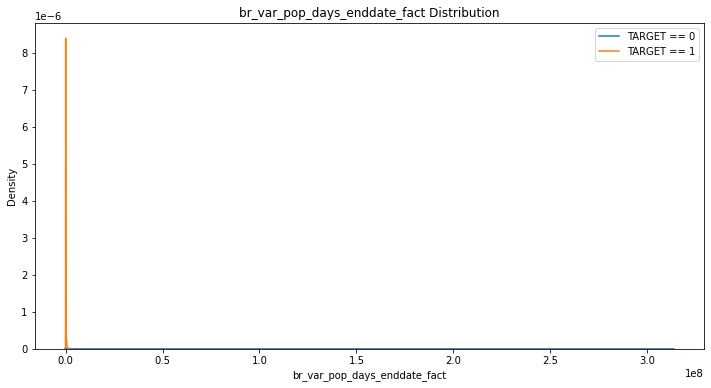

In [148]:
kde_target('br_var_pop_days_enddate_fact', app_train)

In [149]:
## Yao-Johnson変換
num_cols = ['br_var_pop_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [150]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_days_enddate_fact']].corr()

TARGET  br_var_pop_days_enddate_fact
TARGET                        1.000000                     -0.045964
br_var_pop_days_enddate_fact -0.045964                      1.000000

The correlation between br_var_pop_days_enddate_fact and the TARGET is -0.0460
Median value for loan that was not repaid = -0.0173
Median value for loan that was repaid =     0.4614


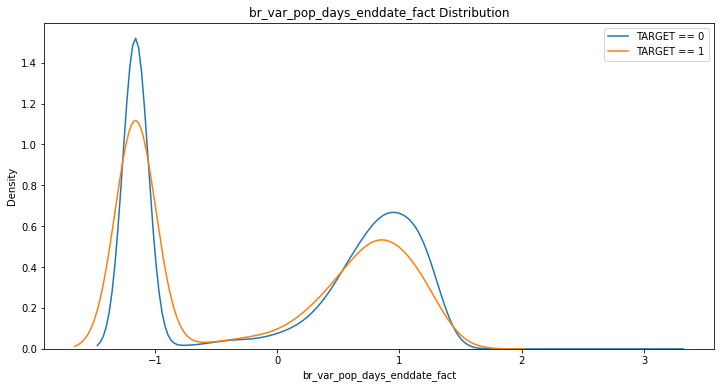

In [151]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_days_enddate_fact', app_train)

### br_var_samp_days_enddate_fact

In [152]:
app_train[['TARGET', 'br_var_samp_days_enddate_fact']].corr()

TARGET  br_var_samp_days_enddate_fact
TARGET                         1.000000                      -0.008934
br_var_samp_days_enddate_fact -0.008934                       1.000000

The correlation between br_var_samp_days_enddate_fact and the TARGET is -0.0089
Median value for loan that was not repaid = 1542.9302
Median value for loan that was repaid =     17914.5408


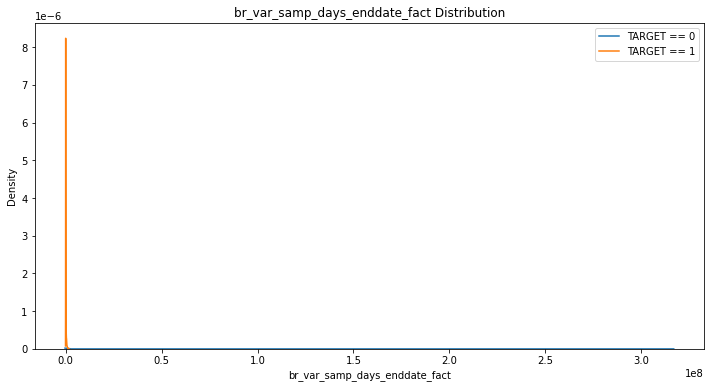

In [153]:
kde_target('br_var_samp_days_enddate_fact', app_train)

In [154]:
## Yao-Johnson変換
num_cols = ['br_var_samp_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [155]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_days_enddate_fact']].corr()

TARGET  br_var_samp_days_enddate_fact
TARGET                         1.000000                      -0.045905
br_var_samp_days_enddate_fact -0.045905                       1.000000

The correlation between br_var_samp_days_enddate_fact and the TARGET is -0.0459
Median value for loan that was not repaid = -0.0141
Median value for loan that was repaid =     0.4633


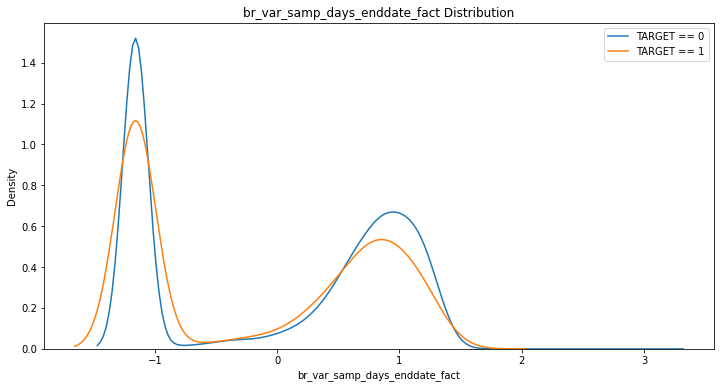

In [156]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_days_enddate_fact', app_train)

### br_variance_pop_days_enddate_fact

In [157]:
app_train[['TARGET', 'br_variance_pop_days_enddate_fact']].corr()

TARGET  br_variance_pop_days_enddate_fact
TARGET                             1.000000                          -0.008913
br_variance_pop_days_enddate_fact -0.008913                           1.000000

The correlation between br_variance_pop_days_enddate_fact and the TARGET is -0.0089
Median value for loan that was not repaid = 1488.9420
Median value for loan that was repaid =     17422.2866


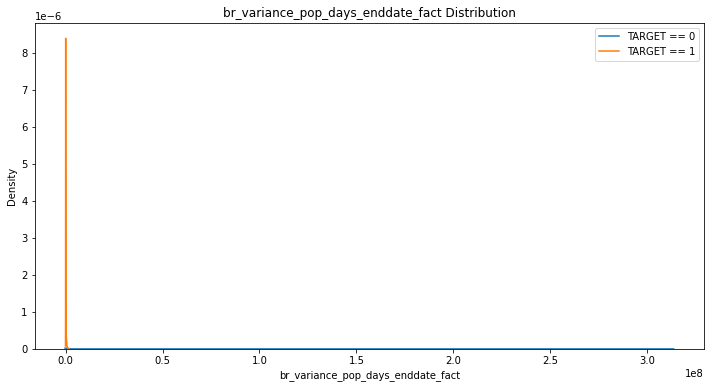

In [158]:
kde_target('br_variance_pop_days_enddate_fact', app_train)

In [159]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_days_enddate_fact']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_days_enddate_fact'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_days_enddate_fact'] = pt.transform(app_test[num_cols])

In [160]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_days_enddate_fact']].corr()

TARGET  br_variance_pop_days_enddate_fact
TARGET                             1.000000                          -0.045964
br_variance_pop_days_enddate_fact -0.045964                           1.000000

The correlation between br_variance_pop_days_enddate_fact and the TARGET is -0.0460
Median value for loan that was not repaid = -0.0173
Median value for loan that was repaid =     0.4614


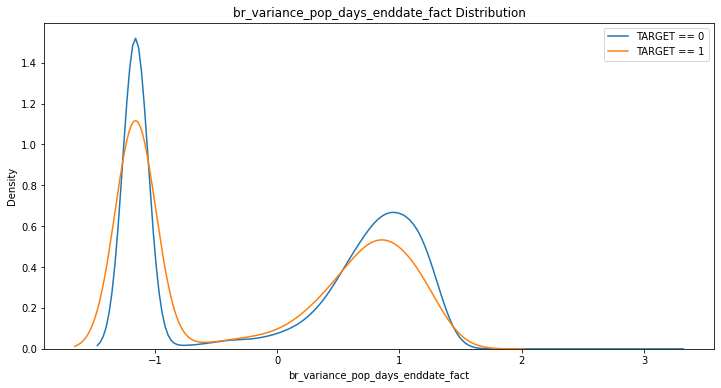

In [161]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_days_enddate_fact', app_train)

### br_min_amt_credit_max_overdue

In [162]:
app_train[['TARGET', 'br_min_amt_credit_max_overdue']].corr()

TARGET  br_min_amt_credit_max_overdue
TARGET                         1.000000                       0.002486
br_min_amt_credit_max_overdue  0.002486                       1.000000

The correlation between br_min_amt_credit_max_overdue and the TARGET is 0.0025
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


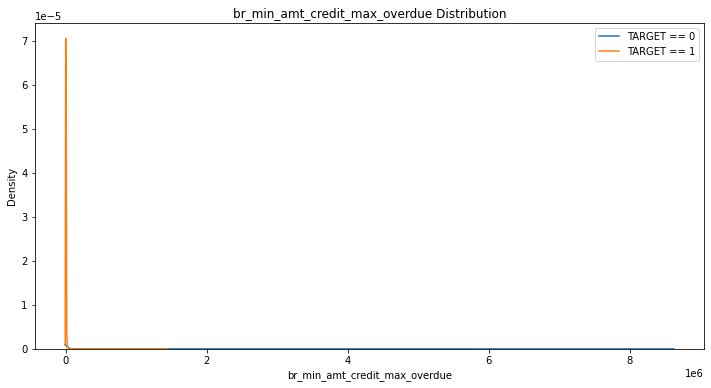

In [163]:
kde_target('br_min_amt_credit_max_overdue', app_train)

In [164]:
num_cols = ['br_min_amt_credit_max_overdue']
# 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

# 変換後のデータで各列を置換
app_train['br_min_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_min_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [165]:
app_train[['TARGET', 'br_min_amt_credit_max_overdue']].corr()

TARGET  br_min_amt_credit_max_overdue
TARGET                         1.000000                       0.027783
br_min_amt_credit_max_overdue  0.027783                       1.000000

The correlation between br_min_amt_credit_max_overdue and the TARGET is 0.0278
Median value for loan that was not repaid = -0.2597
Median value for loan that was repaid =     -0.2597


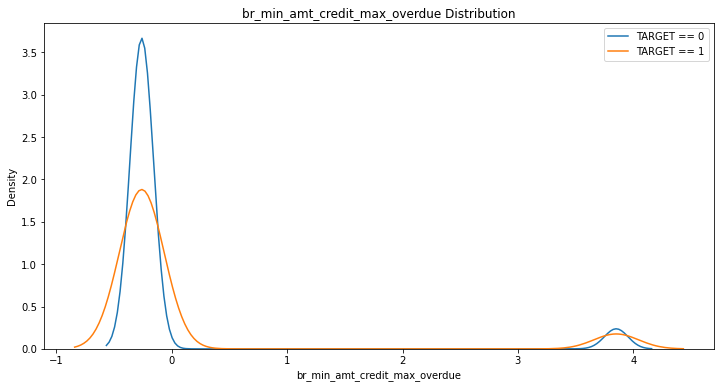

In [166]:
kde_target('br_min_amt_credit_max_overdue', app_train)

### br_max_amt_credit_max_overdue

In [167]:
app_train[['TARGET', 'br_max_amt_credit_max_overdue']].corr()

TARGET  br_max_amt_credit_max_overdue
TARGET                         1.000000                       0.000341
br_max_amt_credit_max_overdue  0.000341                       1.000000

The correlation between br_max_amt_credit_max_overdue and the TARGET is 0.0003
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


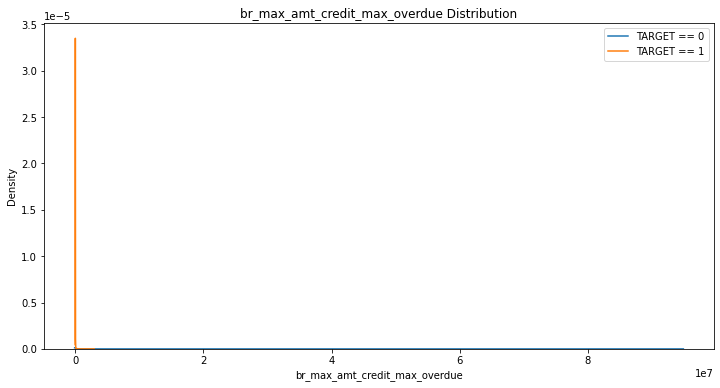

In [168]:
kde_target('br_max_amt_credit_max_overdue', app_train)

In [169]:
num_cols = ['br_max_amt_credit_max_overdue']
# 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

# 変換後のデータで各列を置換
app_train['br_max_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_max_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [170]:
app_train[['TARGET', 'br_max_amt_credit_max_overdue']].corr()

TARGET  br_max_amt_credit_max_overdue
TARGET                         1.000000                       0.044224
br_max_amt_credit_max_overdue  0.044224                       1.000000

The correlation between br_max_amt_credit_max_overdue and the TARGET is 0.0442
Median value for loan that was not repaid = -0.5059
Median value for loan that was repaid =     -0.5059


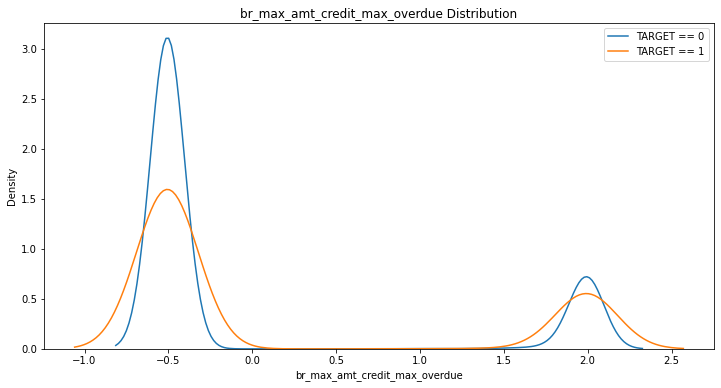

In [171]:
kde_target('br_max_amt_credit_max_overdue', app_train)

### br_sum_amt_credit_max_overdue

In [172]:
app_train[['TARGET', 'br_sum_amt_credit_max_overdue']].corr()

TARGET  br_sum_amt_credit_max_overdue
TARGET                         1.000000                      -0.000031
br_sum_amt_credit_max_overdue -0.000031                       1.000000

The correlation between br_sum_amt_credit_max_overdue and the TARGET is -0.0000
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


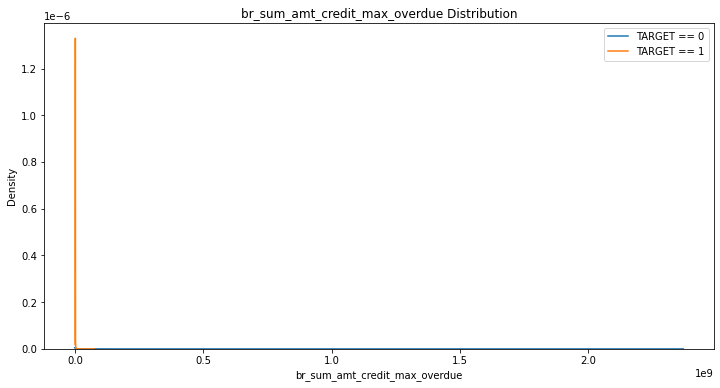

In [173]:
kde_target('br_sum_amt_credit_max_overdue', app_train)

In [174]:
num_cols = ['br_sum_amt_credit_max_overdue']
# 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

# 変換後のデータで各列を置換
app_train['br_sum_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [175]:
app_train[['TARGET', 'br_sum_amt_credit_max_overdue']].corr()

TARGET  br_sum_amt_credit_max_overdue
TARGET                         1.000000                       0.043834
br_sum_amt_credit_max_overdue  0.043834                       1.000000

The correlation between br_sum_amt_credit_max_overdue and the TARGET is 0.0438
Median value for loan that was not repaid = -0.5065
Median value for loan that was repaid =     -0.5065


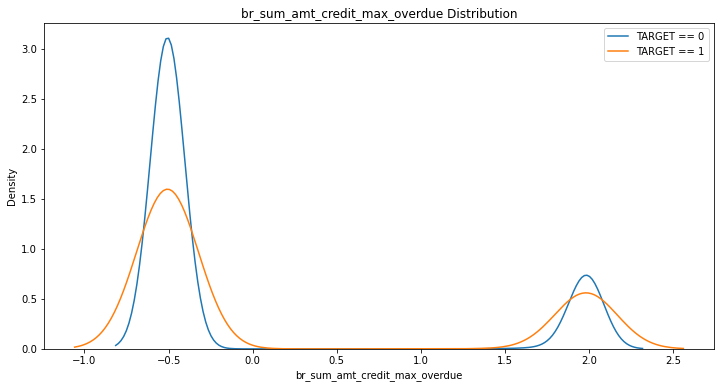

In [176]:
kde_target('br_sum_amt_credit_max_overdue', app_train)

### br_avg_amt_credit_max_overdue

In [177]:
app_train[['TARGET', 'br_avg_amt_credit_max_overdue']].corr()

TARGET  br_avg_amt_credit_max_overdue
TARGET                         1.000000                      -0.000186
br_avg_amt_credit_max_overdue -0.000186                       1.000000

The correlation between br_avg_amt_credit_max_overdue and the TARGET is -0.0002
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


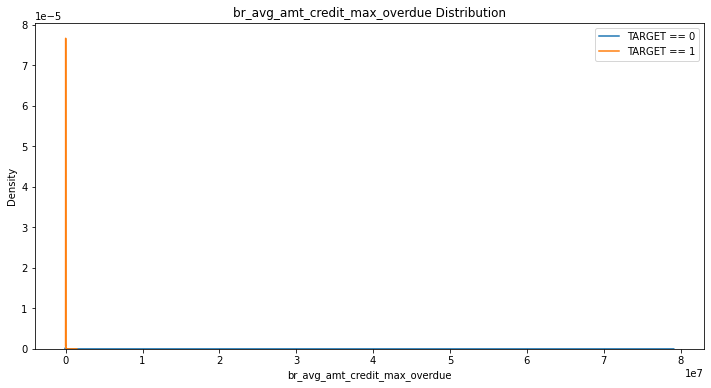

In [178]:
kde_target('br_avg_amt_credit_max_overdue', app_train)

In [179]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [180]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_max_overdue']].corr()

TARGET  br_avg_amt_credit_max_overdue
TARGET                         1.000000                       0.044205
br_avg_amt_credit_max_overdue  0.044205                       1.000000

The correlation between br_avg_amt_credit_max_overdue and the TARGET is 0.0442
Median value for loan that was not repaid = -0.5052
Median value for loan that was repaid =     -0.5052


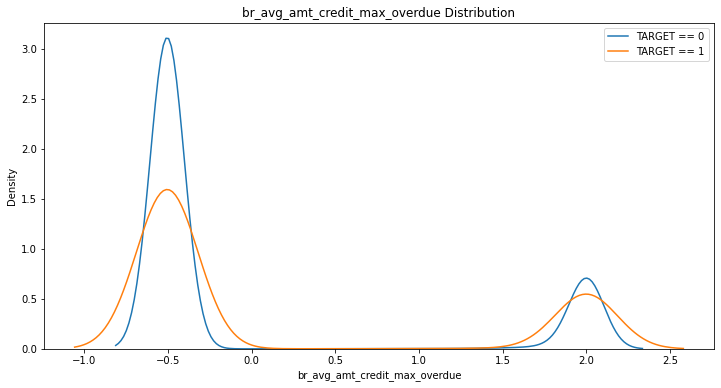

In [181]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_credit_max_overdue', app_train)

### br_cnt_amt_credit_max_overdue

In [182]:
app_train[['TARGET', 'br_cnt_amt_credit_max_overdue']].corr()

TARGET  br_cnt_amt_credit_max_overdue
TARGET                         1.000000                      -0.007219
br_cnt_amt_credit_max_overdue -0.007219                       1.000000

The correlation between br_cnt_amt_credit_max_overdue and the TARGET is -0.0072
Median value for loan that was not repaid = 13.0000
Median value for loan that was repaid =     15.0000


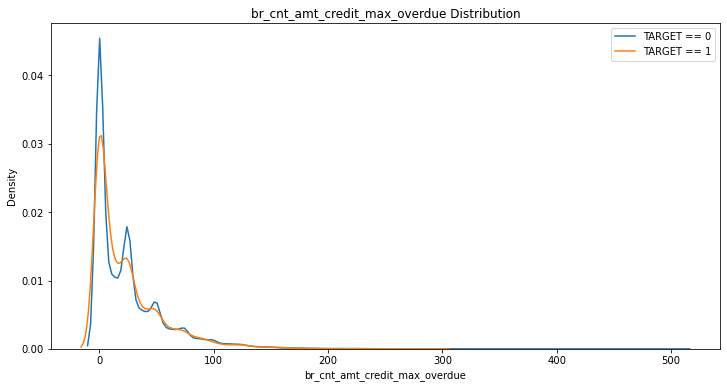

In [183]:
kde_target('br_cnt_amt_credit_max_overdue', app_train)

In [184]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [185]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_max_overdue']].corr()

TARGET  br_cnt_amt_credit_max_overdue
TARGET                         1.000000                      -0.000648
br_cnt_amt_credit_max_overdue -0.000648                       1.000000

The correlation between br_cnt_amt_credit_max_overdue and the TARGET is -0.0006
Median value for loan that was not repaid = 0.2145
Median value for loan that was repaid =     0.2952


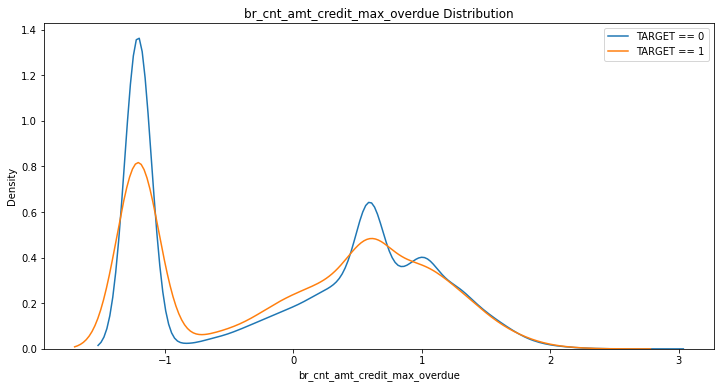

In [186]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_max_overdue', app_train)

### br_stddev_amt_credit_max_overdue

In [187]:
app_train[['TARGET', 'br_stddev_amt_credit_max_overdue']].corr()

TARGET  br_stddev_amt_credit_max_overdue
TARGET                            1.000000                          0.000122
br_stddev_amt_credit_max_overdue  0.000122                          1.000000

The correlation between br_stddev_amt_credit_max_overdue and the TARGET is 0.0001
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


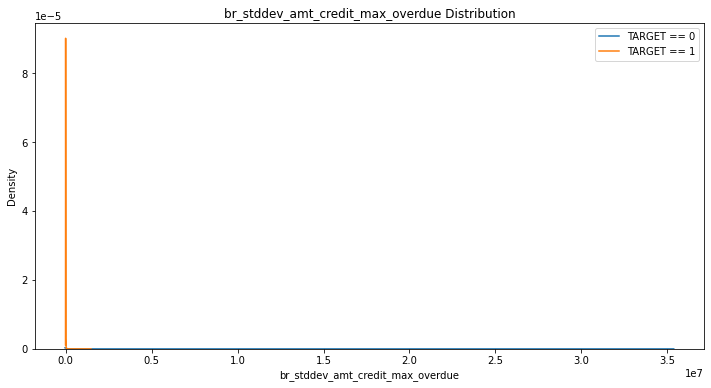

In [188]:
kde_target('br_stddev_amt_credit_max_overdue', app_train)

In [189]:
## Yao-Johnson変換
num_cols = ['br_stddev_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [190]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_max_overdue']].corr()

TARGET  br_stddev_amt_credit_max_overdue
TARGET                            1.000000                          0.036155
br_stddev_amt_credit_max_overdue  0.036155                          1.000000

The correlation between br_stddev_amt_credit_max_overdue and the TARGET is 0.0362
Median value for loan that was not repaid = -0.4259
Median value for loan that was repaid =     -0.4259


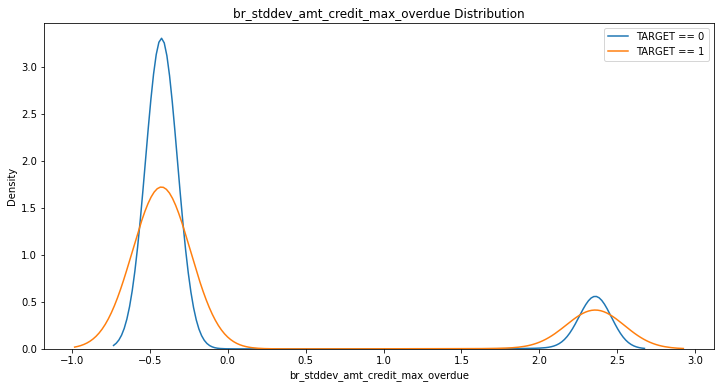

In [191]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_amt_credit_max_overdue', app_train)

### br_stddev_pop_amt_credit_max_overdue

In [192]:
app_train[['TARGET', 'br_stddev_pop_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                                1.000000   
br_stddev_pop_amt_credit_max_overdue  0.000122   

                                      br_stddev_pop_amt_credit_max_overdue  
TARGET                                                            0.000122  
br_stddev_pop_amt_credit_max_overdue                              1.000000

The correlation between br_stddev_pop_amt_credit_max_overdue and the TARGET is 0.0001
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


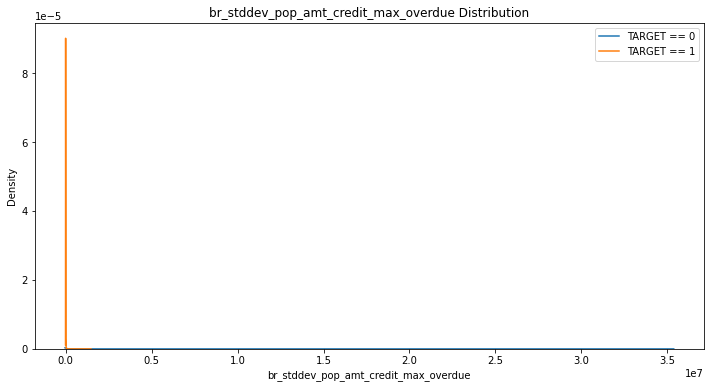

In [193]:
kde_target('br_stddev_pop_amt_credit_max_overdue', app_train)

In [194]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [195]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                                1.000000   
br_stddev_pop_amt_credit_max_overdue  0.036155   

                                      br_stddev_pop_amt_credit_max_overdue  
TARGET                                                            0.036155  
br_stddev_pop_amt_credit_max_overdue                              1.000000

The correlation between br_stddev_pop_amt_credit_max_overdue and the TARGET is 0.0362
Median value for loan that was not repaid = -0.4259
Median value for loan that was repaid =     -0.4259


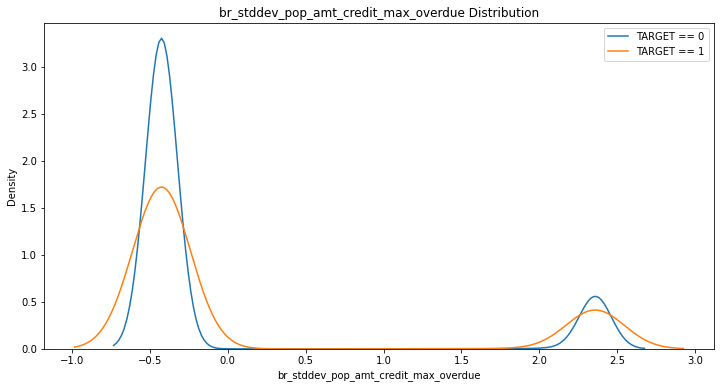

In [196]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_amt_credit_max_overdue', app_train)

### br_var_pop_amt_credit_max_overdue

In [197]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_max_overdue']].corr()

TARGET  br_var_pop_amt_credit_max_overdue
TARGET                             1.000000                          -0.000977
br_var_pop_amt_credit_max_overdue -0.000977                           1.000000

The correlation between br_var_pop_amt_credit_max_overdue and the TARGET is -0.0010
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


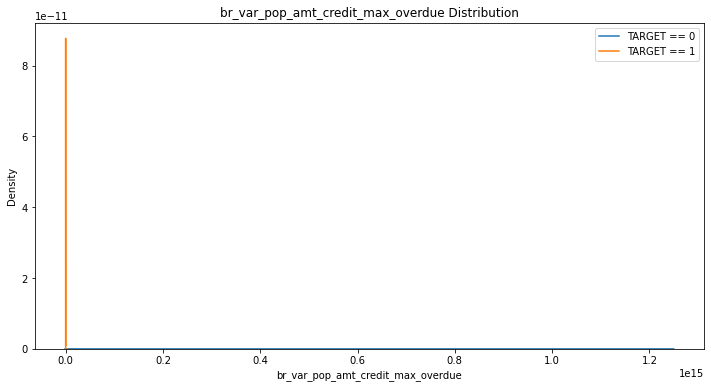

In [198]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_max_overdue', app_train)

In [199]:
## Yao-Johnson変換
num_cols = ['br_var_pop_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [200]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_max_overdue']].corr()

TARGET  br_var_pop_amt_credit_max_overdue
TARGET                             1.000000                           0.036194
br_var_pop_amt_credit_max_overdue  0.036194                           1.000000

The correlation between br_var_pop_amt_credit_max_overdue and the TARGET is 0.0362
Median value for loan that was not repaid = -0.4256
Median value for loan that was repaid =     -0.4256


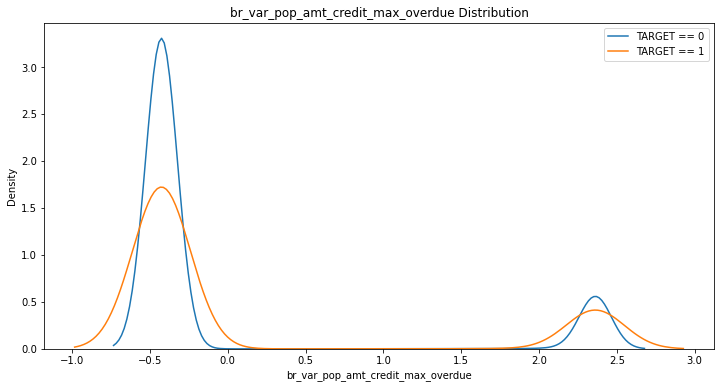

In [201]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_amt_credit_max_overdue', app_train)

### br_var_samp_amt_credit_max_overdue

In [202]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_var_samp_amt_credit_max_overdue -0.000977   

                                    br_var_samp_amt_credit_max_overdue  
TARGET                                                       -0.000977  
br_var_samp_amt_credit_max_overdue                            1.000000

The correlation between br_var_samp_amt_credit_max_overdue and the TARGET is -0.0010
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


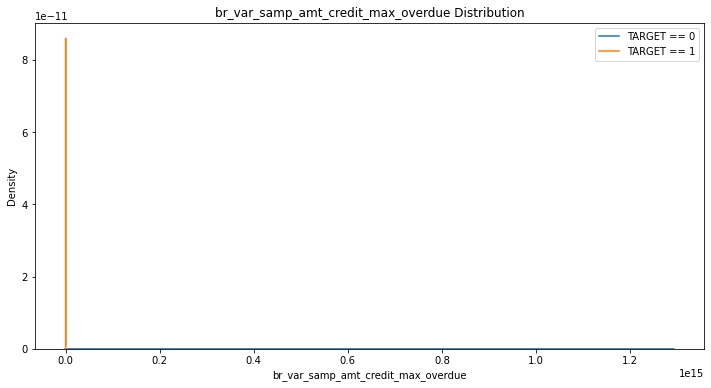

In [203]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_max_overdue', app_train)

In [204]:
## Yao-Johnson変換
num_cols = ['br_var_samp_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [205]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_var_samp_amt_credit_max_overdue  0.036193   

                                    br_var_samp_amt_credit_max_overdue  
TARGET                                                        0.036193  
br_var_samp_amt_credit_max_overdue                            1.000000

The correlation between br_var_samp_amt_credit_max_overdue and the TARGET is 0.0362
Median value for loan that was not repaid = -0.4257
Median value for loan that was repaid =     -0.4257


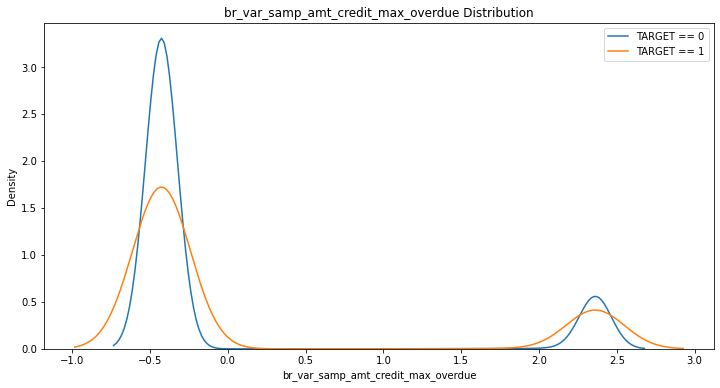

In [206]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_amt_credit_max_overdue', app_train)

### br_variance_pop_amt_credit_max_overdue

In [207]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                                  1.000000   
br_variance_pop_amt_credit_max_overdue -0.000977   

                                        br_variance_pop_amt_credit_max_overdue  
TARGET                                                               -0.000977  
br_variance_pop_amt_credit_max_overdue                                1.000000

The correlation between br_variance_pop_amt_credit_max_overdue and the TARGET is -0.0010
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


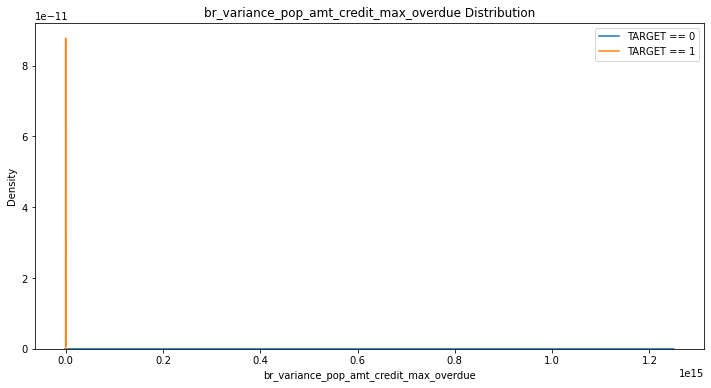

In [208]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_max_overdue', app_train)

In [209]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [210]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_max_overdue']].corr()

TARGET  \
TARGET                                  1.000000   
br_variance_pop_amt_credit_max_overdue  0.036194   

                                        br_variance_pop_amt_credit_max_overdue  
TARGET                                                                0.036194  
br_variance_pop_amt_credit_max_overdue                                1.000000

The correlation between br_variance_pop_amt_credit_max_overdue and the TARGET is 0.0362
Median value for loan that was not repaid = -0.4256
Median value for loan that was repaid =     -0.4256


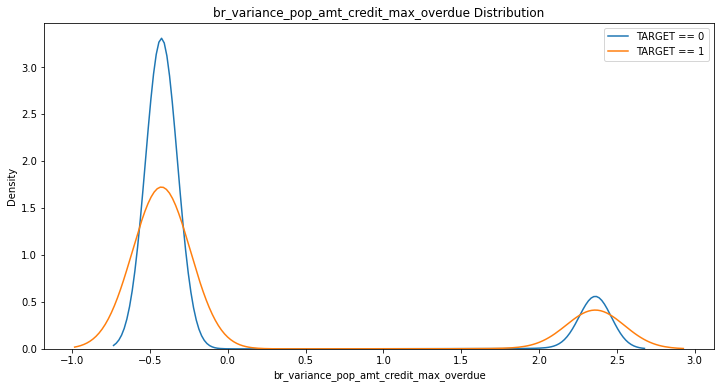

In [211]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_credit_max_overdue', app_train)

### br_min_cnt_credit_prolong

In [212]:
app_train[['TARGET', 'br_min_cnt_credit_prolong']].corr()

TARGET  br_min_cnt_credit_prolong
TARGET                     1.000000                   0.005432
br_min_cnt_credit_prolong  0.005432                   1.000000

The correlation between br_min_cnt_credit_prolong and the TARGET is 0.0054
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


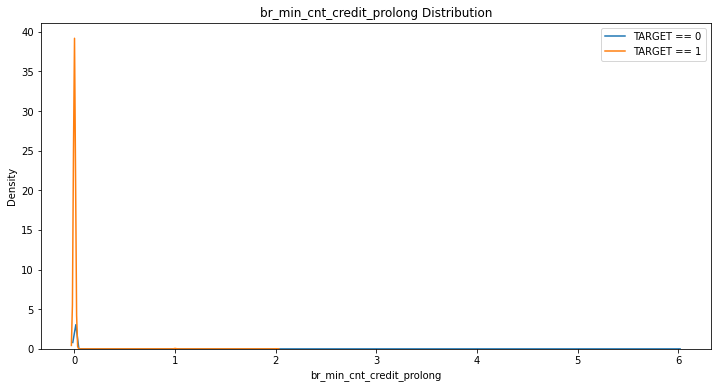

In [213]:
kde_target('br_min_cnt_credit_prolong', app_train)

In [214]:
## Yao-Johnson変換
num_cols = ['br_min_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_min_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [215]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_cnt_credit_prolong']].corr()

TARGET  br_min_cnt_credit_prolong
TARGET                     1.000000                   0.007351
br_min_cnt_credit_prolong  0.007351                   1.000000

The correlation between br_min_cnt_credit_prolong and the TARGET is 0.0074
Median value for loan that was not repaid = -0.0343
Median value for loan that was repaid =     -0.0343


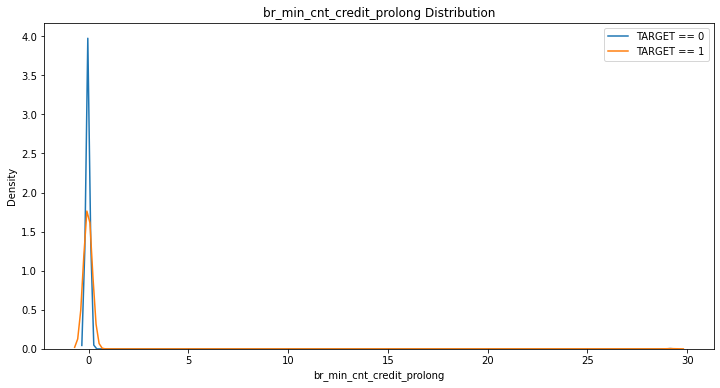

In [216]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_cnt_credit_prolong', app_train)

### br_max_cnt_credit_prolong

In [217]:
## 目的変数との相関
app_train[['TARGET', 'br_max_cnt_credit_prolong']].corr()

TARGET  br_max_cnt_credit_prolong
TARGET                     1.000000                   0.007751
br_max_cnt_credit_prolong  0.007751                   1.000000

The correlation between br_max_cnt_credit_prolong and the TARGET is 0.0078
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


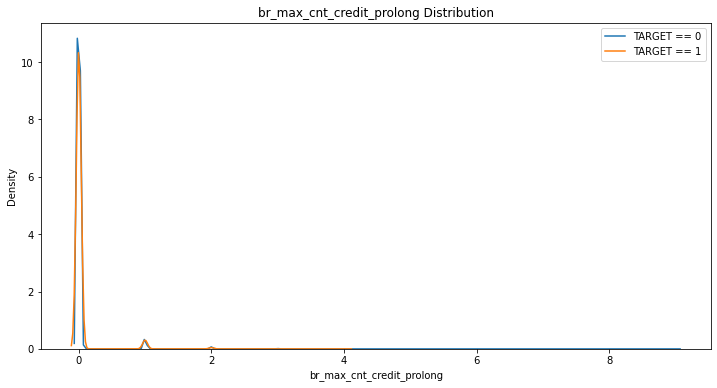

In [218]:
## 特徴量の分布
kde_target('br_max_cnt_credit_prolong', app_train)

In [219]:
## Yao-Johnson変換
num_cols = ['br_max_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_max_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [220]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_cnt_credit_prolong']].corr()

TARGET  br_max_cnt_credit_prolong
TARGET                     1.000000                   0.012069
br_max_cnt_credit_prolong  0.012069                   1.000000

The correlation between br_max_cnt_credit_prolong and the TARGET is 0.0121
Median value for loan that was not repaid = -0.1654
Median value for loan that was repaid =     -0.1654


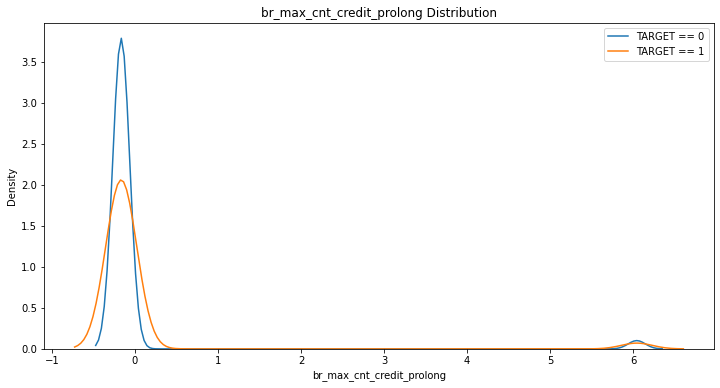

In [221]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_cnt_credit_prolong', app_train)

### br_sum_cnt_credit_prolong

In [222]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_cnt_credit_prolong']].corr()

TARGET  br_sum_cnt_credit_prolong
TARGET                     1.00000                    0.00405
br_sum_cnt_credit_prolong  0.00405                    1.00000

The correlation between br_sum_cnt_credit_prolong and the TARGET is 0.0041
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


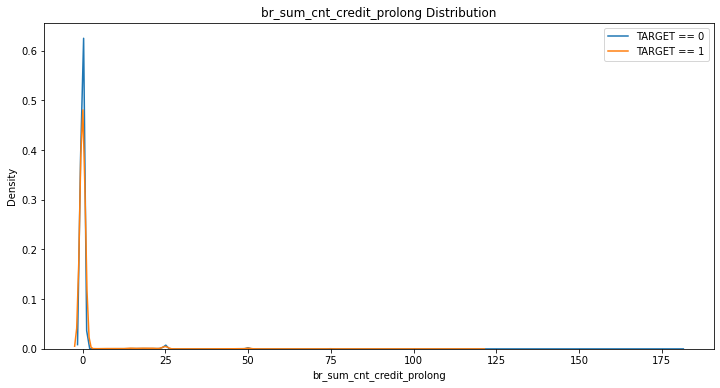

In [223]:
## 特徴量の分布
kde_target('br_sum_cnt_credit_prolong', app_train)

In [224]:
## Yao-Johnson変換
num_cols = ['br_sum_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_sum_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [225]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_cnt_credit_prolong']].corr()

TARGET  br_sum_cnt_credit_prolong
TARGET                     1.000000                   0.012069
br_sum_cnt_credit_prolong  0.012069                   1.000000

The correlation between br_sum_cnt_credit_prolong and the TARGET is 0.0121
Median value for loan that was not repaid = -0.1654
Median value for loan that was repaid =     -0.1654


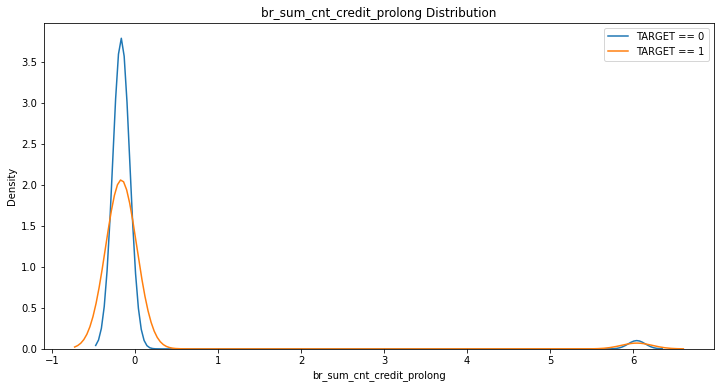

In [226]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_cnt_credit_prolong', app_train)

### br_avg_cnt_credit_prolong

In [227]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_cnt_credit_prolong']].corr()

TARGET  br_avg_cnt_credit_prolong
TARGET                     1.0000                     0.0091
br_avg_cnt_credit_prolong  0.0091                     1.0000

The correlation between br_avg_cnt_credit_prolong and the TARGET is 0.0091
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


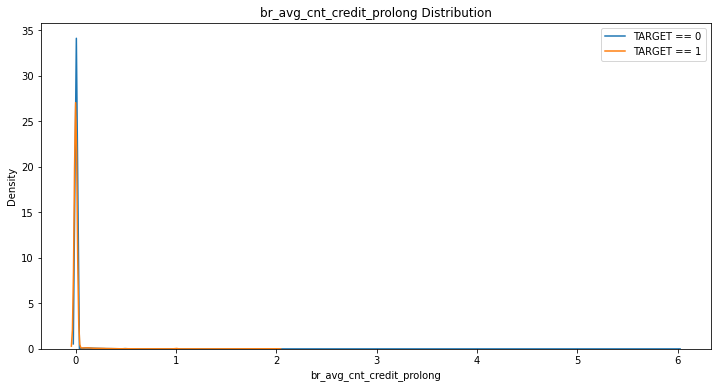

In [228]:
## 特徴量の分布
kde_target('br_avg_cnt_credit_prolong', app_train)

In [229]:
## Yao-Johnson変換
num_cols = ['br_avg_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_avg_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [230]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_cnt_credit_prolong']].corr()

TARGET  br_avg_cnt_credit_prolong
TARGET                     1.000000                   0.012013
br_avg_cnt_credit_prolong  0.012013                   1.000000

The correlation between br_avg_cnt_credit_prolong and the TARGET is 0.0120
Median value for loan that was not repaid = -0.1653
Median value for loan that was repaid =     -0.1653


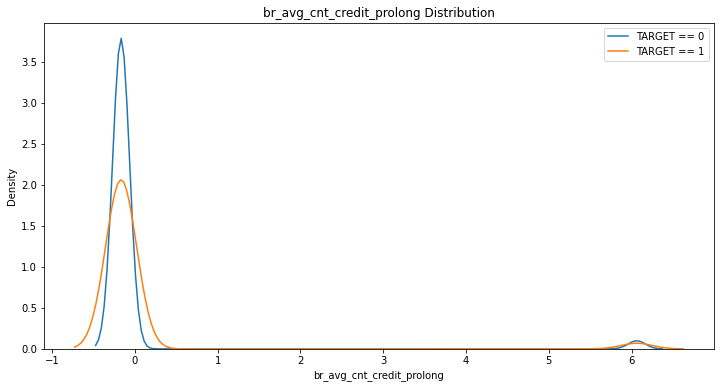

In [231]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_cnt_credit_prolong', app_train)

### br_cnt_cnt_credit_prolong

In [232]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_cnt_credit_prolong']].corr()

TARGET  br_cnt_cnt_credit_prolong
TARGET                     1.000000                  -0.024241
br_cnt_cnt_credit_prolong -0.024241                   1.000000

The correlation between br_cnt_cnt_credit_prolong and the TARGET is -0.0242
Median value for loan that was not repaid = 55.0000
Median value for loan that was repaid =     63.0000


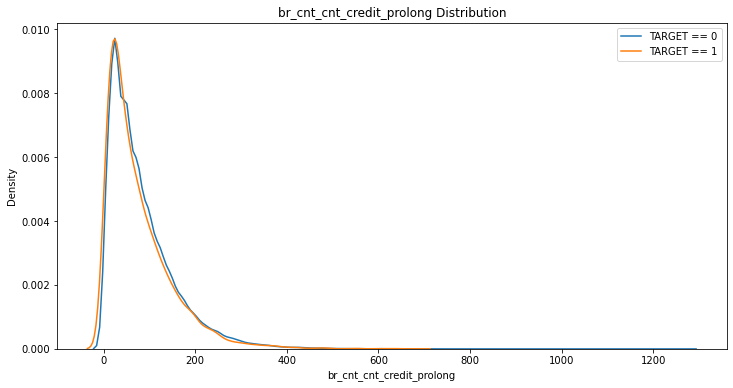

In [233]:
## 特徴量の分布
kde_target('br_cnt_cnt_credit_prolong', app_train)

### br_stddev_cnt_credit_prolong

In [234]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_cnt_credit_prolong']].corr()

TARGET  br_stddev_cnt_credit_prolong
TARGET                        1.000000                      0.006857
br_stddev_cnt_credit_prolong  0.006857                      1.000000

The correlation between br_stddev_cnt_credit_prolong and the TARGET is 0.0069
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


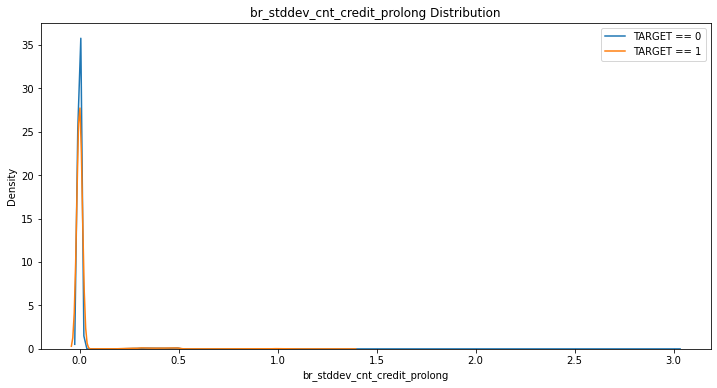

In [235]:
## 特徴量の分布
kde_target('br_stddev_cnt_credit_prolong', app_train)

In [236]:
## Yao-Johnson変換
num_cols = ['br_stddev_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_stddev_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [237]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_cnt_credit_prolong']].corr()

TARGET  br_stddev_cnt_credit_prolong
TARGET                        1.000000                      0.010737
br_stddev_cnt_credit_prolong  0.010737                      1.000000

The correlation between br_stddev_cnt_credit_prolong and the TARGET is 0.0107
Median value for loan that was not repaid = -0.1616
Median value for loan that was repaid =     -0.1616


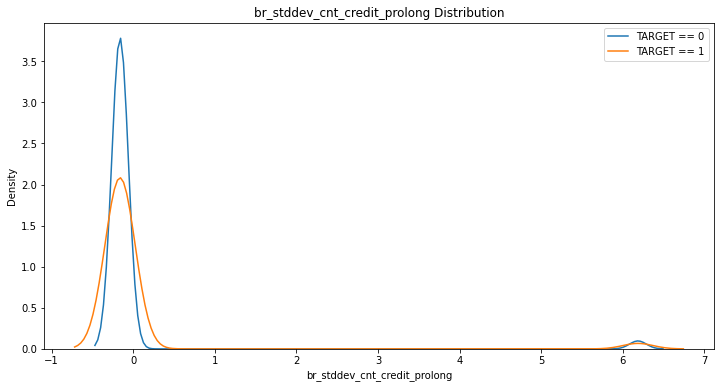

In [238]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_cnt_credit_prolong', app_train)

### br_stddev_pop_cnt_credit_prolong

In [239]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_cnt_credit_prolong']].corr()

TARGET  br_stddev_pop_cnt_credit_prolong
TARGET                            1.000000                          0.006857
br_stddev_pop_cnt_credit_prolong  0.006857                          1.000000

The correlation between br_stddev_pop_cnt_credit_prolong and the TARGET is 0.0069
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


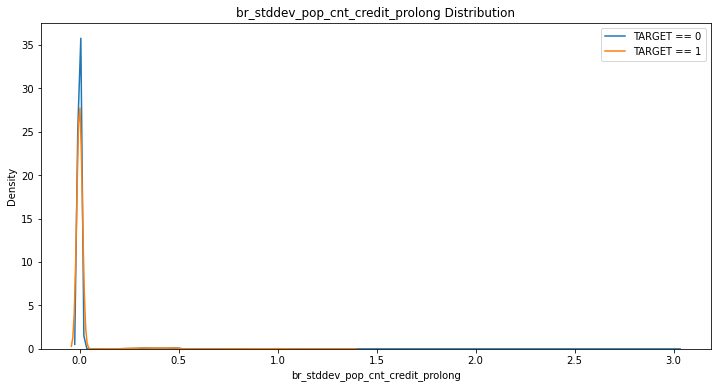

In [240]:
## 特徴量の分布
kde_target('br_stddev_pop_cnt_credit_prolong', app_train)

In [241]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [242]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_cnt_credit_prolong']].corr()

TARGET  br_stddev_pop_cnt_credit_prolong
TARGET                            1.000000                          0.010737
br_stddev_pop_cnt_credit_prolong  0.010737                          1.000000

The correlation between br_stddev_pop_cnt_credit_prolong and the TARGET is 0.0107
Median value for loan that was not repaid = -0.1616
Median value for loan that was repaid =     -0.1616


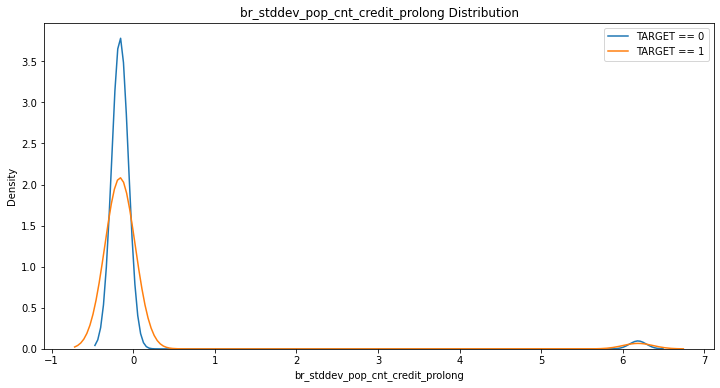

In [243]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_cnt_credit_prolong', app_train)

### br_var_pop_cnt_credit_prolong

In [244]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_cnt_credit_prolong']].corr()

TARGET  br_var_pop_cnt_credit_prolong
TARGET                         1.000000                       0.002124
br_var_pop_cnt_credit_prolong  0.002124                       1.000000

The correlation between br_var_pop_cnt_credit_prolong and the TARGET is 0.0021
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


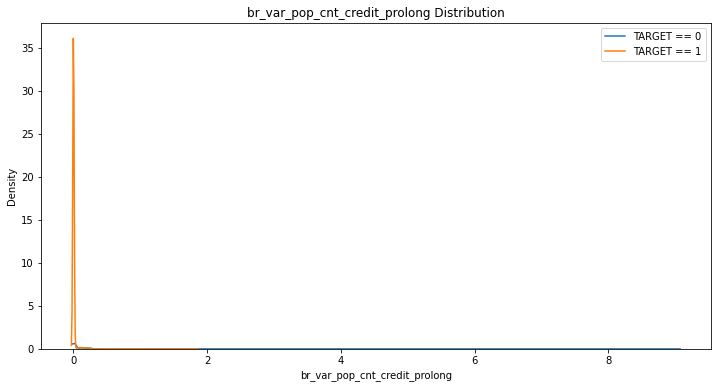

In [245]:
## 特徴量の分布
kde_target('br_var_pop_cnt_credit_prolong', app_train)

In [246]:
## Yao-Johnson変換
num_cols = ['br_var_pop_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [247]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_cnt_credit_prolong']].corr()

TARGET  br_var_pop_cnt_credit_prolong
TARGET                         1.000000                       0.010694
br_var_pop_cnt_credit_prolong  0.010694                       1.000000

The correlation between br_var_pop_cnt_credit_prolong and the TARGET is 0.0107
Median value for loan that was not repaid = -0.1616
Median value for loan that was repaid =     -0.1616


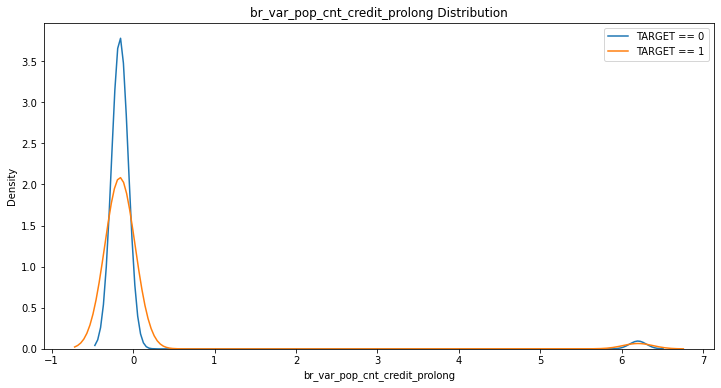

In [248]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_cnt_credit_prolong', app_train)

### br_var_samp_cnt_credit_prolong

In [249]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_cnt_credit_prolong']].corr()

TARGET  br_var_samp_cnt_credit_prolong
TARGET                          1.000000                        0.002207
br_var_samp_cnt_credit_prolong  0.002207                        1.000000

The correlation between br_var_samp_cnt_credit_prolong and the TARGET is 0.0022
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


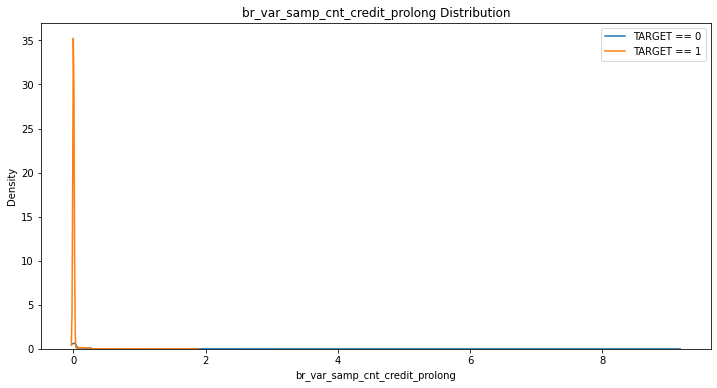

In [250]:
## 特徴量の分布
kde_target('br_var_samp_cnt_credit_prolong', app_train)

In [251]:
## Yao-Johnson変換
num_cols = ['br_var_samp_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [252]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_cnt_credit_prolong']].corr()

TARGET  br_var_samp_cnt_credit_prolong
TARGET                          1.000000                        0.010693
br_var_samp_cnt_credit_prolong  0.010693                        1.000000

The correlation between br_var_samp_cnt_credit_prolong and the TARGET is 0.0107
Median value for loan that was not repaid = -0.1616
Median value for loan that was repaid =     -0.1616


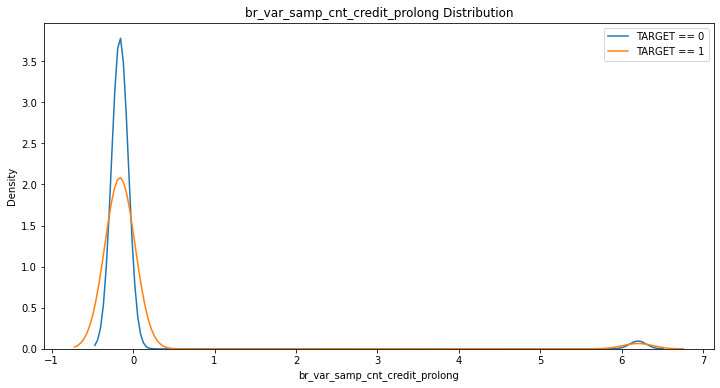

In [253]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_cnt_credit_prolong', app_train)

### br_variance_pop_cnt_credit_prolong

In [254]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_cnt_credit_prolong']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_cnt_credit_prolong  0.002124   

                                    br_variance_pop_cnt_credit_prolong  
TARGET                                                        0.002124  
br_variance_pop_cnt_credit_prolong                            1.000000

The correlation between br_variance_pop_cnt_credit_prolong and the TARGET is 0.0021
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


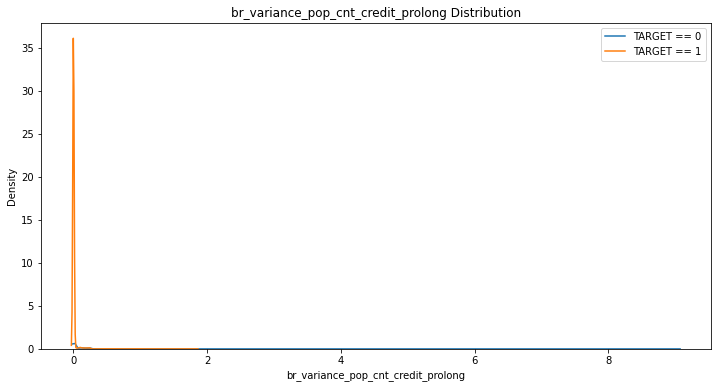

In [255]:
## 特徴量の分布
kde_target('br_variance_pop_cnt_credit_prolong', app_train)

In [256]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_cnt_credit_prolong']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_cnt_credit_prolong'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_cnt_credit_prolong'] = pt.transform(app_test[num_cols])

In [257]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_cnt_credit_prolong']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_cnt_credit_prolong  0.010694   

                                    br_variance_pop_cnt_credit_prolong  
TARGET                                                        0.010694  
br_variance_pop_cnt_credit_prolong                            1.000000

The correlation between br_variance_pop_cnt_credit_prolong and the TARGET is 0.0107
Median value for loan that was not repaid = -0.1616
Median value for loan that was repaid =     -0.1616


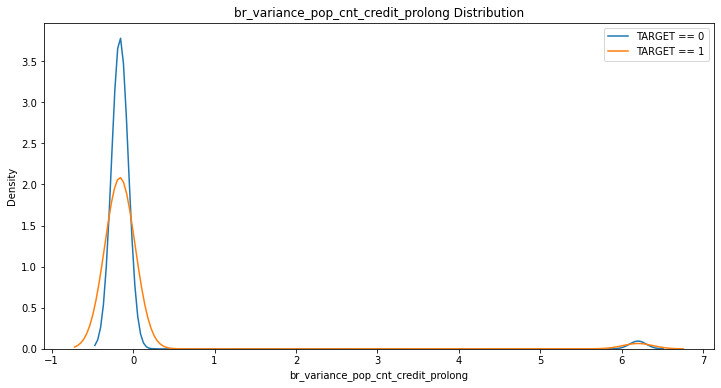

In [258]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_cnt_credit_prolong', app_train)

### br_min_amt_credit_sum

In [259]:
app_train[['TARGET', 'br_min_amt_credit_sum']].corr()

TARGET  br_min_amt_credit_sum
TARGET                 1.000000              -0.015568
br_min_amt_credit_sum -0.015568               1.000000

The correlation between br_min_amt_credit_sum and the TARGET is -0.0156
Median value for loan that was not repaid = 41247.0000
Median value for loan that was repaid =     45180.0000


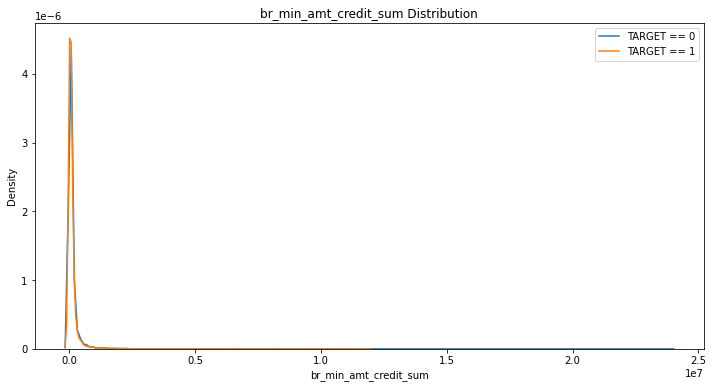

In [260]:
kde_target('br_min_amt_credit_sum', app_train)

In [261]:
## Yao-Johnson変換
num_cols = ['br_min_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_min_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [262]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum']].corr()

TARGET  br_min_amt_credit_sum
TARGET                 1.000000              -0.022564
br_min_amt_credit_sum -0.022564               1.000000

The correlation between br_min_amt_credit_sum and the TARGET is -0.0226
Median value for loan that was not repaid = 0.0523
Median value for loan that was repaid =     0.0940


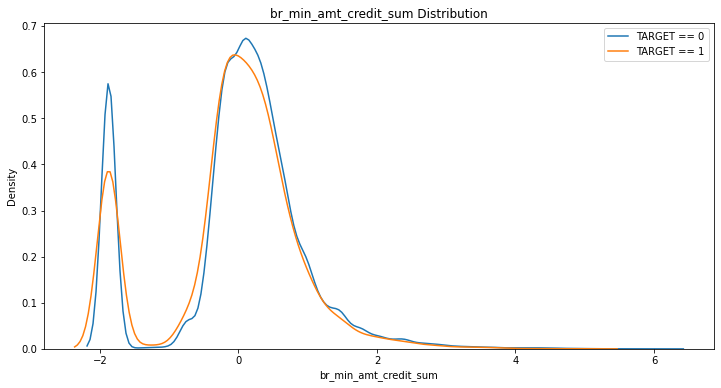

In [263]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_amt_credit_sum', app_train)

### br_max_amt_credit_sum

In [264]:
app_train[['TARGET', 'br_max_amt_credit_sum']].corr()

TARGET  br_max_amt_credit_sum
TARGET                 1.000000              -0.017089
br_max_amt_credit_sum -0.017089               1.000000

The correlation between br_max_amt_credit_sum and the TARGET is -0.0171
Median value for loan that was not repaid = 450000.0000
Median value for loan that was repaid =     450000.0000


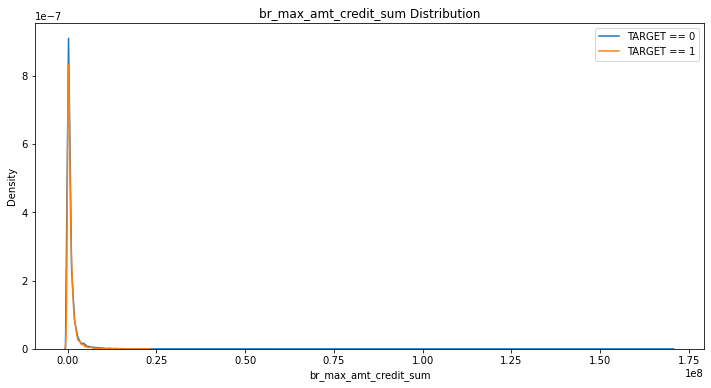

In [265]:
kde_target('br_max_amt_credit_sum', app_train)

In [266]:
## Yao-Johnson変換
num_cols = ['br_max_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_max_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [267]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum']].corr()

TARGET  br_max_amt_credit_sum
TARGET                 1.000000              -0.018184
br_max_amt_credit_sum -0.018184               1.000000

The correlation between br_max_amt_credit_sum and the TARGET is -0.0182
Median value for loan that was not repaid = -0.0629
Median value for loan that was repaid =     -0.0629


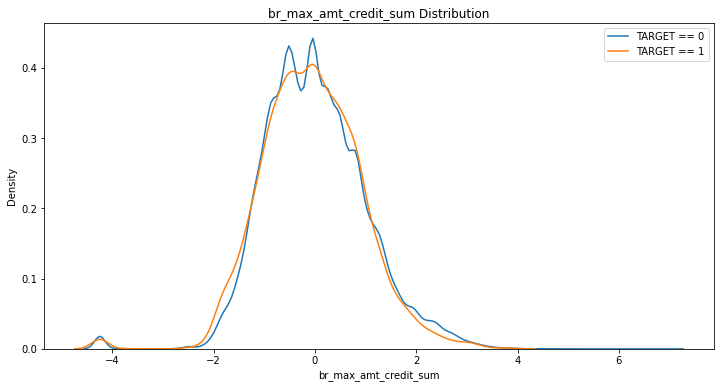

In [268]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_amt_credit_sum', app_train)

### br_sum_amt_credit_sum

In [269]:
app_train[['TARGET', 'br_sum_amt_credit_sum']].corr()

TARGET  br_sum_amt_credit_sum
TARGET                 1.000000              -0.022722
br_sum_amt_credit_sum -0.022722               1.000000

The correlation between br_sum_amt_credit_sum and the TARGET is -0.0227
Median value for loan that was not repaid = 10970700.5700
Median value for loan that was repaid =     13885776.5625


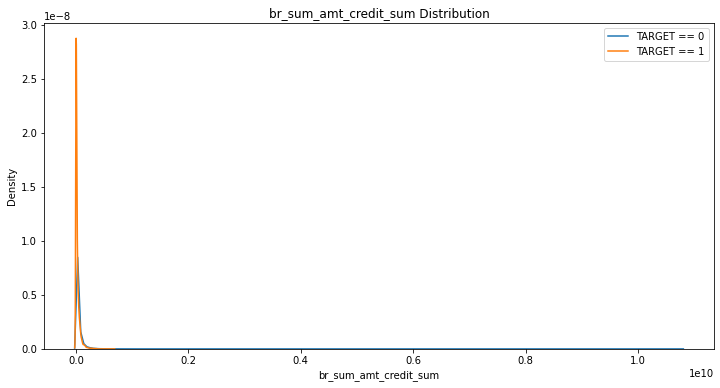

In [270]:
kde_target('br_sum_amt_credit_sum', app_train)

In [271]:
## Yao-Johnson変換
num_cols = ['br_sum_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [272]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum']].corr()

TARGET  br_sum_amt_credit_sum
TARGET                 1.000000              -0.041367
br_sum_amt_credit_sum -0.041367               1.000000

The correlation between br_sum_amt_credit_sum and the TARGET is -0.0414
Median value for loan that was not repaid = -0.1569
Median value for loan that was repaid =     -0.0072


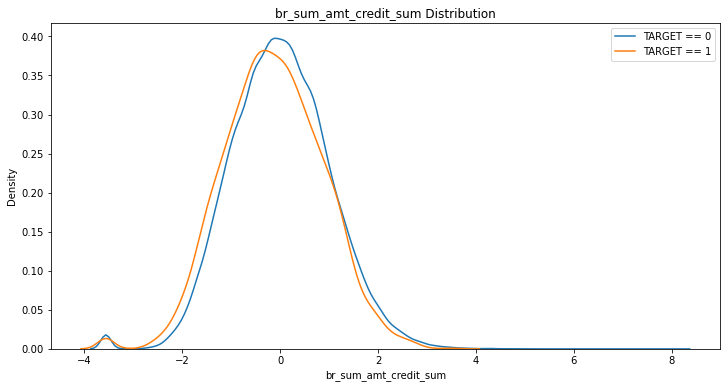

In [273]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_amt_credit_sum', app_train)

### br_avg_amt_credit_sum

In [274]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum']].corr()

TARGET  br_avg_amt_credit_sum
TARGET                 1.000000              -0.024453
br_avg_amt_credit_sum -0.024453               1.000000

The correlation between br_avg_amt_credit_sum and the TARGET is -0.0245
Median value for loan that was not repaid = 188596.1670
Median value for loan that was repaid =     205723.6006


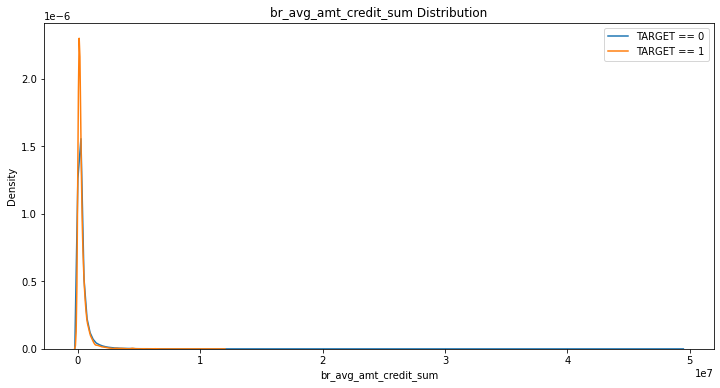

In [275]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum', app_train)

In [276]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [277]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum']].corr()

TARGET  br_avg_amt_credit_sum
TARGET                 1.000000              -0.028692
br_avg_amt_credit_sum -0.028692               1.000000

The correlation between br_avg_amt_credit_sum and the TARGET is -0.0287
Median value for loan that was not repaid = -0.1653
Median value for loan that was repaid =     -0.0916


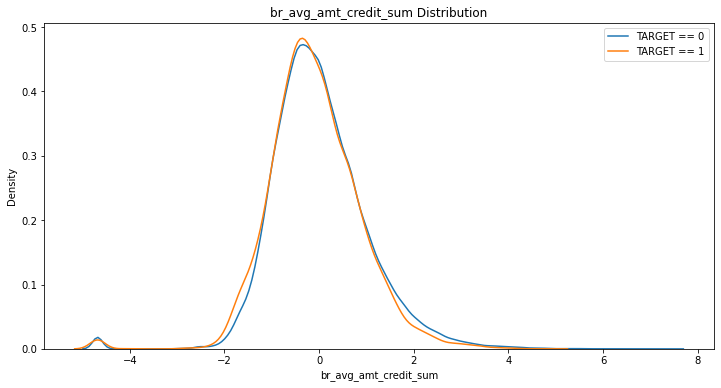

In [278]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_credit_sum', app_train)

### br_cnt_amt_credit_sum

In [279]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum']].corr()

TARGET  br_cnt_amt_credit_sum
TARGET                 1.000000              -0.024241
br_cnt_amt_credit_sum -0.024241               1.000000

The correlation between br_cnt_amt_credit_sum and the TARGET is -0.0242
Median value for loan that was not repaid = 55.0000
Median value for loan that was repaid =     63.0000


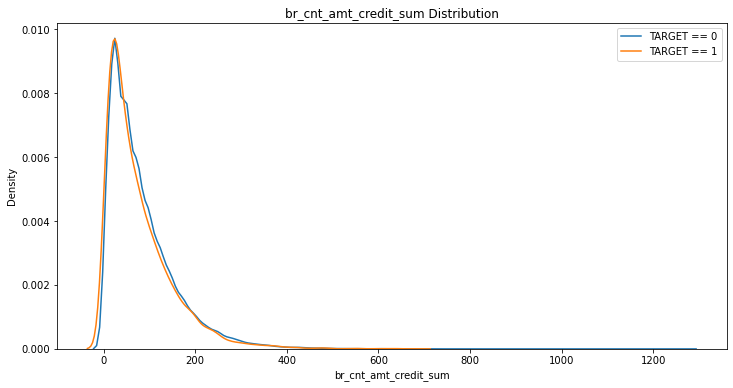

In [280]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum', app_train)

In [281]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [282]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum']].corr()

TARGET  br_cnt_amt_credit_sum
TARGET                 1.000000              -0.035764
br_cnt_amt_credit_sum -0.035764               1.000000

The correlation between br_cnt_amt_credit_sum and the TARGET is -0.0358
Median value for loan that was not repaid = -0.1168
Median value for loan that was repaid =     0.0267


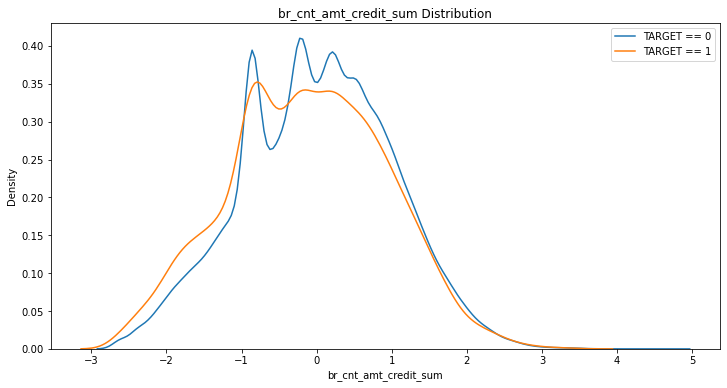

In [283]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum', app_train)

### br_stddev_amt_credit_sum

In [284]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum']].corr()

TARGET  br_stddev_amt_credit_sum
TARGET                    1.00000                  -0.01605
br_stddev_amt_credit_sum -0.01605                   1.00000

The correlation between br_stddev_amt_credit_sum and the TARGET is -0.0160
Median value for loan that was not repaid = 115081.6729
Median value for loan that was repaid =     118802.8709


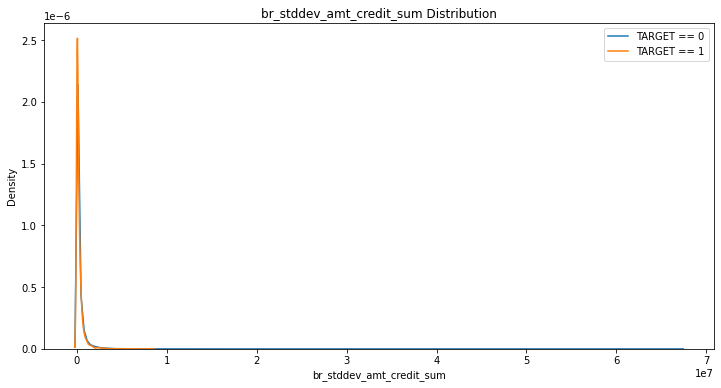

In [285]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum', app_train)

### br_stddev_pop_amt_credit_sum

In [286]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum']].corr()

TARGET  br_stddev_pop_amt_credit_sum
TARGET                        1.00000                      -0.01605
br_stddev_pop_amt_credit_sum -0.01605                       1.00000

The correlation between br_stddev_pop_amt_credit_sum and the TARGET is -0.0160
Median value for loan that was not repaid = 115081.6729
Median value for loan that was repaid =     118802.8709


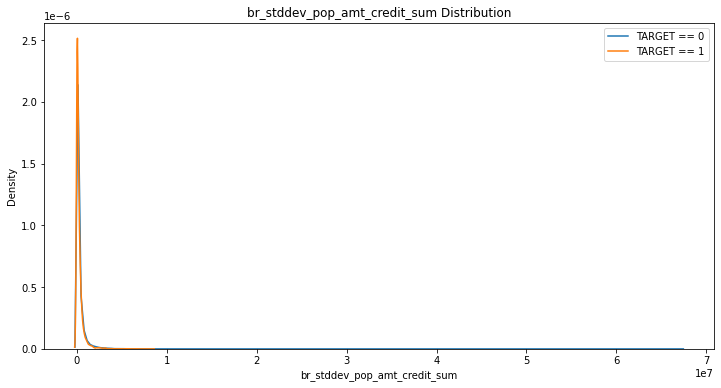

In [287]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum', app_train)

### br_var_pop_amt_credit_sum

In [288]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum']].corr()

TARGET  br_var_pop_amt_credit_sum
TARGET                     1.000000                  -0.003281
br_var_pop_amt_credit_sum -0.003281                   1.000000

The correlation between br_var_pop_amt_credit_sum and the TARGET is -0.0033
Median value for loan that was not repaid = 13243791474.0720
Median value for loan that was repaid =     14114122130.7509


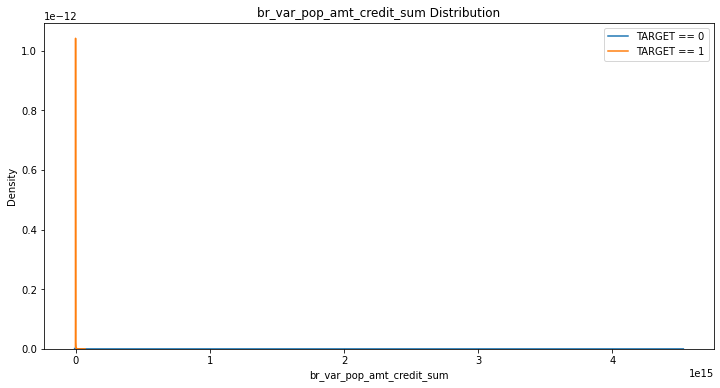

In [289]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum', app_train)

In [290]:
## Yao-Johnson変換
num_cols = ['br_var_pop_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [291]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum']].corr()

TARGET  br_var_pop_amt_credit_sum
TARGET                     1.000000                  -0.014224
br_var_pop_amt_credit_sum -0.014224                   1.000000

The correlation between br_var_pop_amt_credit_sum and the TARGET is -0.0142
Median value for loan that was not repaid = 0.1232
Median value for loan that was repaid =     0.1375


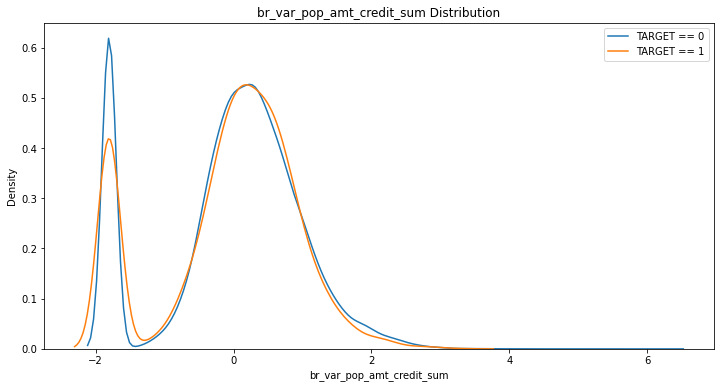

In [292]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_amt_credit_sum', app_train)

### br_var_samp_amt_credit_sum

In [293]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum']].corr()

TARGET  br_var_samp_amt_credit_sum
TARGET                      1.000000                   -0.003296
br_var_samp_amt_credit_sum -0.003296                    1.000000

The correlation between br_var_samp_amt_credit_sum and the TARGET is -0.0033
Median value for loan that was not repaid = 13496990774.6073
Median value for loan that was repaid =     14378410115.8489


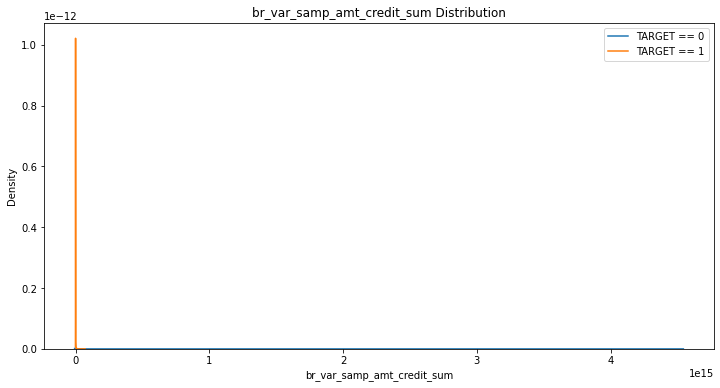

In [294]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum', app_train)

In [295]:
## Yao-Johnson変換
num_cols = ['br_var_samp_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [296]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum']].corr()

TARGET  br_var_samp_amt_credit_sum
TARGET                      1.000000                   -0.014042
br_var_samp_amt_credit_sum -0.014042                    1.000000

The correlation between br_var_samp_amt_credit_sum and the TARGET is -0.0140
Median value for loan that was not repaid = 0.1230
Median value for loan that was repaid =     0.1373


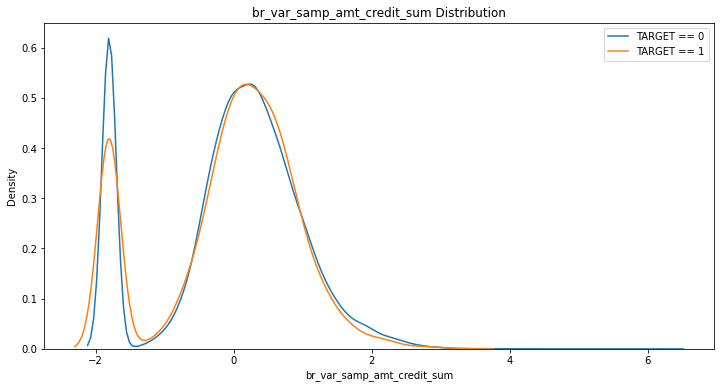

In [297]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_amt_credit_sum', app_train)

### br_variance_pop_amt_credit_sum

In [298]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum']].corr()

TARGET  br_variance_pop_amt_credit_sum
TARGET                          1.000000                       -0.003281
br_variance_pop_amt_credit_sum -0.003281                        1.000000

The correlation between br_variance_pop_amt_credit_sum and the TARGET is -0.0033
Median value for loan that was not repaid = 13243791474.0720
Median value for loan that was repaid =     14114122130.7509


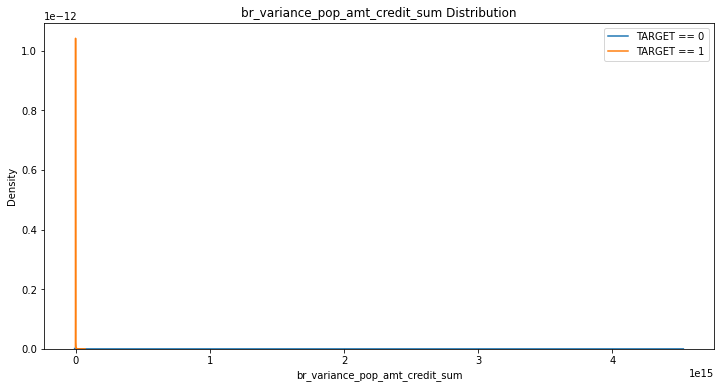

In [299]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum', app_train)

In [300]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_credit_sum']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_credit_sum'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_credit_sum'] = pt.transform(app_test[num_cols])

In [301]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum']].corr()

TARGET  br_variance_pop_amt_credit_sum
TARGET                          1.000000                       -0.014224
br_variance_pop_amt_credit_sum -0.014224                        1.000000

The correlation between br_variance_pop_amt_credit_sum and the TARGET is -0.0142
Median value for loan that was not repaid = 0.1232
Median value for loan that was repaid =     0.1375


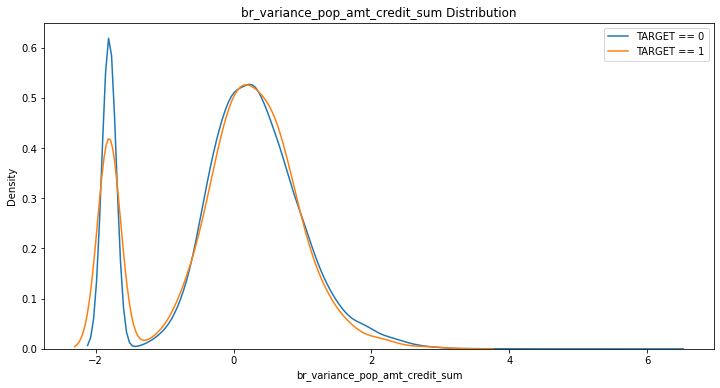

In [302]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_credit_sum', app_train)

### br_min_amt_credit_sum_debt

In [303]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_debt']].corr()

TARGET  br_min_amt_credit_sum_debt
TARGET                      1.000000                   -0.002451
br_min_amt_credit_sum_debt -0.002451                    1.000000

The correlation between br_min_amt_credit_sum_debt and the TARGET is -0.0025
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


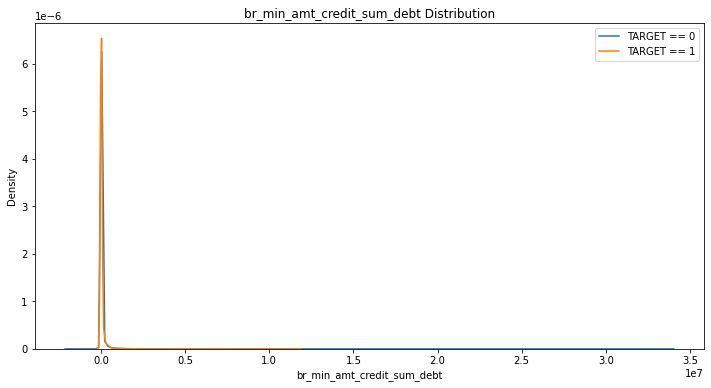

In [304]:
## 特徴量の分布
kde_target('br_min_amt_credit_sum_debt', app_train)

In [305]:
## Yao-Johnson変換
num_cols = ['br_min_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_min_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [306]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_debt']].corr()

TARGET  br_min_amt_credit_sum_debt
TARGET                      1.000000                    0.001088
br_min_amt_credit_sum_debt  0.001088                    1.000000

The correlation between br_min_amt_credit_sum_debt and the TARGET is 0.0011
Median value for loan that was not repaid = -0.1071
Median value for loan that was repaid =     -0.1071


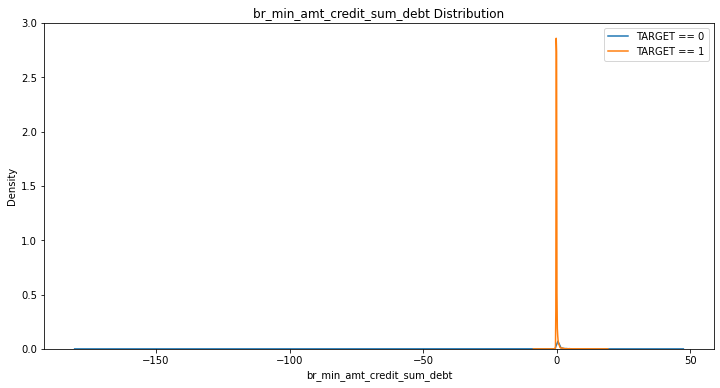

In [307]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_amt_credit_sum_debt', app_train)

In [308]:
app_train.drop(['br_min_amt_credit_sum_debt'], axis=1, inplace=True)
app_test.drop(['br_min_amt_credit_sum_debt'], axis=1, inplace=True)

### br_max_amt_credit_sum_debt

In [309]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_debt']].corr()

TARGET  br_max_amt_credit_sum_debt
TARGET                      1.000000                    0.001483
br_max_amt_credit_sum_debt  0.001483                    1.000000

The correlation between br_max_amt_credit_sum_debt and the TARGET is 0.0015
Median value for loan that was not repaid = 213130.4850
Median value for loan that was repaid =     150934.5000


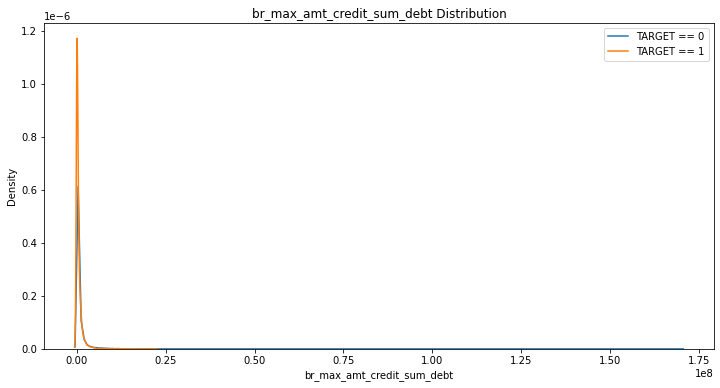

In [310]:
## 特徴量の分布
kde_target('br_max_amt_credit_sum_debt', app_train)

In [311]:
## Yao-Johnson変換
num_cols = ['br_max_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_max_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [312]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_debt']].corr()

TARGET  br_max_amt_credit_sum_debt
TARGET                      1.000000                    0.016293
br_max_amt_credit_sum_debt  0.016293                    1.000000

The correlation between br_max_amt_credit_sum_debt and the TARGET is 0.0163
Median value for loan that was not repaid = -0.1257
Median value for loan that was repaid =     -0.2325


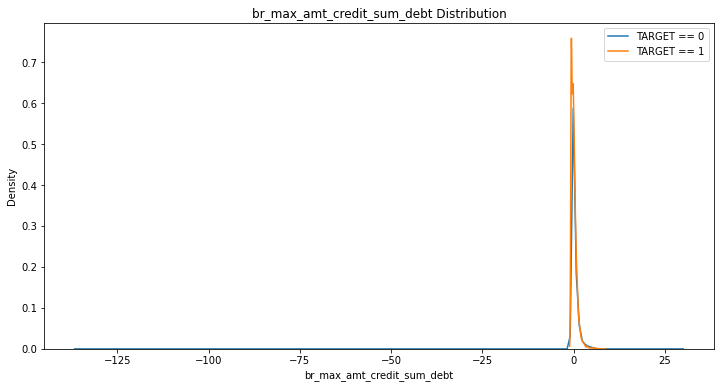

In [313]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_amt_credit_sum_debt', app_train)

### br_sum_amt_credit_sum_debt

In [314]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_debt']].corr()

TARGET  br_sum_amt_credit_sum_debt
TARGET                      1.000000                   -0.003126
br_sum_amt_credit_sum_debt -0.003126                    1.000000

The correlation between br_sum_amt_credit_sum_debt and the TARGET is -0.0031
Median value for loan that was not repaid = 2581827.7050
Median value for loan that was repaid =     1814415.5925


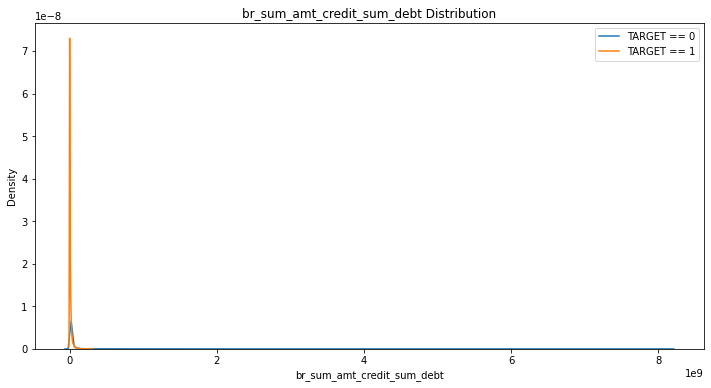

In [315]:
## 特徴量の分布
kde_target('br_sum_amt_credit_sum_debt', app_train)

In [316]:
## Yao-Johnson変換
num_cols = ['br_sum_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [317]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_debt']].corr()

TARGET  br_sum_amt_credit_sum_debt
TARGET                      1.000000                   -0.000146
br_sum_amt_credit_sum_debt -0.000146                    1.000000

The correlation between br_sum_amt_credit_sum_debt and the TARGET is -0.0001
Median value for loan that was not repaid = -0.2151
Median value for loan that was repaid =     -0.2506


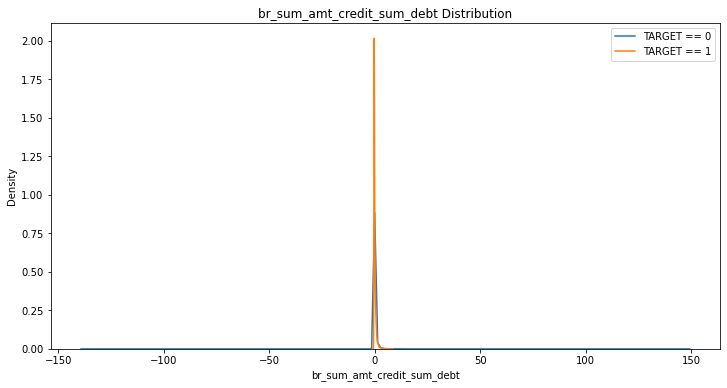

In [318]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_amt_credit_sum_debt', app_train)

In [319]:
app_train.drop(['br_sum_amt_credit_sum_debt'], axis=1, inplace=True)
app_test.drop(['br_sum_amt_credit_sum_debt'], axis=1, inplace=True)

### br_avg_amt_credit_sum_debt

In [320]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_debt']].corr()

TARGET  br_avg_amt_credit_sum_debt
TARGET                      1.000000                   -0.001805
br_avg_amt_credit_sum_debt -0.001805                    1.000000

The correlation between br_avg_amt_credit_sum_debt and the TARGET is -0.0018
Median value for loan that was not repaid = 59774.3931
Median value for loan that was repaid =     37875.3462


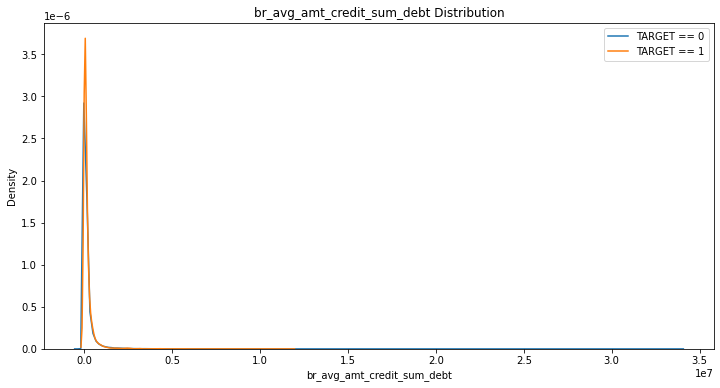

In [321]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum_debt', app_train)

In [322]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [323]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_debt']].corr()

TARGET  br_avg_amt_credit_sum_debt
TARGET                      1.000000                    0.005713
br_avg_amt_credit_sum_debt  0.005713                    1.000000

The correlation between br_avg_amt_credit_sum_debt and the TARGET is 0.0057
Median value for loan that was not repaid = -0.1740
Median value for loan that was repaid =     -0.2463


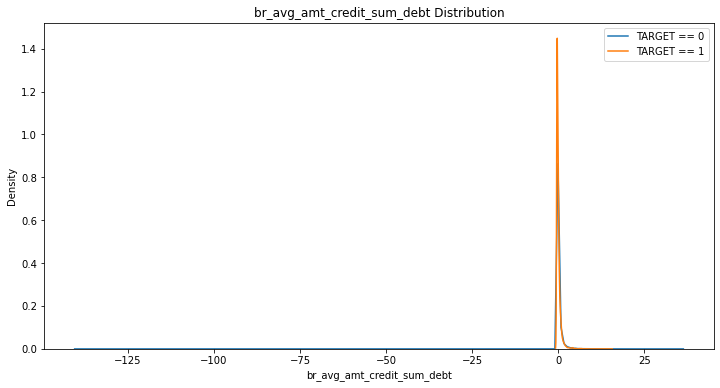

In [324]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_credit_sum_debt', app_train)

In [325]:
app_train.drop(['br_avg_amt_credit_sum_debt'], axis=1, inplace=True)
app_test.drop(['br_avg_amt_credit_sum_debt'], axis=1, inplace=True)

### br_cnt_amt_credit_sum_debt

In [326]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_debt']].corr()

TARGET  br_cnt_amt_credit_sum_debt
TARGET                      1.000000                   -0.020236
br_cnt_amt_credit_sum_debt -0.020236                    1.000000

The correlation between br_cnt_amt_credit_sum_debt and the TARGET is -0.0202
Median value for loan that was not repaid = 48.0000
Median value for loan that was repaid =     51.0000


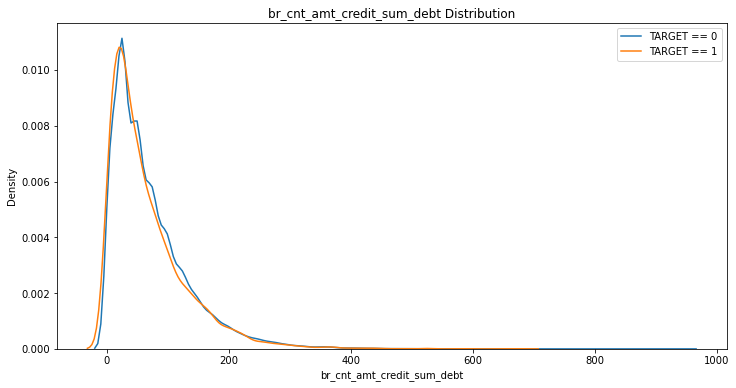

In [327]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum_debt', app_train)

In [328]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [329]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_debt']].corr()

TARGET  br_cnt_amt_credit_sum_debt
TARGET                      1.00000                    -0.02651
br_cnt_amt_credit_sum_debt -0.02651                     1.00000

The correlation between br_cnt_amt_credit_sum_debt and the TARGET is -0.0265
Median value for loan that was not repaid = -0.0811
Median value for loan that was repaid =     -0.0221


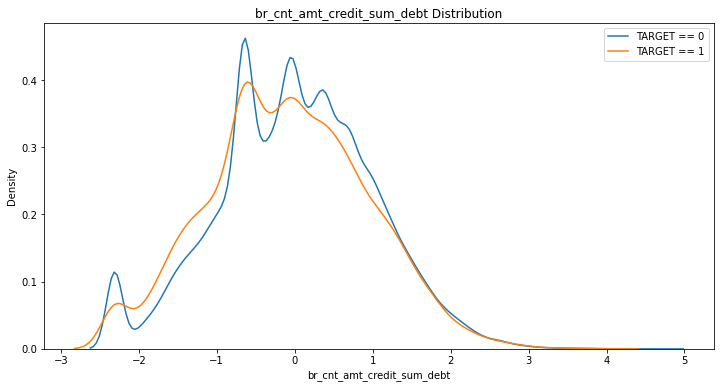

In [330]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum_debt', app_train)

### br_stddev_amt_credit_sum_debt

In [331]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_debt']].corr()

TARGET  br_stddev_amt_credit_sum_debt
TARGET                         1.000000                      -0.000296
br_stddev_amt_credit_sum_debt -0.000296                       1.000000

The correlation between br_stddev_amt_credit_sum_debt and the TARGET is -0.0003
Median value for loan that was not repaid = 57373.3289
Median value for loan that was repaid =     37771.0471


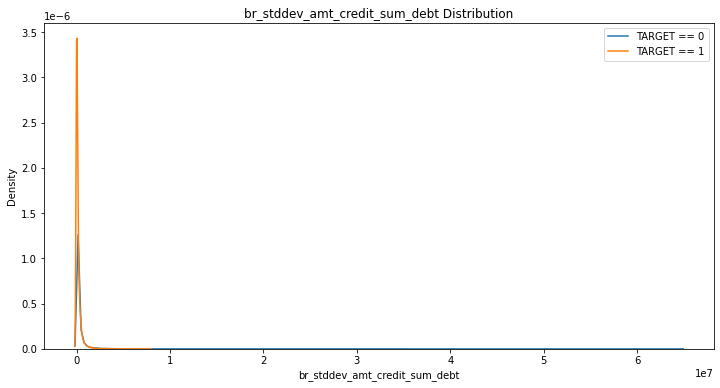

In [332]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum_debt', app_train)

In [333]:
## Yao-Johnson変換
num_cols = ['br_stddev_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_stddev_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [334]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_debt']].corr()

TARGET  br_stddev_amt_credit_sum_debt
TARGET                         1.000000                       0.031053
br_stddev_amt_credit_sum_debt  0.031053                       1.000000

The correlation between br_stddev_amt_credit_sum_debt and the TARGET is 0.0311
Median value for loan that was not repaid = 0.5265
Median value for loan that was repaid =     0.4213


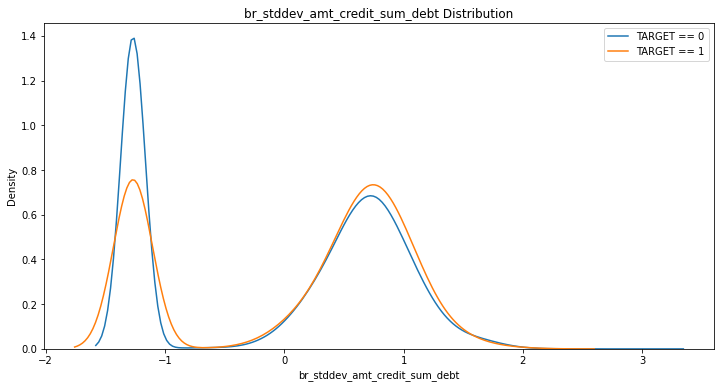

In [335]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_amt_credit_sum_debt', app_train)

### br_stddev_pop_amt_credit_sum_debt

In [336]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_debt']].corr()

TARGET  br_stddev_pop_amt_credit_sum_debt
TARGET                             1.000000                          -0.000296
br_stddev_pop_amt_credit_sum_debt -0.000296                           1.000000

The correlation between br_stddev_pop_amt_credit_sum_debt and the TARGET is -0.0003
Median value for loan that was not repaid = 57373.3289
Median value for loan that was repaid =     37771.0471


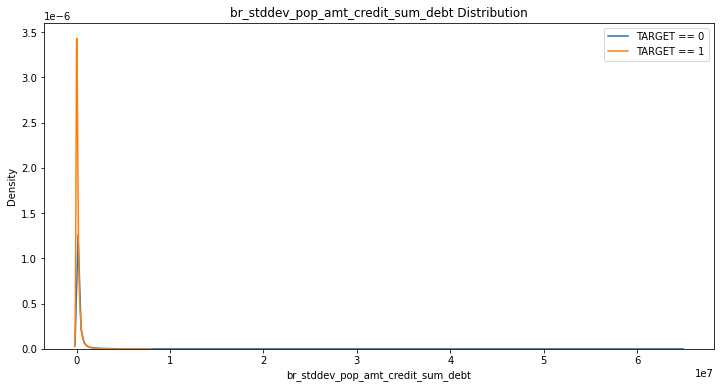

In [337]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_debt', app_train)

In [338]:
## Yao-Johnson変換
num_cols = ['br_sum_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_amt_credit_max_overdue'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_credit_max_overdue'] = pt.transform(app_test[num_cols])

In [339]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_max_overdue']].corr()

TARGET  br_sum_amt_credit_max_overdue
TARGET                         1.000000                       0.043629
br_sum_amt_credit_max_overdue  0.043629                       1.000000

The correlation between br_sum_amt_credit_max_overdue and the TARGET is 0.0436
Median value for loan that was not repaid = -0.5068
Median value for loan that was repaid =     -0.5068


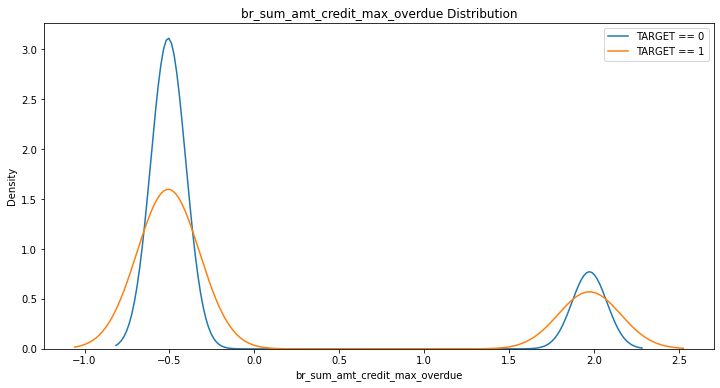

In [340]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_amt_credit_max_overdue', app_train)

### br_var_pop_amt_credit_sum_debt

In [341]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_debt']].corr()

TARGET  br_var_pop_amt_credit_sum_debt
TARGET                          1.000000                       -0.001926
br_var_pop_amt_credit_sum_debt -0.001926                        1.000000

The correlation between br_var_pop_amt_credit_sum_debt and the TARGET is -0.0019
Median value for loan that was not repaid = 3291699179.2368
Median value for loan that was repaid =     1426652000.4110


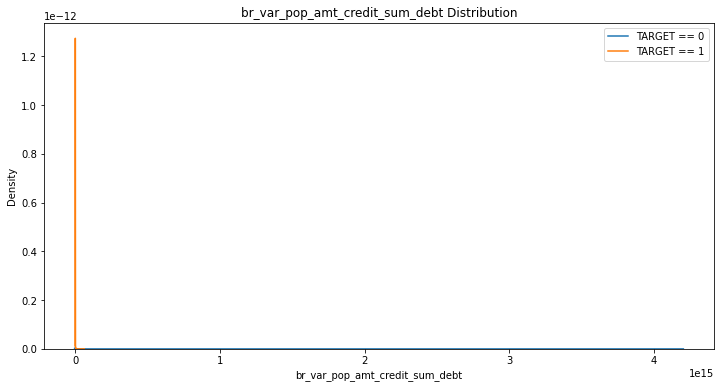

In [342]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum_debt', app_train)

In [343]:
## Yao-Johnson変換
num_cols = ['br_var_pop_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [344]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_debt']].corr()

TARGET  br_var_pop_amt_credit_sum_debt
TARGET                          1.00000                         0.03105
br_var_pop_amt_credit_sum_debt  0.03105                         1.00000

The correlation between br_var_pop_amt_credit_sum_debt and the TARGET is 0.0311
Median value for loan that was not repaid = 0.5266
Median value for loan that was repaid =     0.4213


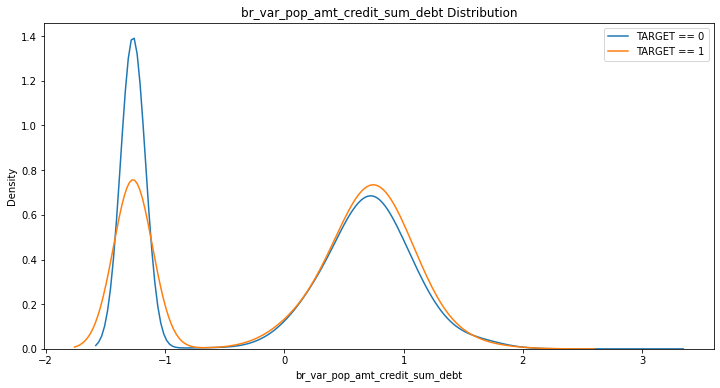

In [345]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_amt_credit_sum_debt', app_train)

### br_var_samp_amt_credit_sum_debt

In [346]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_debt']].corr()

TARGET  br_var_samp_amt_credit_sum_debt
TARGET                           1.000000                        -0.001934
br_var_samp_amt_credit_sum_debt -0.001934                         1.000000

The correlation between br_var_samp_amt_credit_sum_debt and the TARGET is -0.0019
Median value for loan that was not repaid = 3408582441.9143
Median value for loan that was repaid =     1464727931.8342


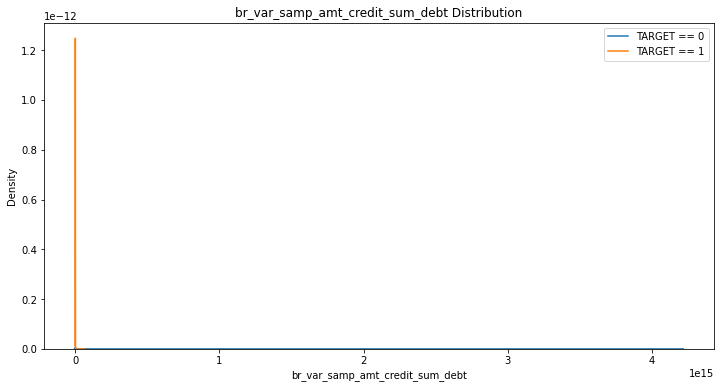

In [347]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum_debt', app_train)

In [348]:
## Yao-Johnson変換
num_cols = ['br_var_samp_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [349]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_debt']].corr()

TARGET  br_var_samp_amt_credit_sum_debt
TARGET                           1.000000                         0.031158
br_var_samp_amt_credit_sum_debt  0.031158                         1.000000

The correlation between br_var_samp_amt_credit_sum_debt and the TARGET is 0.0312
Median value for loan that was not repaid = 0.5283
Median value for loan that was repaid =     0.4219


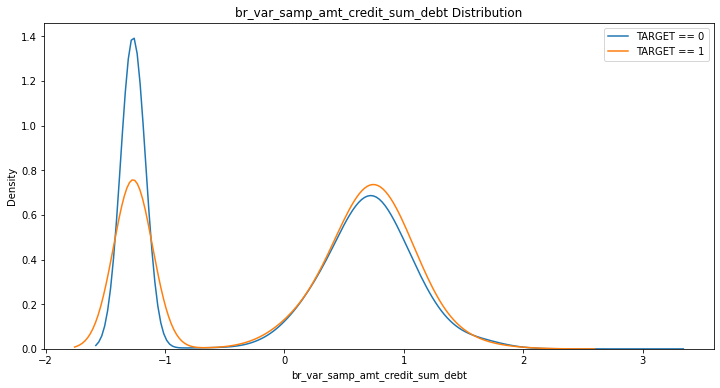

In [350]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_amt_credit_sum_debt', app_train)

### br_variance_pop_amt_credit_sum_debt

In [351]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_debt']].corr()

TARGET  \
TARGET                               1.000000   
br_variance_pop_amt_credit_sum_debt -0.001926   

                                     br_variance_pop_amt_credit_sum_debt  
TARGET                                                         -0.001926  
br_variance_pop_amt_credit_sum_debt                             1.000000

The correlation between br_variance_pop_amt_credit_sum_debt and the TARGET is -0.0019
Median value for loan that was not repaid = 3291699179.2368
Median value for loan that was repaid =     1426652000.4110


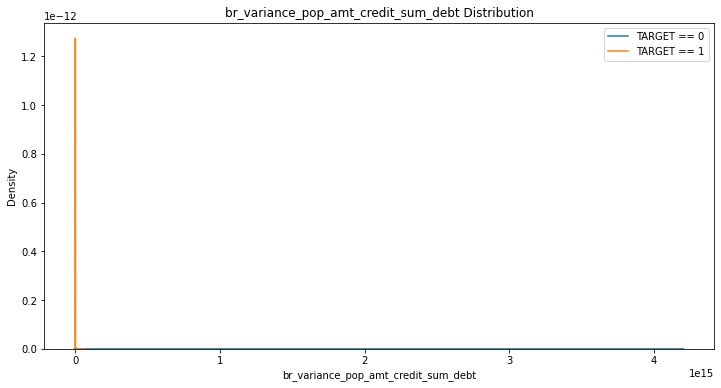

In [352]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_debt', app_train)

In [353]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_credit_sum_debt']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_credit_sum_debt'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_credit_sum_debt'] = pt.transform(app_test[num_cols])

In [354]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_debt']].corr()

TARGET  \
TARGET                               1.00000   
br_variance_pop_amt_credit_sum_debt  0.03105   

                                     br_variance_pop_amt_credit_sum_debt  
TARGET                                                           0.03105  
br_variance_pop_amt_credit_sum_debt                              1.00000

The correlation between br_variance_pop_amt_credit_sum_debt and the TARGET is 0.0311
Median value for loan that was not repaid = 0.5266
Median value for loan that was repaid =     0.4213


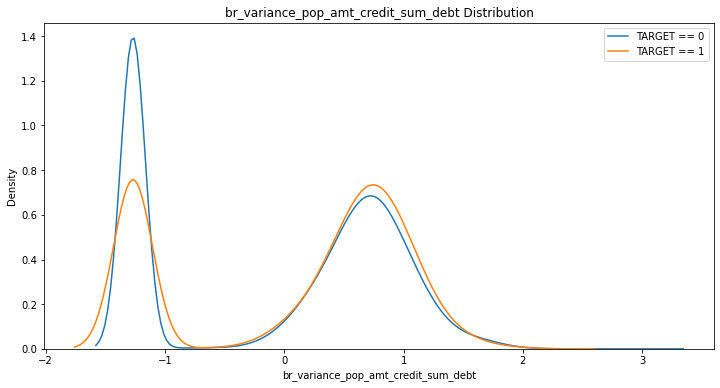

In [355]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_debt', app_train)

### br_min_amt_credit_sum_limit

In [356]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_limit']].corr()

TARGET  br_min_amt_credit_sum_limit
TARGET                       1.000000                    -0.003997
br_min_amt_credit_sum_limit -0.003997                     1.000000

The correlation between br_min_amt_credit_sum_limit and the TARGET is -0.0040
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


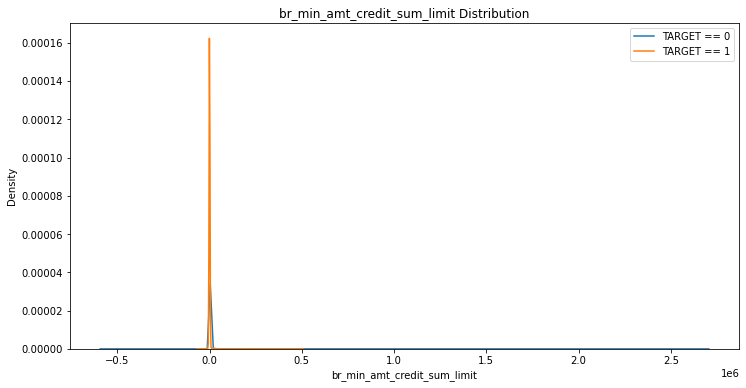

In [357]:
## 特徴量の分布
kde_target('br_min_amt_credit_sum_limit', app_train)

In [358]:
## Yao-Johnson変換
num_cols = ['br_min_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_min_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [359]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_limit']].corr()

TARGET  br_min_amt_credit_sum_limit
TARGET                       1.000000                    -0.002124
br_min_amt_credit_sum_limit -0.002124                     1.000000

The correlation between br_min_amt_credit_sum_limit and the TARGET is -0.0021
Median value for loan that was not repaid = -0.0422
Median value for loan that was repaid =     -0.0422


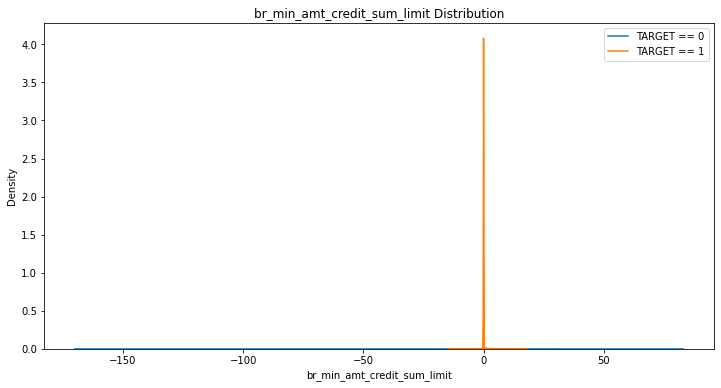

In [360]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_amt_credit_sum_limit', app_train)

In [361]:
app_train.drop(['br_min_amt_credit_sum_limit'], axis=1, inplace=True)
app_test.drop(['br_min_amt_credit_sum_limit'], axis=1, inplace=True)

### br_max_amt_credit_sum_limit

In [362]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_limit']].corr()

TARGET  br_max_amt_credit_sum_limit
TARGET                       1.000000                    -0.012056
br_max_amt_credit_sum_limit -0.012056                     1.000000

The correlation between br_max_amt_credit_sum_limit and the TARGET is -0.0121
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


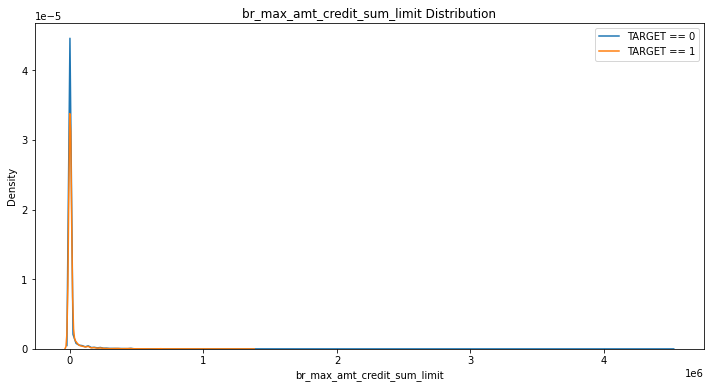

In [363]:
## 特徴量の分布
kde_target('br_max_amt_credit_sum_limit', app_train)

In [364]:
## Yao-Johnson変換
#num_cols = ['br_max_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_max_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
#app_test['br_max_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [365]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_max_amt_credit_sum_limit']].corr()

In [366]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_max_amt_credit_sum_limit', app_train)

### br_sum_amt_credit_sum_limit

In [367]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_limit']].corr()

TARGET  br_sum_amt_credit_sum_limit
TARGET                       1.000000                    -0.014251
br_sum_amt_credit_sum_limit -0.014251                     1.000000

The correlation between br_sum_amt_credit_sum_limit and the TARGET is -0.0143
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


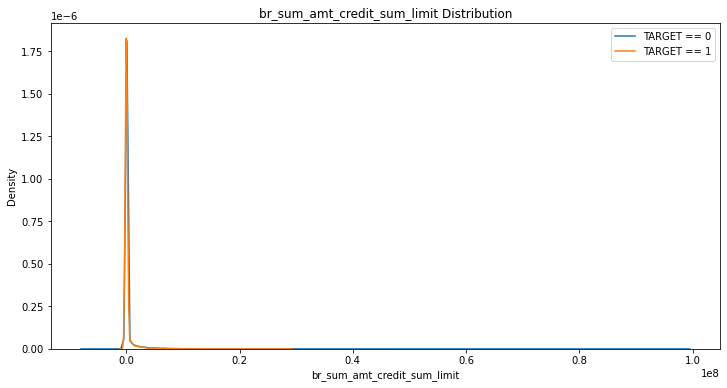

In [368]:
## 特徴量の分布
kde_target('br_sum_amt_credit_sum_limit', app_train)

In [369]:
## Yao-Johnson変換
#num_cols = ['br_sum_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_sum_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
#app_test['br_sum_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [370]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_sum_amt_credit_sum_limit']].corr()

In [371]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_sum_amt_credit_sum_limit', app_train)

### br_avg_amt_credit_sum_limit

In [372]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_limit']].corr()

TARGET  br_avg_amt_credit_sum_limit
TARGET                       1.000000                    -0.011128
br_avg_amt_credit_sum_limit -0.011128                     1.000000

The correlation between br_avg_amt_credit_sum_limit and the TARGET is -0.0111
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


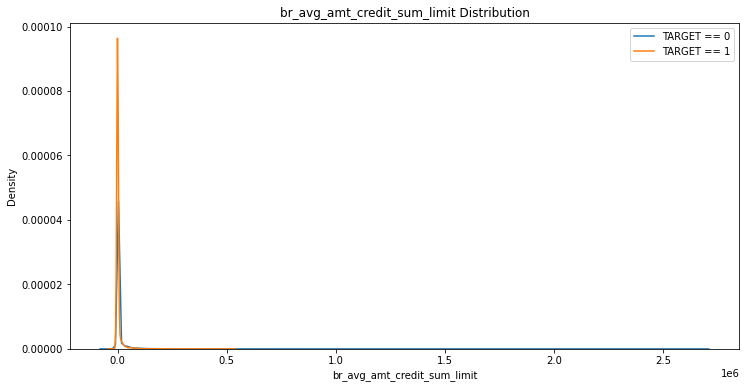

In [373]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum_limit', app_train)

In [374]:
## Yao-Johnson変換
#num_cols = ['br_avg_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
#app_train['br_avg_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
#app_test['br_avg_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [375]:
## Yao-Johnson変換後の目的変数との相関
#app_train[['TARGET', 'br_avg_amt_credit_sum_limit']].corr()

In [376]:
## Yao-Johnson変換後の特徴量の分布
#kde_target('br_avg_amt_credit_sum_limit', app_train)

### br_cnt_amt_credit_sum_limit

In [377]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_limit']].corr()

TARGET  br_cnt_amt_credit_sum_limit
TARGET                       1.000000                    -0.019026
br_cnt_amt_credit_sum_limit -0.019026                     1.000000

The correlation between br_cnt_amt_credit_sum_limit and the TARGET is -0.0190
Median value for loan that was not repaid = 33.0000
Median value for loan that was repaid =     38.0000


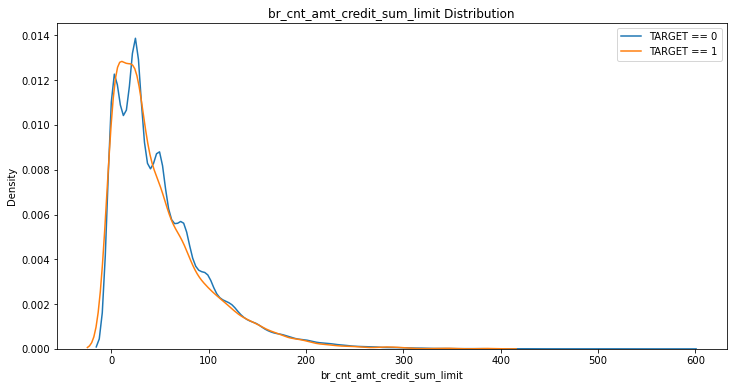

In [378]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum_limit', app_train)

In [379]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [380]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_limit']].corr()

TARGET  br_cnt_amt_credit_sum_limit
TARGET                       1.000000                    -0.021901
br_cnt_amt_credit_sum_limit -0.021901                     1.000000

The correlation between br_cnt_amt_credit_sum_limit and the TARGET is -0.0219
Median value for loan that was not repaid = -0.0846
Median value for loan that was repaid =     0.0366


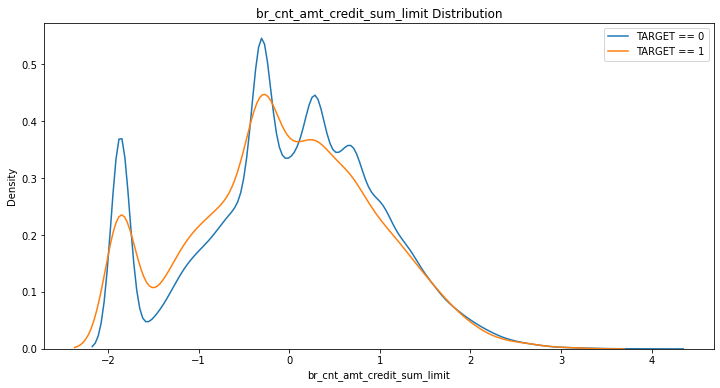

In [381]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum_limit', app_train)

### br_stddev_amt_credit_sum_limit

In [382]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_limit']].corr()

TARGET  br_stddev_amt_credit_sum_limit
TARGET                          1.000000                       -0.011591
br_stddev_amt_credit_sum_limit -0.011591                        1.000000

The correlation between br_stddev_amt_credit_sum_limit and the TARGET is -0.0116
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


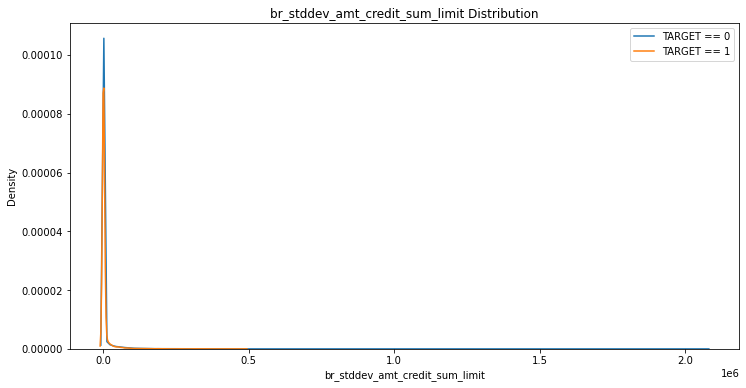

In [383]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum_limit', app_train)

In [384]:
## Yao-Johnson変換
num_cols = ['br_stddev_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_stddev_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [385]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_limit']].corr()

TARGET  br_stddev_amt_credit_sum_limit
TARGET                          1.000000                        0.037039
br_stddev_amt_credit_sum_limit  0.037039                        1.000000

The correlation between br_stddev_amt_credit_sum_limit and the TARGET is 0.0370
Median value for loan that was not repaid = -0.4291
Median value for loan that was repaid =     -0.4291


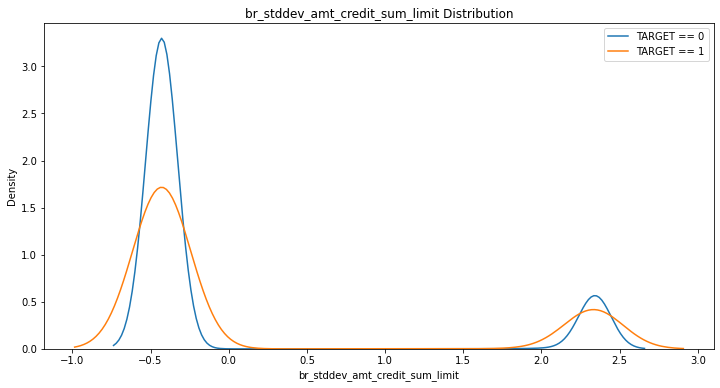

In [386]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_amt_credit_sum_limit', app_train)

### br_stddev_pop_amt_credit_sum_limit

In [387]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_limit']].corr()

TARGET  \
TARGET                              1.000000   
br_stddev_pop_amt_credit_sum_limit -0.011591   

                                    br_stddev_pop_amt_credit_sum_limit  
TARGET                                                       -0.011591  
br_stddev_pop_amt_credit_sum_limit                            1.000000

The correlation between br_stddev_pop_amt_credit_sum_limit and the TARGET is -0.0116
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


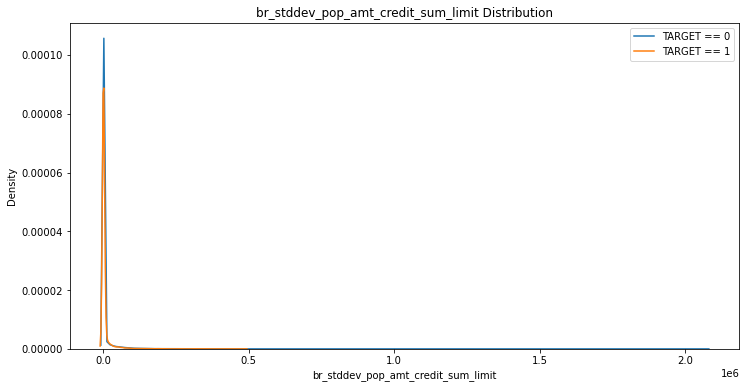

In [388]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_limit', app_train)

In [389]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [390]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_limit']].corr()

TARGET  \
TARGET                              1.000000   
br_stddev_pop_amt_credit_sum_limit  0.037039   

                                    br_stddev_pop_amt_credit_sum_limit  
TARGET                                                        0.037039  
br_stddev_pop_amt_credit_sum_limit                            1.000000

The correlation between br_stddev_pop_amt_credit_sum_limit and the TARGET is 0.0370
Median value for loan that was not repaid = -0.4291
Median value for loan that was repaid =     -0.4291


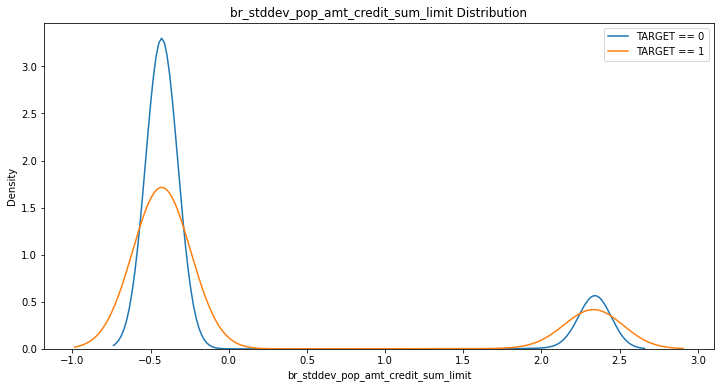

In [391]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_limit', app_train)

### br_var_pop_amt_credit_sum_limit

In [392]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_limit']].corr()

TARGET  br_var_pop_amt_credit_sum_limit
TARGET                           1.000000                        -0.005146
br_var_pop_amt_credit_sum_limit -0.005146                         1.000000

The correlation between br_var_pop_amt_credit_sum_limit and the TARGET is -0.0051
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


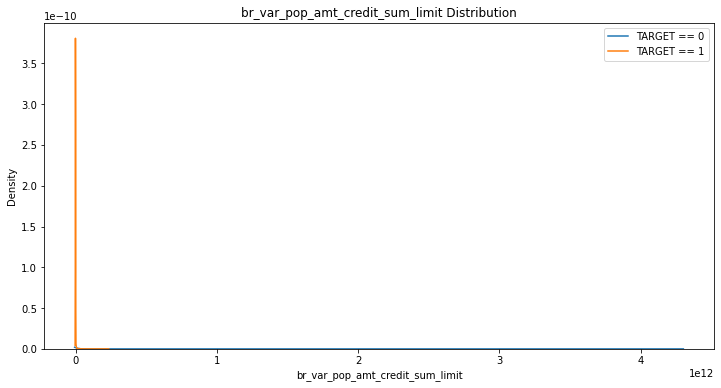

In [393]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum_limit', app_train)

In [394]:
## Yao-Johnson変換
num_cols = ['br_var_pop_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [395]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_limit']].corr()

TARGET  br_var_pop_amt_credit_sum_limit
TARGET                           1.000000                         0.036956
br_var_pop_amt_credit_sum_limit  0.036956                         1.000000

The correlation between br_var_pop_amt_credit_sum_limit and the TARGET is 0.0370
Median value for loan that was not repaid = -0.4288
Median value for loan that was repaid =     -0.4288


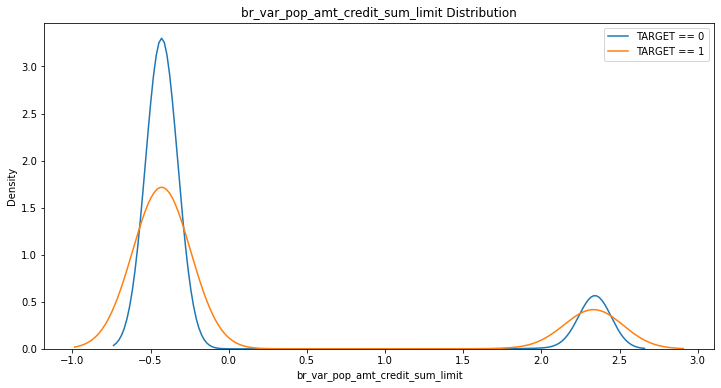

In [396]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_amt_credit_sum_limit', app_train)

### br_var_samp_amt_credit_sum_limit

In [397]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_limit']].corr()

TARGET  br_var_samp_amt_credit_sum_limit
TARGET                            1.000000                         -0.005109
br_var_samp_amt_credit_sum_limit -0.005109                          1.000000

The correlation between br_var_samp_amt_credit_sum_limit and the TARGET is -0.0051
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


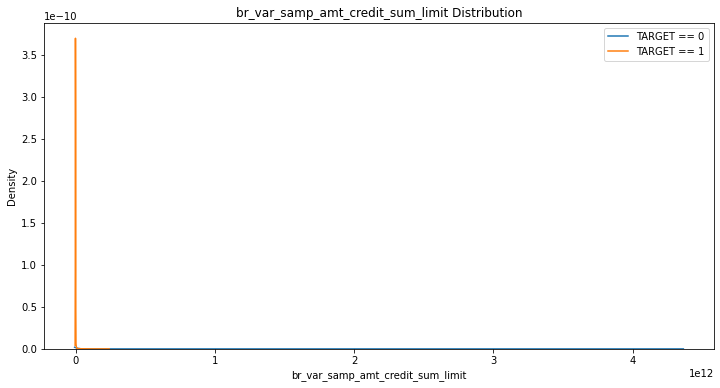

In [398]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum_limit', app_train)

In [399]:
## Yao-Johnson変換
num_cols = ['br_var_samp_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [400]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_limit']].corr()

TARGET  br_var_samp_amt_credit_sum_limit
TARGET                            1.000000                          0.036962
br_var_samp_amt_credit_sum_limit  0.036962                          1.000000

The correlation between br_var_samp_amt_credit_sum_limit and the TARGET is 0.0370
Median value for loan that was not repaid = -0.4289
Median value for loan that was repaid =     -0.4289


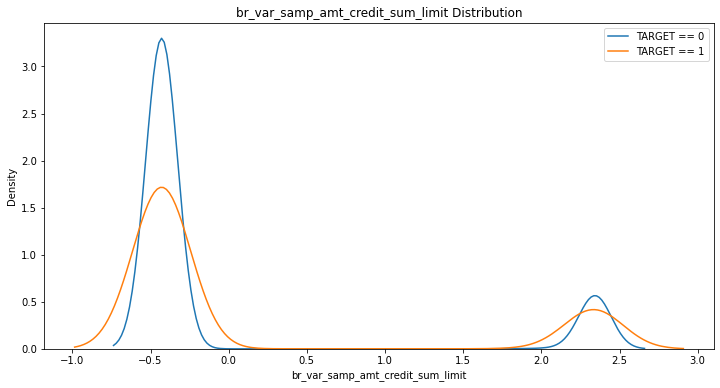

In [401]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_amt_credit_sum_limit', app_train)

### br_variance_pop_amt_credit_sum_limit

In [402]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_limit']].corr()

TARGET  \
TARGET                                1.000000   
br_variance_pop_amt_credit_sum_limit -0.005146   

                                      br_variance_pop_amt_credit_sum_limit  
TARGET                                                           -0.005146  
br_variance_pop_amt_credit_sum_limit                              1.000000

The correlation between br_variance_pop_amt_credit_sum_limit and the TARGET is -0.0051
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


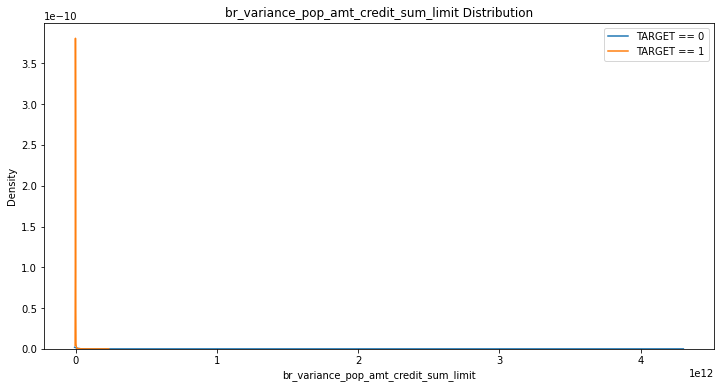

In [403]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_limit', app_train)

In [404]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_credit_sum_limit']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_credit_sum_limit'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_credit_sum_limit'] = pt.transform(app_test[num_cols])

In [405]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_limit']].corr()

TARGET  \
TARGET                                1.000000   
br_variance_pop_amt_credit_sum_limit  0.036956   

                                      br_variance_pop_amt_credit_sum_limit  
TARGET                                                            0.036956  
br_variance_pop_amt_credit_sum_limit                              1.000000

The correlation between br_variance_pop_amt_credit_sum_limit and the TARGET is 0.0370
Median value for loan that was not repaid = -0.4288
Median value for loan that was repaid =     -0.4288


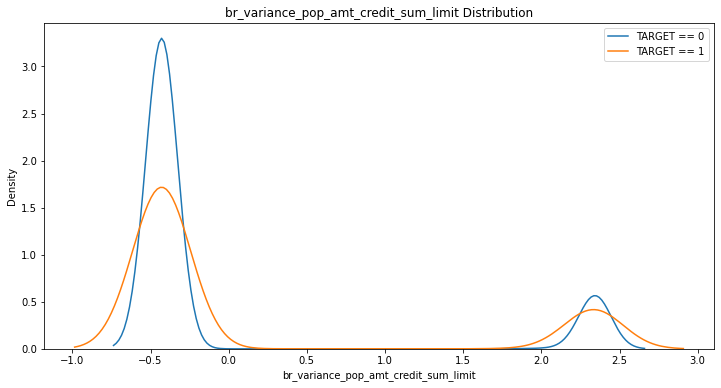

In [406]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_limit', app_train)

### br_min_amt_credit_sum_overdue

In [407]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_overdue']].corr()

TARGET  br_min_amt_credit_sum_overdue
TARGET                         1.000000                      -0.000761
br_min_amt_credit_sum_overdue -0.000761                       1.000000

The correlation between br_min_amt_credit_sum_overdue and the TARGET is -0.0008
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


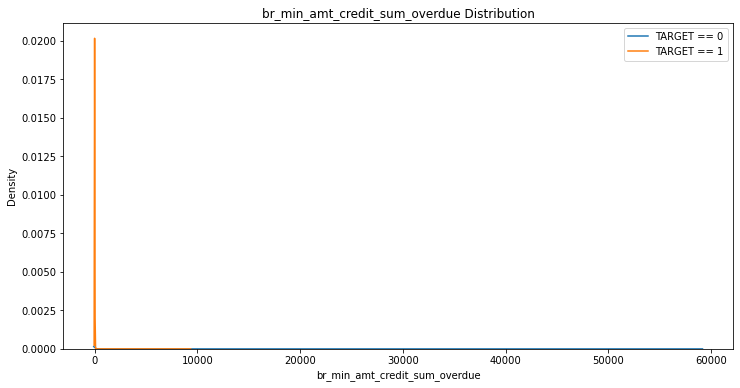

In [408]:
## 特徴量の分布
kde_target('br_min_amt_credit_sum_overdue', app_train)

In [409]:
## Yao-Johnson変換
num_cols = ['br_min_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_min_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [410]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_amt_credit_sum_overdue']].corr()

TARGET  br_min_amt_credit_sum_overdue
TARGET                         1.000000                       0.007988
br_min_amt_credit_sum_overdue  0.007988                       1.000000

The correlation between br_min_amt_credit_sum_overdue and the TARGET is 0.0080
Median value for loan that was not repaid = -0.0257
Median value for loan that was repaid =     -0.0257


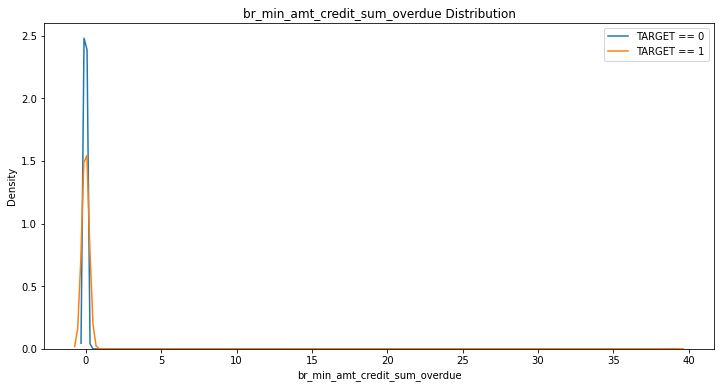

In [411]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_amt_credit_sum_overdue', app_train)

In [412]:
app_train.drop(['br_min_amt_credit_sum_overdue'], axis=1, inplace=True)
app_test.drop(['br_min_amt_credit_sum_overdue'], axis=1, inplace=True)

### br_max_amt_credit_sum_overdue

In [413]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_overdue']].corr()

TARGET  br_max_amt_credit_sum_overdue
TARGET                         1.000000                       0.018143
br_max_amt_credit_sum_overdue  0.018143                       1.000000

The correlation between br_max_amt_credit_sum_overdue and the TARGET is 0.0181
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


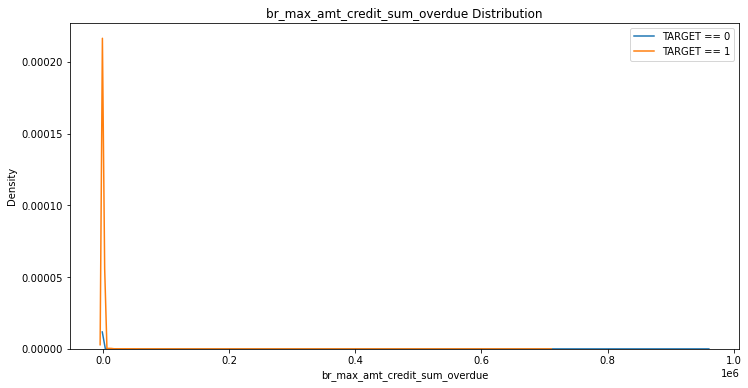

In [414]:
## 特徴量の分布
kde_target('br_max_amt_credit_sum_overdue', app_train)

In [415]:
## Yao-Johnson変換
num_cols = ['br_max_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_max_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [416]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_amt_credit_sum_overdue']].corr()

TARGET  br_max_amt_credit_sum_overdue
TARGET                         1.000000                       0.033727
br_max_amt_credit_sum_overdue  0.033727                       1.000000

The correlation between br_max_amt_credit_sum_overdue and the TARGET is 0.0337
Median value for loan that was not repaid = -0.1104
Median value for loan that was repaid =     -0.1104


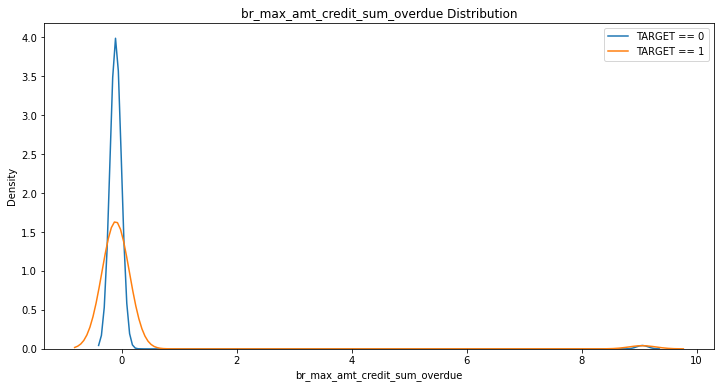

In [417]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_amt_credit_sum_overdue', app_train)

### br_sum_amt_credit_sum_overdue

In [418]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_overdue']].corr()

TARGET  br_sum_amt_credit_sum_overdue
TARGET                         1.000000                       0.006905
br_sum_amt_credit_sum_overdue  0.006905                       1.000000

The correlation between br_sum_amt_credit_sum_overdue and the TARGET is 0.0069
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


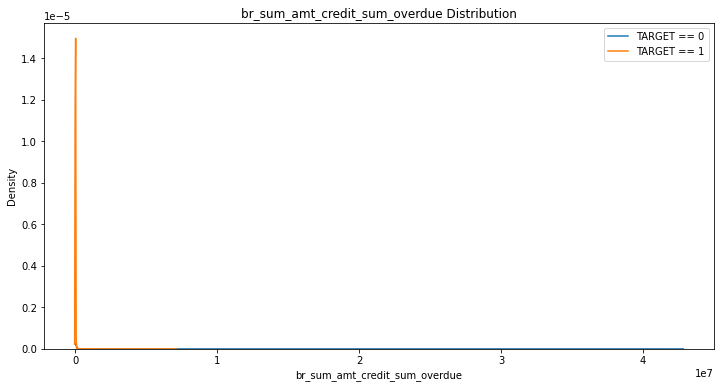

In [419]:
## 特徴量の分布
kde_target('br_sum_amt_credit_sum_overdue', app_train)

In [420]:
## Yao-Johnson変換
num_cols = ['br_sum_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [421]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_sum_overdue']].corr()

TARGET  br_sum_amt_credit_sum_overdue
TARGET                         1.000000                       0.033725
br_sum_amt_credit_sum_overdue  0.033725                       1.000000

The correlation between br_sum_amt_credit_sum_overdue and the TARGET is 0.0337
Median value for loan that was not repaid = -0.1104
Median value for loan that was repaid =     -0.1104


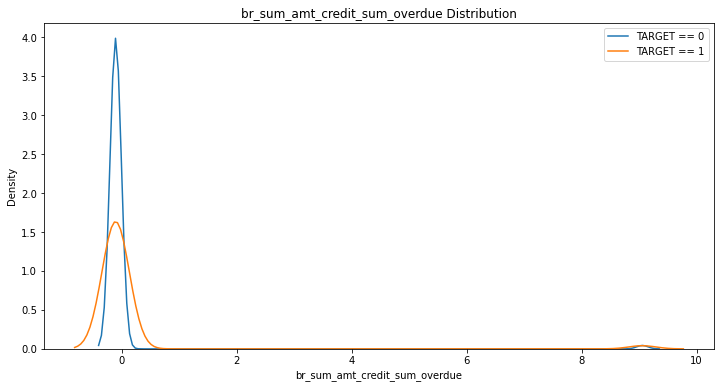

In [422]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_amt_credit_sum_overdue', app_train)

### br_avg_amt_credit_sum_overdue

In [423]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_overdue']].corr()

TARGET  br_avg_amt_credit_sum_overdue
TARGET                         1.000000                       0.019531
br_avg_amt_credit_sum_overdue  0.019531                       1.000000

The correlation between br_avg_amt_credit_sum_overdue and the TARGET is 0.0195
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


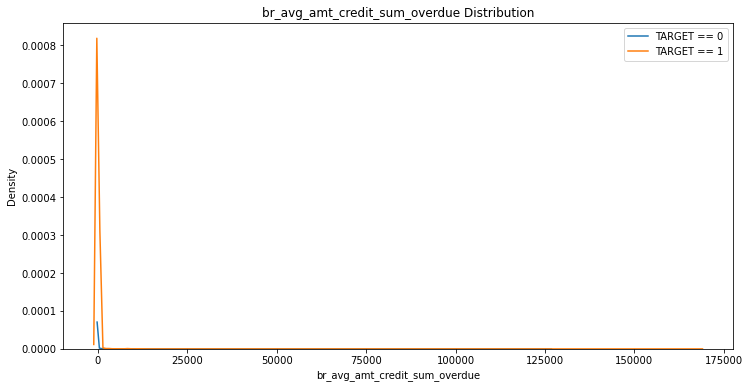

In [424]:
## 特徴量の分布
kde_target('br_avg_amt_credit_sum_overdue', app_train)

In [425]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [426]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_credit_sum_overdue']].corr()

TARGET  br_avg_amt_credit_sum_overdue
TARGET                         1.000000                       0.033816
br_avg_amt_credit_sum_overdue  0.033816                       1.000000

The correlation between br_avg_amt_credit_sum_overdue and the TARGET is 0.0338
Median value for loan that was not repaid = -0.1104
Median value for loan that was repaid =     -0.1104


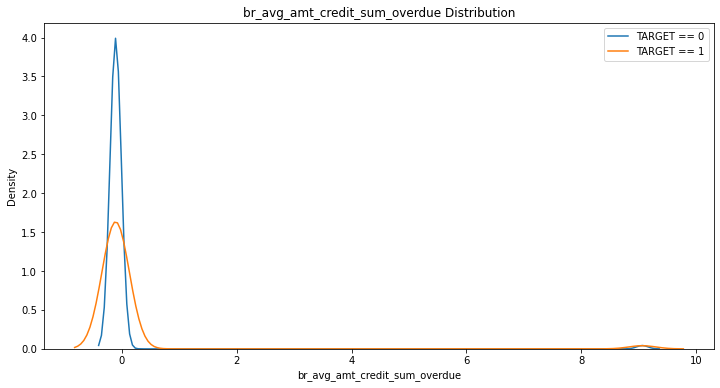

In [427]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_credit_sum_overdue', app_train)

### br_cnt_amt_credit_sum_overdue

In [428]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_overdue']].corr()

TARGET  br_cnt_amt_credit_sum_overdue
TARGET                         1.000000                      -0.024241
br_cnt_amt_credit_sum_overdue -0.024241                       1.000000

The correlation between br_cnt_amt_credit_sum_overdue and the TARGET is -0.0242
Median value for loan that was not repaid = 55.0000
Median value for loan that was repaid =     63.0000


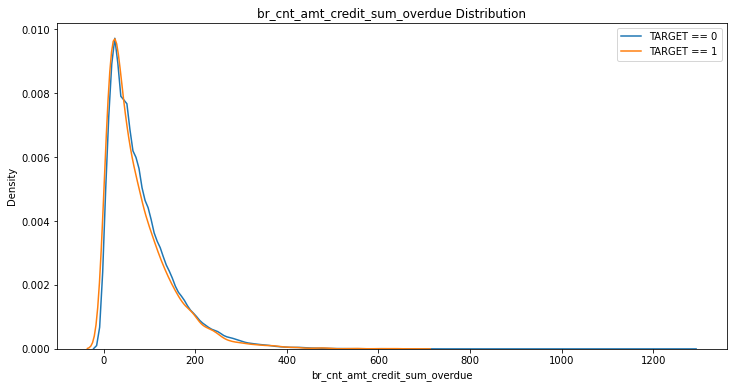

In [429]:
## 特徴量の分布
kde_target('br_cnt_amt_credit_sum_overdue', app_train)

In [430]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [431]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_credit_sum_overdue']].corr()

TARGET  br_cnt_amt_credit_sum_overdue
TARGET                         1.000000                      -0.035764
br_cnt_amt_credit_sum_overdue -0.035764                       1.000000

The correlation between br_cnt_amt_credit_sum_overdue and the TARGET is -0.0358
Median value for loan that was not repaid = -0.1168
Median value for loan that was repaid =     0.0267


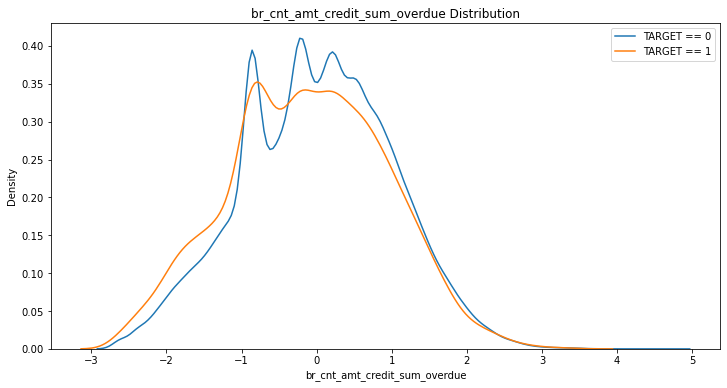

In [432]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_credit_sum_overdue', app_train)

### br_stddev_amt_credit_sum_overdue

In [433]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_overdue']].corr()

TARGET  br_stddev_amt_credit_sum_overdue
TARGET                            1.000000                          0.019463
br_stddev_amt_credit_sum_overdue  0.019463                          1.000000

The correlation between br_stddev_amt_credit_sum_overdue and the TARGET is 0.0195
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


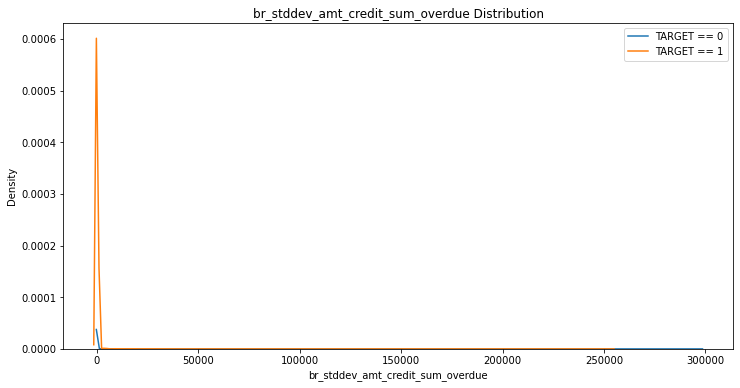

In [434]:
## 特徴量の分布
kde_target('br_stddev_amt_credit_sum_overdue', app_train)

In [435]:
## Yao-Johnson変換
num_cols = ['br_stddev_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [436]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_amt_credit_sum_overdue']].corr()

TARGET  br_stddev_amt_credit_sum_overdue
TARGET                            1.000000                          0.032756
br_stddev_amt_credit_sum_overdue  0.032756                          1.000000

The correlation between br_stddev_amt_credit_sum_overdue and the TARGET is 0.0328
Median value for loan that was not repaid = -0.1073
Median value for loan that was repaid =     -0.1073


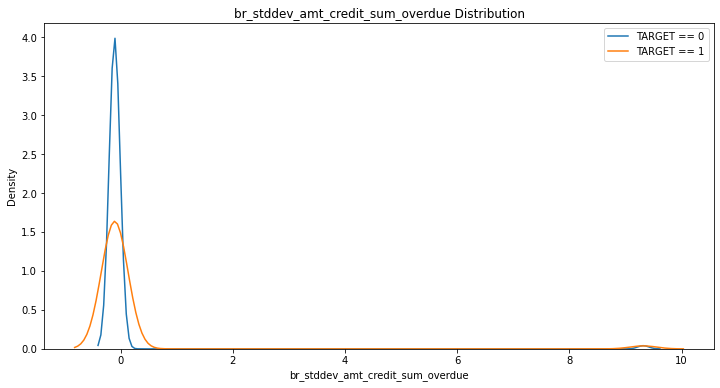

In [437]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_amt_credit_sum_overdue', app_train)

### br_stddev_pop_amt_credit_sum_overdue

In [438]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                                1.000000   
br_stddev_pop_amt_credit_sum_overdue  0.019463   

                                      br_stddev_pop_amt_credit_sum_overdue  
TARGET                                                            0.019463  
br_stddev_pop_amt_credit_sum_overdue                              1.000000

The correlation between br_stddev_pop_amt_credit_sum_overdue and the TARGET is 0.0195
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


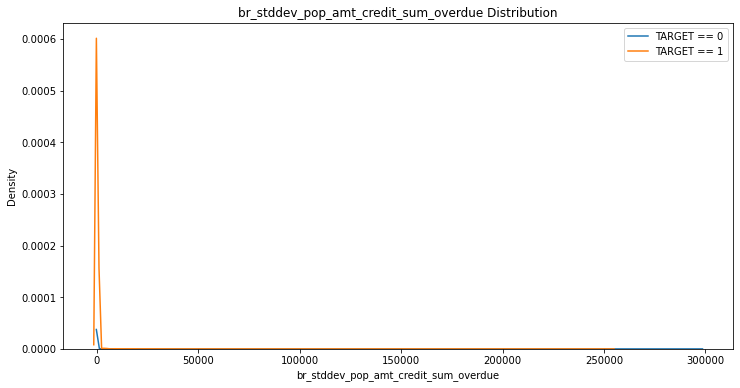

In [439]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_overdue', app_train)

In [440]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [441]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                                1.000000   
br_stddev_pop_amt_credit_sum_overdue  0.032756   

                                      br_stddev_pop_amt_credit_sum_overdue  
TARGET                                                            0.032756  
br_stddev_pop_amt_credit_sum_overdue                              1.000000

The correlation between br_stddev_pop_amt_credit_sum_overdue and the TARGET is 0.0328
Median value for loan that was not repaid = -0.1073
Median value for loan that was repaid =     -0.1073


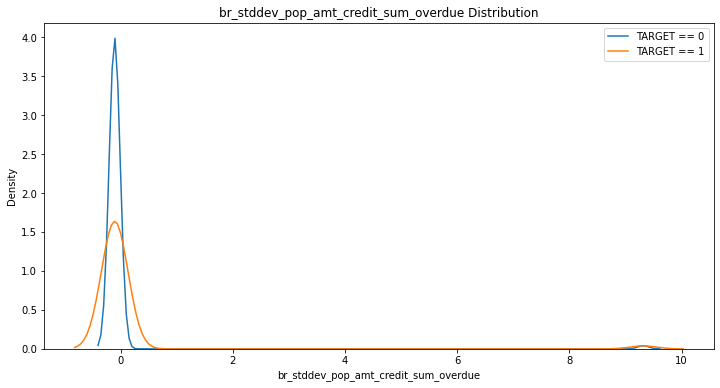

In [442]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_amt_credit_sum_overdue', app_train)

### br_var_pop_amt_credit_sum_overdue

In [443]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_overdue']].corr()

TARGET  br_var_pop_amt_credit_sum_overdue
TARGET                             1.000000                           0.006835
br_var_pop_amt_credit_sum_overdue  0.006835                           1.000000

The correlation between br_var_pop_amt_credit_sum_overdue and the TARGET is 0.0068
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


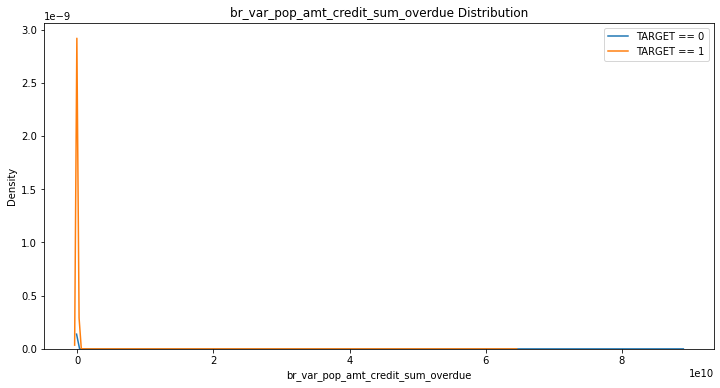

In [444]:
## 特徴量の分布
kde_target('br_var_pop_amt_credit_sum_overdue', app_train)

In [445]:
## Yao-Johnson変換
num_cols = ['br_var_pop_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [446]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_credit_sum_overdue']].corr()

TARGET  br_var_pop_amt_credit_sum_overdue
TARGET                             1.000000                           0.032851
br_var_pop_amt_credit_sum_overdue  0.032851                           1.000000

The correlation between br_var_pop_amt_credit_sum_overdue and the TARGET is 0.0329
Median value for loan that was not repaid = -0.1073
Median value for loan that was repaid =     -0.1073


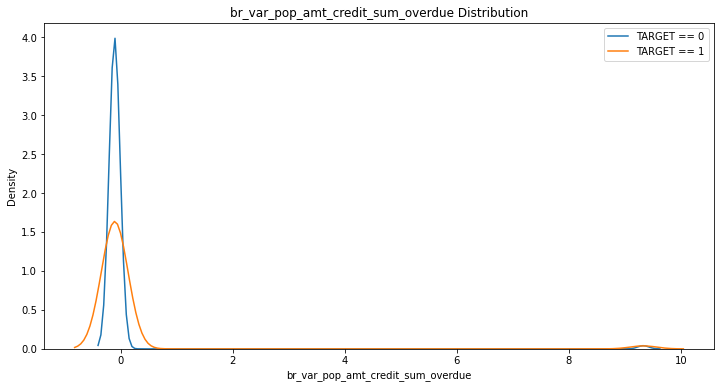

In [447]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_amt_credit_sum_overdue', app_train)

### br_var_samp_amt_credit_sum_overdue

In [448]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_var_samp_amt_credit_sum_overdue  0.006937   

                                    br_var_samp_amt_credit_sum_overdue  
TARGET                                                        0.006937  
br_var_samp_amt_credit_sum_overdue                            1.000000

The correlation between br_var_samp_amt_credit_sum_overdue and the TARGET is 0.0069
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


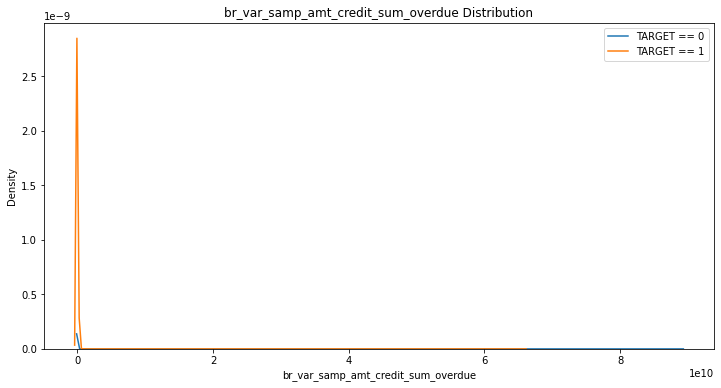

In [449]:
## 特徴量の分布
kde_target('br_var_samp_amt_credit_sum_overdue', app_train)

In [450]:
## Yao-Johnson変換
num_cols = ['br_var_samp_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [451]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                              1.000000   
br_var_samp_amt_credit_sum_overdue  0.032851   

                                    br_var_samp_amt_credit_sum_overdue  
TARGET                                                        0.032851  
br_var_samp_amt_credit_sum_overdue                            1.000000

The correlation between br_var_samp_amt_credit_sum_overdue and the TARGET is 0.0329
Median value for loan that was not repaid = -0.1073
Median value for loan that was repaid =     -0.1073


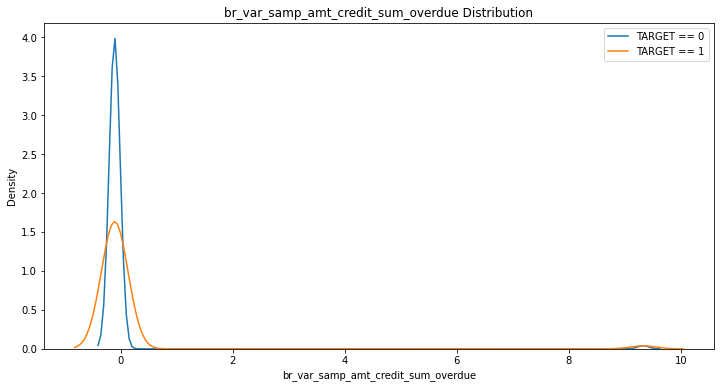

In [452]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_amt_credit_sum_overdue', app_train)

### br_variance_pop_amt_credit_sum_overdue

In [453]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                                  1.000000   
br_variance_pop_amt_credit_sum_overdue  0.006835   

                                        br_variance_pop_amt_credit_sum_overdue  
TARGET                                                                0.006835  
br_variance_pop_amt_credit_sum_overdue                                1.000000

The correlation between br_variance_pop_amt_credit_sum_overdue and the TARGET is 0.0068
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


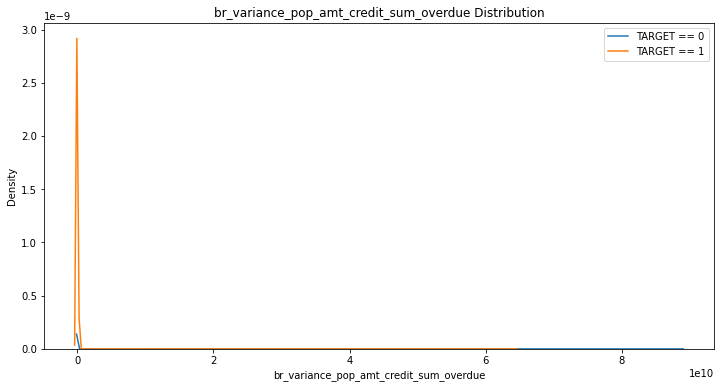

In [454]:
## 特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_overdue', app_train)

In [455]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_credit_sum_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_credit_sum_overdue'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_credit_sum_overdue'] = pt.transform(app_test[num_cols])

In [456]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_credit_sum_overdue']].corr()

TARGET  \
TARGET                                  1.000000   
br_variance_pop_amt_credit_sum_overdue  0.032851   

                                        br_variance_pop_amt_credit_sum_overdue  
TARGET                                                                0.032851  
br_variance_pop_amt_credit_sum_overdue                                1.000000

The correlation between br_variance_pop_amt_credit_sum_overdue and the TARGET is 0.0329
Median value for loan that was not repaid = -0.1073
Median value for loan that was repaid =     -0.1073


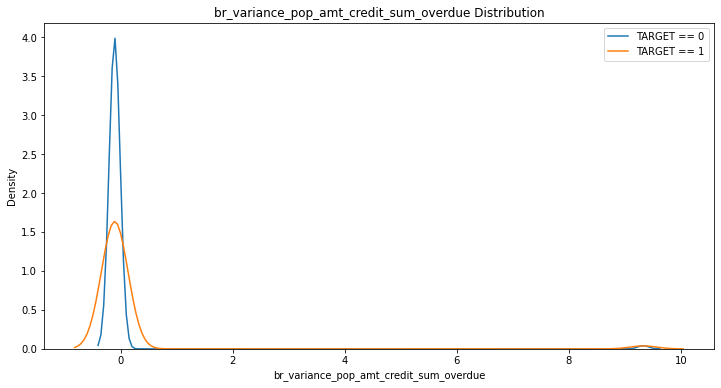

In [457]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_credit_sum_overdue', app_train)

### br_min_days_credit_update

In [458]:
## 目的変数との相関
app_train[['TARGET', 'br_min_days_credit_update']].corr()

TARGET  br_min_days_credit_update
TARGET                     1.000000                   0.048775
br_min_days_credit_update  0.048775                   1.000000

The correlation between br_min_days_credit_update and the TARGET is 0.0488
Median value for loan that was not repaid = -629.0000
Median value for loan that was repaid =     -800.0000


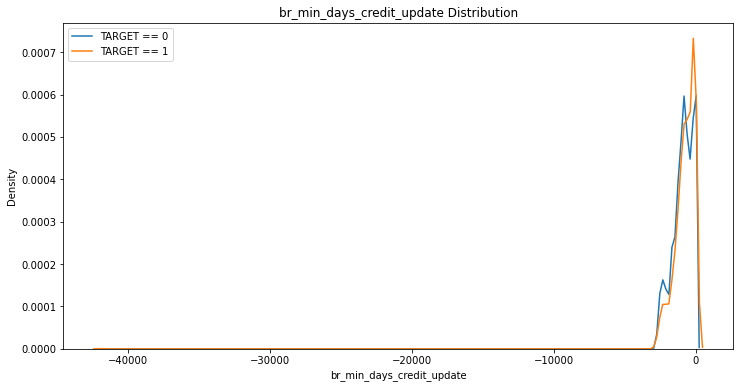

In [459]:
## 特徴量の分布
kde_target('br_min_days_credit_update', app_train)

In [460]:
## Yao-Johnson変換
num_cols = ['br_min_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_min_days_credit_update'] = pt.transform(app_test[num_cols])

In [461]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_days_credit_update']].corr()

TARGET  br_min_days_credit_update
TARGET                     1.000000                   0.059867
br_min_days_credit_update  0.059867                   1.000000

The correlation between br_min_days_credit_update and the TARGET is 0.0599
Median value for loan that was not repaid = 0.0711
Median value for loan that was repaid =     -0.1626


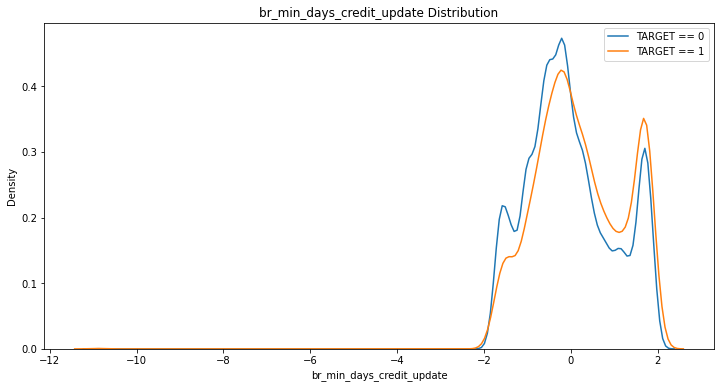

In [462]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_days_credit_update', app_train)

### br_max_days_credit_update

In [463]:
## 目的変数との相関
app_train[['TARGET', 'br_max_days_credit_update']].corr()

TARGET  br_max_days_credit_update
TARGET                     1.000000                   0.029381
br_max_days_credit_update  0.029381                   1.000000

The correlation between br_max_days_credit_update and the TARGET is 0.0294
Median value for loan that was not repaid = -13.0000
Median value for loan that was repaid =     -17.0000


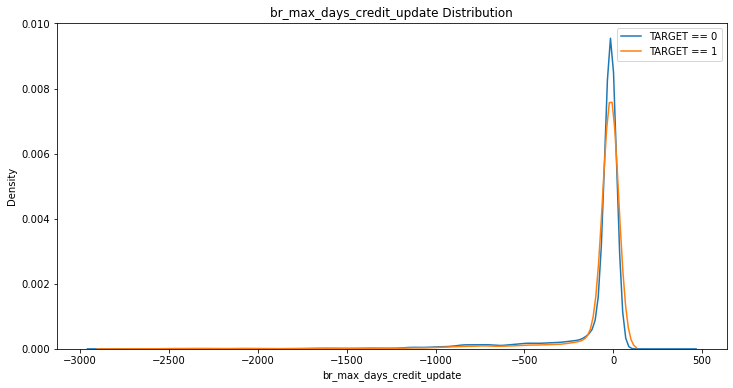

In [464]:
## 特徴量の分布
kde_target('br_max_days_credit_update', app_train)

In [465]:
## Yao-Johnson変換
num_cols = ['br_max_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_max_days_credit_update'] = pt.transform(app_test[num_cols])

In [466]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_days_credit_update']].corr()

TARGET  br_max_days_credit_update
TARGET                     1.000000                   0.032826
br_max_days_credit_update  0.032826                   1.000000

The correlation between br_max_days_credit_update and the TARGET is 0.0328
Median value for loan that was not repaid = 0.3761
Median value for loan that was repaid =     0.3295


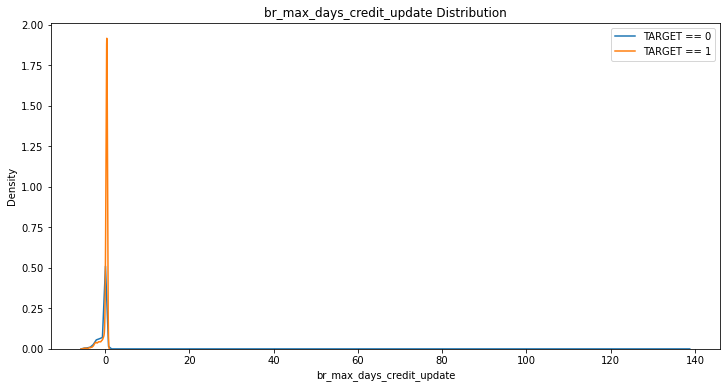

In [467]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_days_credit_update', app_train)

### br_sum_days_credit_update

In [468]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_days_credit_update']].corr()

TARGET  br_sum_days_credit_update
TARGET                     1.000000                   0.046297
br_sum_days_credit_update  0.046297                   1.000000

The correlation between br_sum_days_credit_update and the TARGET is 0.0463
Median value for loan that was not repaid = -17227.5000
Median value for loan that was repaid =     -26124.0000


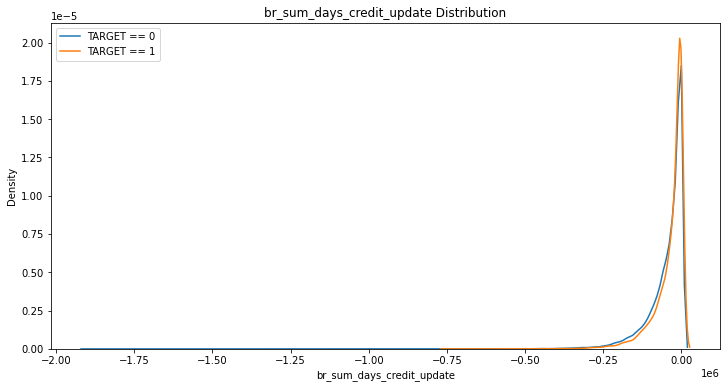

In [469]:
## 特徴量の分布
kde_target('br_sum_days_credit_update', app_train)

In [470]:
## Yao-Johnson変換
num_cols = ['br_sum_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_sum_days_credit_update'] = pt.transform(app_test[num_cols])

In [471]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_days_credit_update']].corr()

TARGET  br_sum_days_credit_update
TARGET                     1.000000                   0.060564
br_sum_days_credit_update  0.060564                   1.000000

The correlation between br_sum_days_credit_update and the TARGET is 0.0606
Median value for loan that was not repaid = 0.1271
Median value for loan that was repaid =     -0.1173


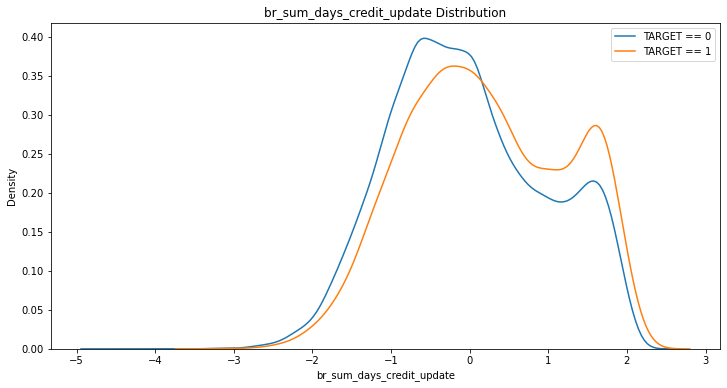

In [472]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_days_credit_update', app_train)

### br_avg_days_credit_update

In [473]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_days_credit_update']].corr()

TARGET  br_avg_days_credit_update
TARGET                     1.000000                   0.061194
br_avg_days_credit_update  0.061194                   1.000000

The correlation between br_avg_days_credit_update and the TARGET is 0.0612
Median value for loan that was not repaid = -281.9670
Median value for loan that was repaid =     -394.4927


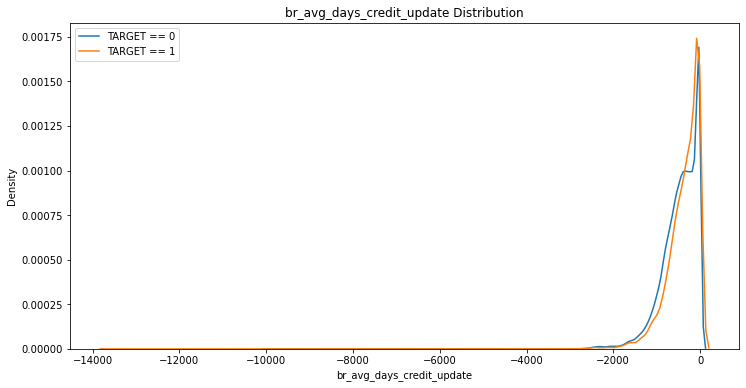

In [474]:
## 特徴量の分布
kde_target('br_avg_days_credit_update', app_train)

In [475]:
## Yao-Johnson変換
num_cols = ['br_avg_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_avg_days_credit_update'] = pt.transform(app_test[num_cols])

In [476]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_days_credit_update']].corr()

TARGET  br_avg_days_credit_update
TARGET                     1.000000                   0.068814
br_avg_days_credit_update  0.068814                   1.000000

The correlation between br_avg_days_credit_update and the TARGET is 0.0688
Median value for loan that was not repaid = 0.1658
Median value for loan that was repaid =     -0.1455


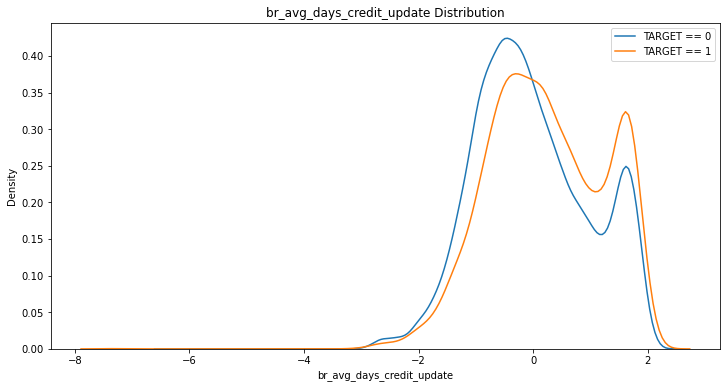

In [477]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_days_credit_update', app_train)

### br_cnt_days_credit_update

In [478]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_days_credit_update']].corr()

TARGET  br_cnt_days_credit_update
TARGET                     1.000000                  -0.024241
br_cnt_days_credit_update -0.024241                   1.000000

The correlation between br_cnt_days_credit_update and the TARGET is -0.0242
Median value for loan that was not repaid = 55.0000
Median value for loan that was repaid =     63.0000


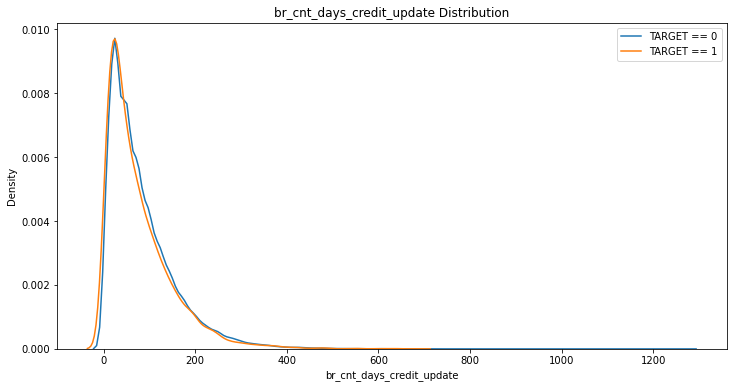

In [479]:
## 特徴量の分布
kde_target('br_cnt_days_credit_update', app_train)

In [480]:
## Yao-Johnson変換
num_cols = ['br_cnt_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_cnt_days_credit_update'] = pt.transform(app_test[num_cols])

In [481]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_days_credit_update']].corr()

TARGET  br_cnt_days_credit_update
TARGET                     1.000000                  -0.035764
br_cnt_days_credit_update -0.035764                   1.000000

The correlation between br_cnt_days_credit_update and the TARGET is -0.0358
Median value for loan that was not repaid = -0.1168
Median value for loan that was repaid =     0.0267


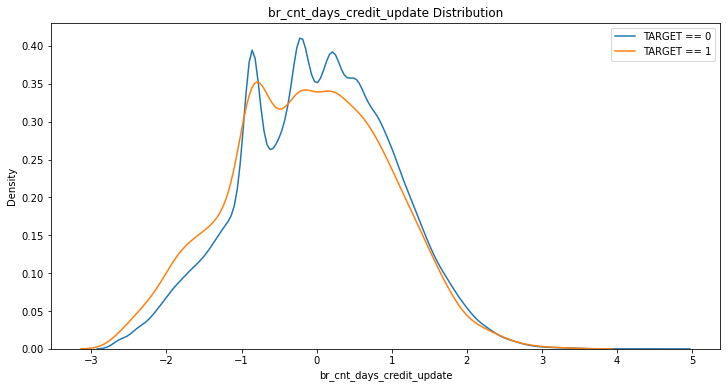

In [482]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_days_credit_update', app_train)

### br_stddev_days_credit_update

In [483]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_days_credit_update']].corr()

TARGET  br_stddev_days_credit_update
TARGET                        1.000000                     -0.038239
br_stddev_days_credit_update -0.038239                      1.000000

The correlation between br_stddev_days_credit_update and the TARGET is -0.0382
Median value for loan that was not repaid = 198.8473
Median value for loan that was repaid =     251.0194


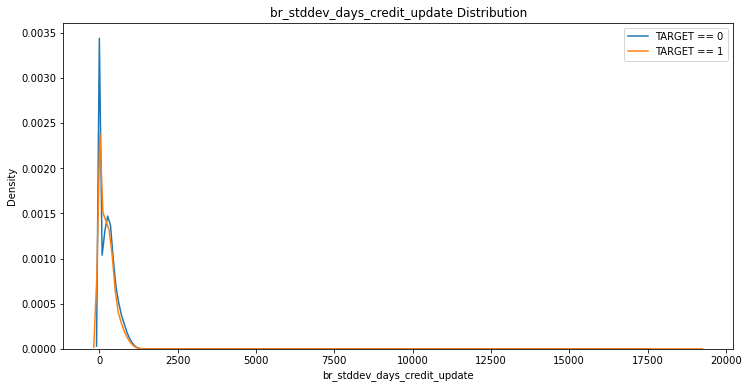

In [484]:
## 特徴量の分布
kde_target('br_stddev_days_credit_update', app_train)

In [485]:
## Yao-Johnson変換
num_cols = ['br_stddev_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_stddev_days_credit_update'] = pt.transform(app_test[num_cols])

In [486]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_days_credit_update']].corr()

TARGET  br_stddev_days_credit_update
TARGET                        1.000000                     -0.041282
br_stddev_days_credit_update -0.041282                      1.000000

The correlation between br_stddev_days_credit_update and the TARGET is -0.0413
Median value for loan that was not repaid = 0.0910
Median value for loan that was repaid =     0.2683


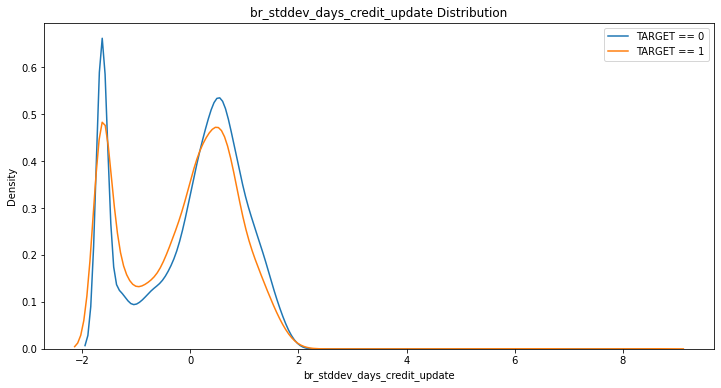

In [487]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_days_credit_update', app_train)

### br_stddev_pop_days_credit_update

In [488]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_days_credit_update']].corr()

TARGET  br_stddev_pop_days_credit_update
TARGET                            1.000000                         -0.038239
br_stddev_pop_days_credit_update -0.038239                          1.000000

The correlation between br_stddev_pop_days_credit_update and the TARGET is -0.0382
Median value for loan that was not repaid = 198.8473
Median value for loan that was repaid =     251.0194


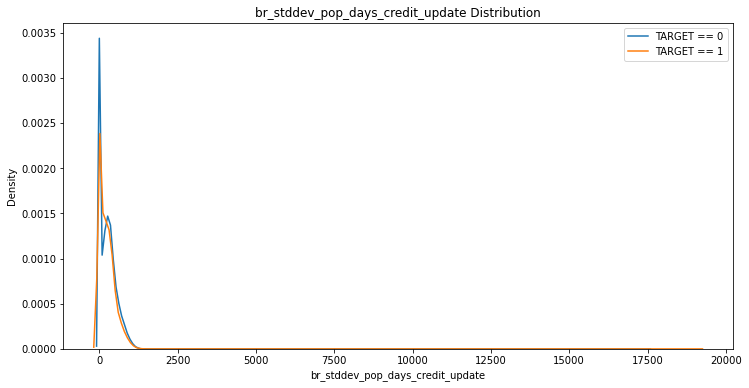

In [489]:
## 特徴量の分布
kde_target('br_stddev_pop_days_credit_update', app_train)

In [490]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_days_credit_update'] = pt.transform(app_test[num_cols])

In [491]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_days_credit_update']].corr()

TARGET  br_stddev_pop_days_credit_update
TARGET                            1.000000                         -0.041282
br_stddev_pop_days_credit_update -0.041282                          1.000000

The correlation between br_stddev_pop_days_credit_update and the TARGET is -0.0413
Median value for loan that was not repaid = 0.0910
Median value for loan that was repaid =     0.2683


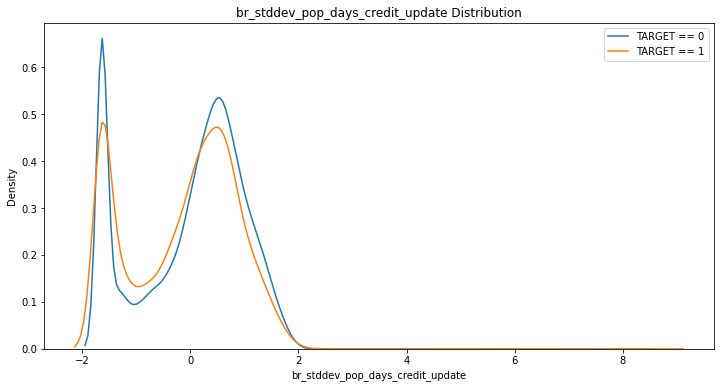

In [492]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_days_credit_update', app_train)

### br_var_pop_days_credit_update

In [493]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_days_credit_update']].corr()

TARGET  br_var_pop_days_credit_update
TARGET                         1.000000                       0.003555
br_var_pop_days_credit_update  0.003555                       1.000000

The correlation between br_var_pop_days_credit_update and the TARGET is 0.0036
Median value for loan that was not repaid = 39540.2523
Median value for loan that was repaid =     63010.7163


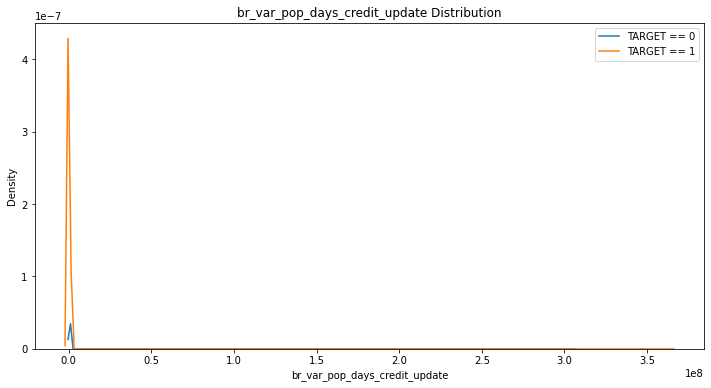

In [494]:
## 特徴量の分布
kde_target('br_var_pop_days_credit_update', app_train)

In [495]:
## Yao-Johnson変換
num_cols = ['br_var_pop_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_days_credit_update'] = pt.transform(app_test[num_cols])

In [496]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_days_credit_update']].corr()

TARGET  br_var_pop_days_credit_update
TARGET                         1.000000                      -0.041398
br_var_pop_days_credit_update -0.041398                       1.000000

The correlation between br_var_pop_days_credit_update and the TARGET is -0.0414
Median value for loan that was not repaid = 0.0931
Median value for loan that was repaid =     0.2702


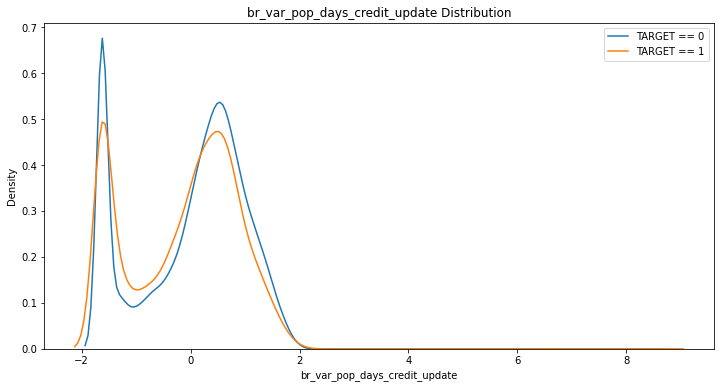

In [497]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_days_credit_update', app_train)

### br_var_samp_days_credit_update

In [498]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_days_credit_update']].corr()

TARGET  br_var_samp_days_credit_update
TARGET                          1.000000                        0.003714
br_var_samp_days_credit_update  0.003714                        1.000000

The correlation between br_var_samp_days_credit_update and the TARGET is 0.0037
Median value for loan that was not repaid = 40247.6835
Median value for loan that was repaid =     64219.9164


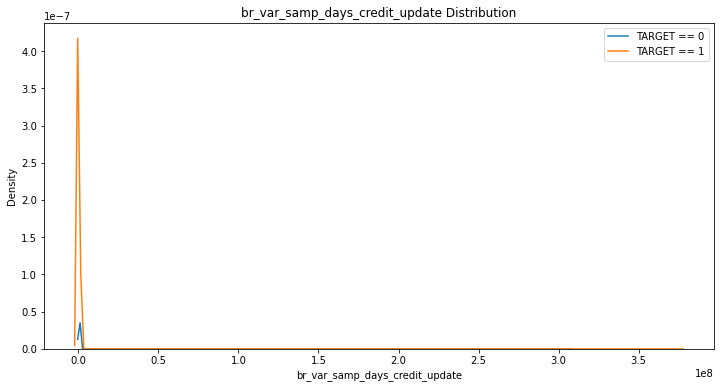

In [499]:
## 特徴量の分布
kde_target('br_var_samp_days_credit_update', app_train)

In [500]:
## Yao-Johnson変換
num_cols = ['br_var_samp_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_days_credit_update'] = pt.transform(app_test[num_cols])

In [501]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_days_credit_update']].corr()

TARGET  br_var_samp_days_credit_update
TARGET                          1.000000                       -0.041308
br_var_samp_days_credit_update -0.041308                        1.000000

The correlation between br_var_samp_days_credit_update and the TARGET is -0.0413
Median value for loan that was not repaid = 0.0931
Median value for loan that was repaid =     0.2711


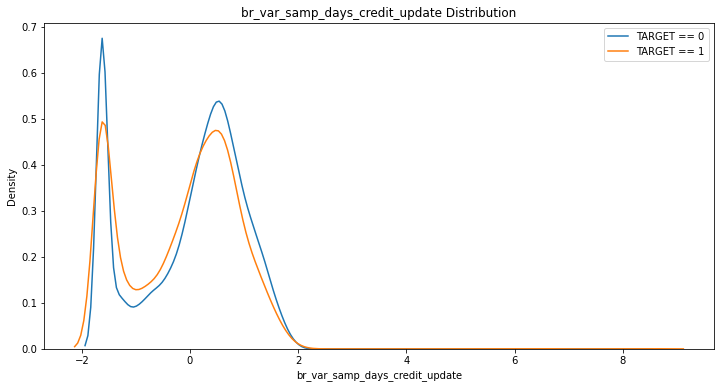

In [502]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_days_credit_update', app_train)

### br_variance_pop_days_credit_update

In [503]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_days_credit_update']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_days_credit_update  0.003555   

                                    br_variance_pop_days_credit_update  
TARGET                                                        0.003555  
br_variance_pop_days_credit_update                            1.000000

The correlation between br_variance_pop_days_credit_update and the TARGET is 0.0036
Median value for loan that was not repaid = 39540.2523
Median value for loan that was repaid =     63010.7163


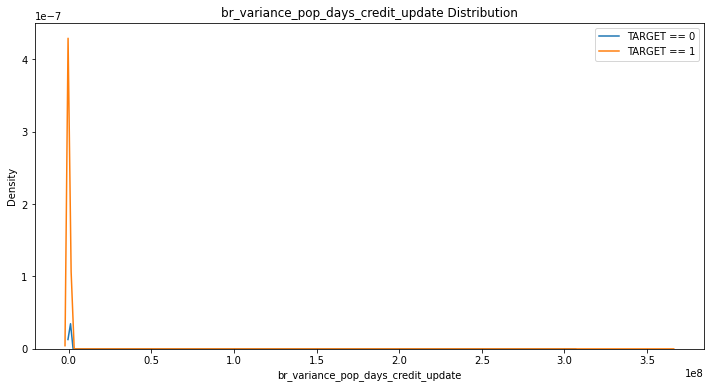

In [504]:
## 特徴量の分布
kde_target('br_variance_pop_days_credit_update', app_train)

In [505]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_days_credit_update']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_days_credit_update'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_days_credit_update'] = pt.transform(app_test[num_cols])

In [506]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_days_credit_update']].corr()

TARGET  \
TARGET                              1.000000   
br_variance_pop_days_credit_update -0.041398   

                                    br_variance_pop_days_credit_update  
TARGET                                                       -0.041398  
br_variance_pop_days_credit_update                            1.000000

The correlation between br_variance_pop_days_credit_update and the TARGET is -0.0414
Median value for loan that was not repaid = 0.0931
Median value for loan that was repaid =     0.2702


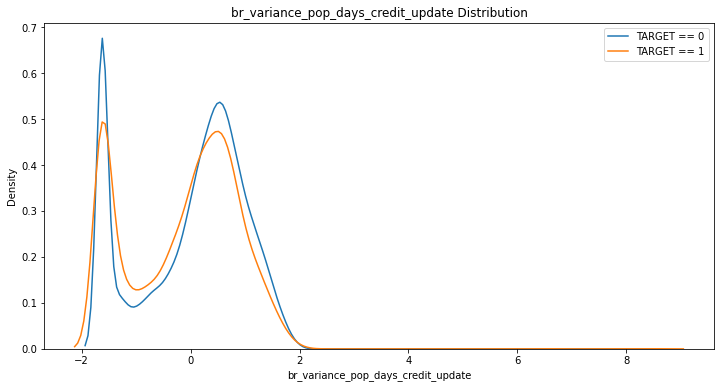

In [507]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_days_credit_update', app_train)

### br_min_amt_annuity

In [508]:
## 目的変数との相関
app_train[['TARGET', 'br_min_amt_annuity']].corr()

TARGET  br_min_amt_annuity
TARGET              1.000000           -0.001539
br_min_amt_annuity -0.001539            1.000000

The correlation between br_min_amt_annuity and the TARGET is -0.0015
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


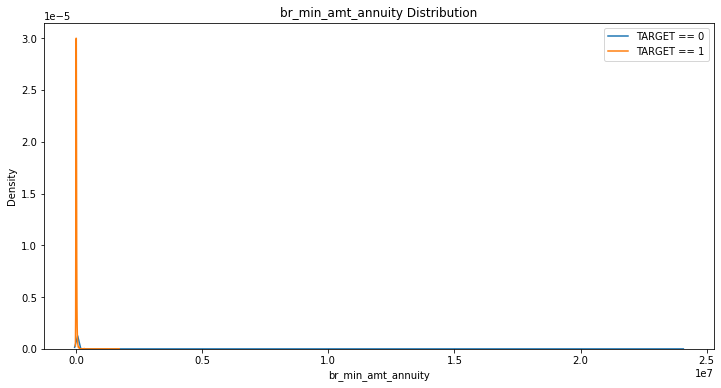

In [509]:
## 特徴量の分布
kde_target('br_min_amt_annuity', app_train)

In [510]:
## Yao-Johnson変換
num_cols = ['br_min_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_min_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_min_amt_annuity'] = pt.transform(app_test[num_cols])

In [511]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_min_amt_annuity']].corr()

TARGET  br_min_amt_annuity
TARGET              1.000000            0.034065
br_min_amt_annuity  0.034065            1.000000

The correlation between br_min_amt_annuity and the TARGET is 0.0341
Median value for loan that was not repaid = -0.8585
Median value for loan that was repaid =     -0.8585


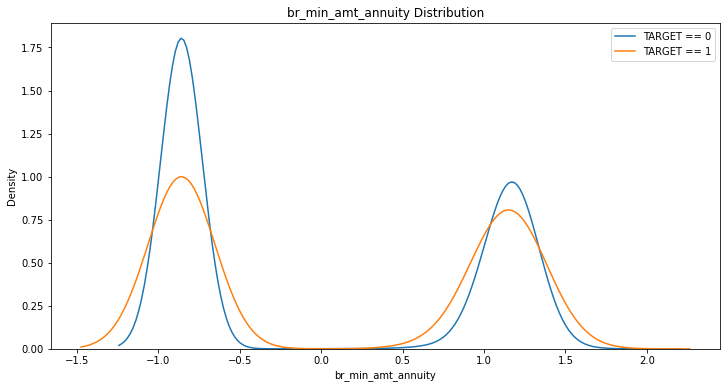

In [512]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_min_amt_annuity', app_train)

### br_max_amt_annuity

In [513]:
## 目的変数との相関
app_train[['TARGET', 'br_max_amt_annuity']].corr()

TARGET  br_max_amt_annuity
TARGET              1.000000            0.003079
br_max_amt_annuity  0.003079            1.000000

The correlation between br_max_amt_annuity and the TARGET is 0.0031
Median value for loan that was not repaid = 8235.0000
Median value for loan that was repaid =     7933.5000


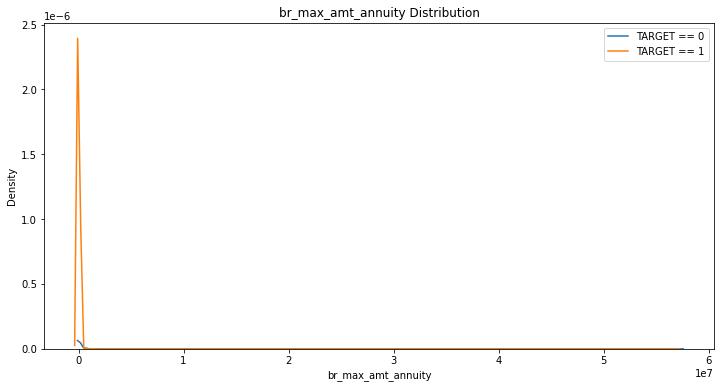

In [514]:
## 特徴量の分布
kde_target('br_max_amt_annuity', app_train)

In [515]:
## Yao-Johnson変換
num_cols = ['br_max_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_max_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_max_amt_annuity'] = pt.transform(app_test[num_cols])

In [516]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_max_amt_annuity']].corr()

TARGET  br_max_amt_annuity
TARGET              1.000000            0.026675
br_max_amt_annuity  0.026675            1.000000

The correlation between br_max_amt_annuity and the TARGET is 0.0267
Median value for loan that was not repaid = 0.3161
Median value for loan that was repaid =     0.3017


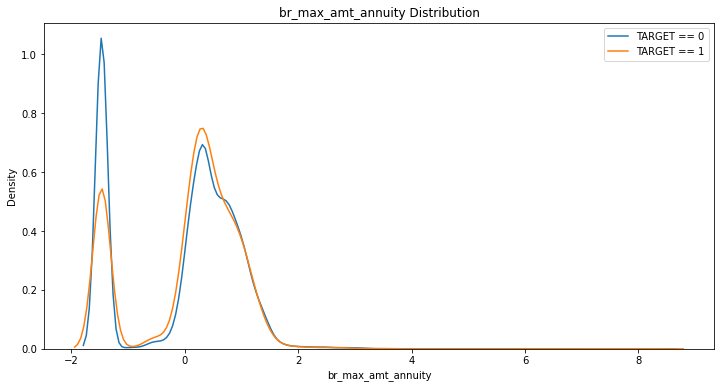

In [517]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_max_amt_annuity', app_train)

### br_sum_amt_annuity

In [518]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_annuity']].corr()

TARGET  br_sum_amt_annuity
TARGET              1.000000           -0.001238
br_sum_amt_annuity -0.001238            1.000000

The correlation between br_sum_amt_annuity and the TARGET is -0.0012
Median value for loan that was not repaid = 118626.7500
Median value for loan that was repaid =     95575.0050


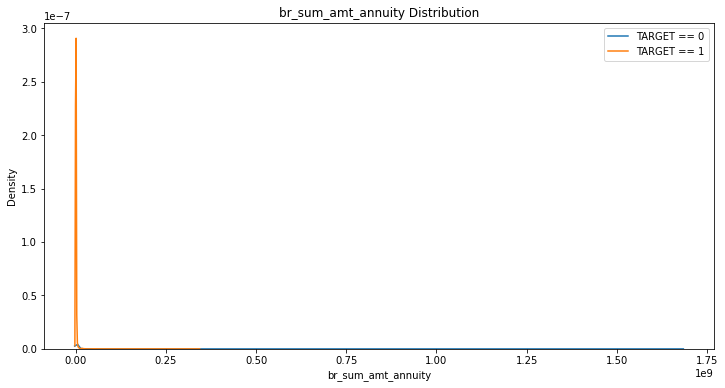

In [519]:
## 特徴量の分布
kde_target('br_sum_amt_annuity', app_train)

In [520]:
## Yao-Johnson変換
num_cols = ['br_sum_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_annuity'] = pt.transform(app_test[num_cols])

In [521]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_amt_annuity']].corr()

TARGET  br_sum_amt_annuity
TARGET              1.000000            0.031257
br_sum_amt_annuity  0.031257            1.000000

The correlation between br_sum_amt_annuity and the TARGET is 0.0313
Median value for loan that was not repaid = 0.5101
Median value for loan that was repaid =     0.4640


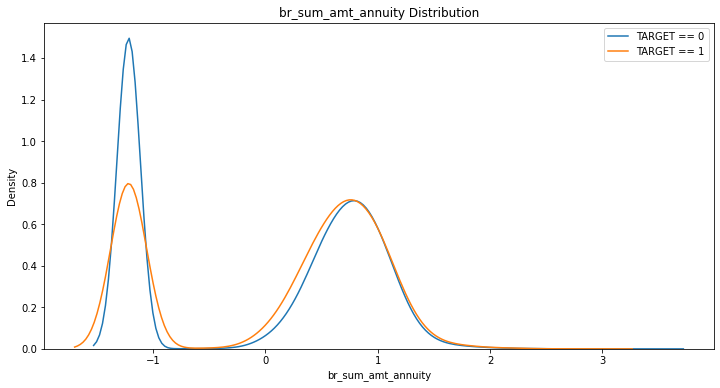

In [522]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_amt_annuity', app_train)

### br_avg_amt_annuity

In [523]:
## 目的変数との相関
app_train[['TARGET', 'br_avg_amt_annuity']].corr()

TARGET  br_avg_amt_annuity
TARGET              1.000000           -0.000707
br_avg_amt_annuity -0.000707            1.000000

The correlation between br_avg_amt_annuity and the TARGET is -0.0007
Median value for loan that was not repaid = 2790.3886
Median value for loan that was repaid =     1759.8182


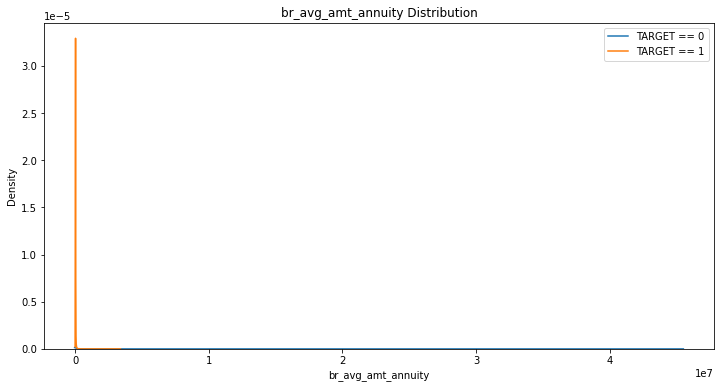

In [524]:
## 特徴量の分布
kde_target('br_avg_amt_annuity', app_train)

In [525]:
## Yao-Johnson変換
num_cols = ['br_avg_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_avg_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_avg_amt_annuity'] = pt.transform(app_test[num_cols])

In [526]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_avg_amt_annuity']].corr()

TARGET  br_avg_amt_annuity
TARGET              1.000000            0.036268
br_avg_amt_annuity  0.036268            1.000000

The correlation between br_avg_amt_annuity and the TARGET is 0.0363
Median value for loan that was not repaid = 0.5288
Median value for loan that was repaid =     0.3991


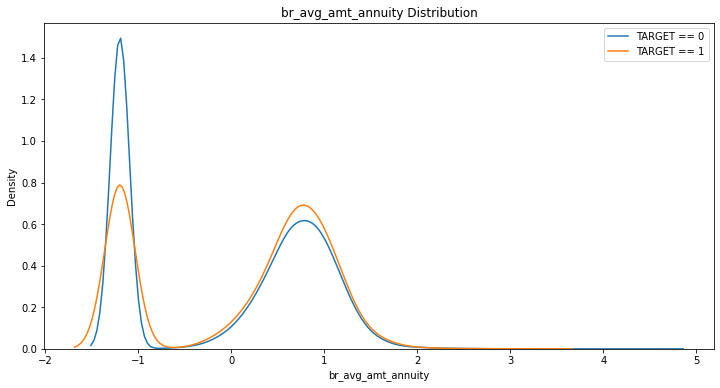

In [527]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_avg_amt_annuity', app_train)

### br_cnt_amt_annuity

In [528]:
## 目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_max_overdue']].corr()

TARGET  br_sum_amt_credit_max_overdue
TARGET                         1.000000                       0.043629
br_sum_amt_credit_max_overdue  0.043629                       1.000000

The correlation between br_sum_amt_credit_max_overdue and the TARGET is 0.0436
Median value for loan that was not repaid = -0.5068
Median value for loan that was repaid =     -0.5068


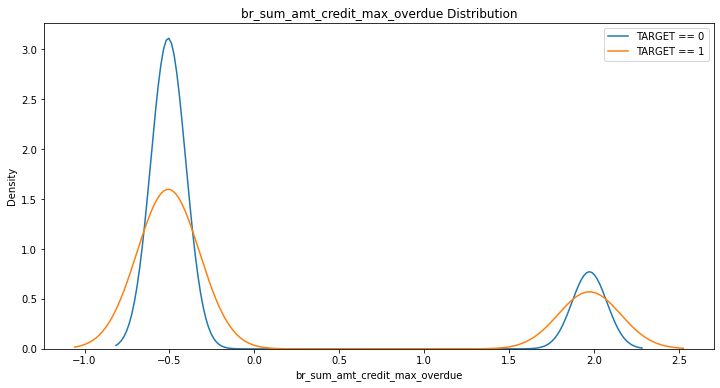

In [529]:
## 特徴量の分布
kde_target('br_sum_amt_credit_max_overdue', app_train)

In [530]:
## Yao-Johnson変換
num_cols = ['br_sum_amt_credit_max_overdue']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_sum_amt_credit_max_overdue_yj'] = pt.transform(app_train[num_cols])
app_test['br_sum_amt_credit_max_overdue_yj'] = pt.transform(app_test[num_cols])

In [531]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_sum_amt_credit_max_overdue_yj']].corr()

TARGET  br_sum_amt_credit_max_overdue_yj
TARGET                            1.00000                           0.04361
br_sum_amt_credit_max_overdue_yj  0.04361                           1.00000

The correlation between br_sum_amt_credit_max_overdue_yj and the TARGET is 0.0436
Median value for loan that was not repaid = -0.5068
Median value for loan that was repaid =     -0.5068


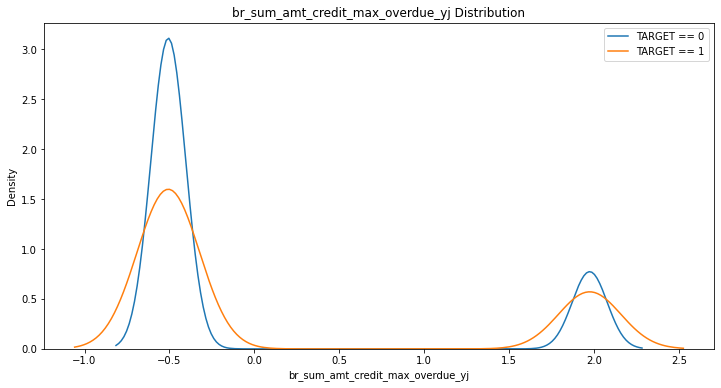

In [532]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_sum_amt_credit_max_overdue_yj', app_train)

### br_cnt_amt_annuity

In [533]:
## 目的変数との相関
app_train[['TARGET', 'br_cnt_amt_annuity']].corr()

TARGET  br_cnt_amt_annuity
TARGET              1.000000           -0.024241
br_cnt_amt_annuity -0.024241            1.000000

The correlation between br_cnt_amt_annuity and the TARGET is -0.0242
Median value for loan that was not repaid = 55.0000
Median value for loan that was repaid =     63.0000


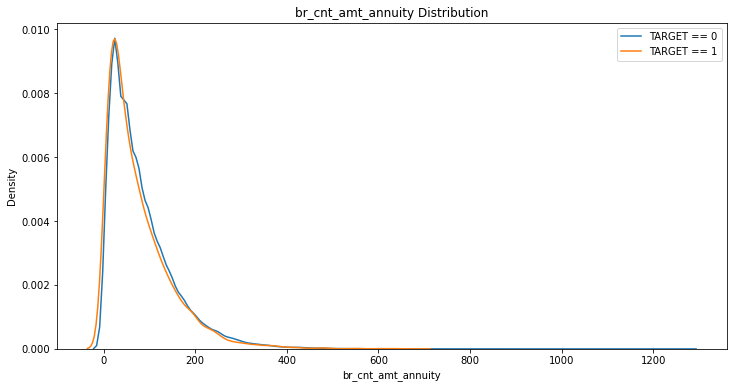

In [534]:
## 特徴量の分布
kde_target('br_cnt_amt_annuity', app_train)

In [535]:
## Yao-Johnson変換
num_cols = ['br_cnt_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_cnt_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_cnt_amt_annuity'] = pt.transform(app_test[num_cols])

In [536]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_cnt_amt_annuity']].corr()

TARGET  br_cnt_amt_annuity
TARGET              1.000000           -0.035764
br_cnt_amt_annuity -0.035764            1.000000

The correlation between br_cnt_amt_annuity and the TARGET is -0.0358
Median value for loan that was not repaid = -0.1168
Median value for loan that was repaid =     0.0267


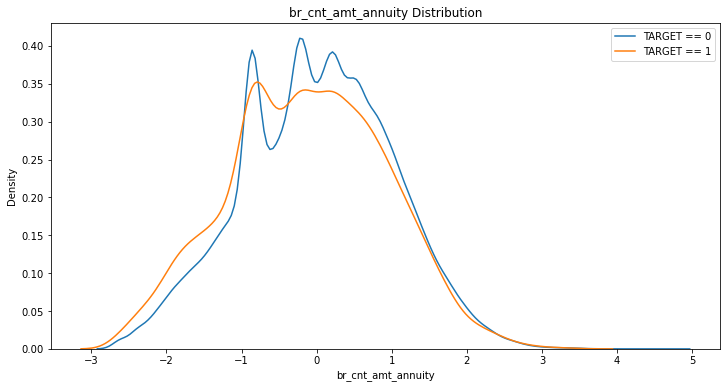

In [537]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_cnt_amt_annuity', app_train)

### br_stddev_amt_annuity

In [538]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_amt_annuity']].corr()

TARGET  br_stddev_amt_annuity
TARGET                 1.000000               0.001385
br_stddev_amt_annuity  0.001385               1.000000

The correlation between br_stddev_amt_annuity and the TARGET is 0.0014
Median value for loan that was not repaid = 1471.8765
Median value for loan that was repaid =     0.0000


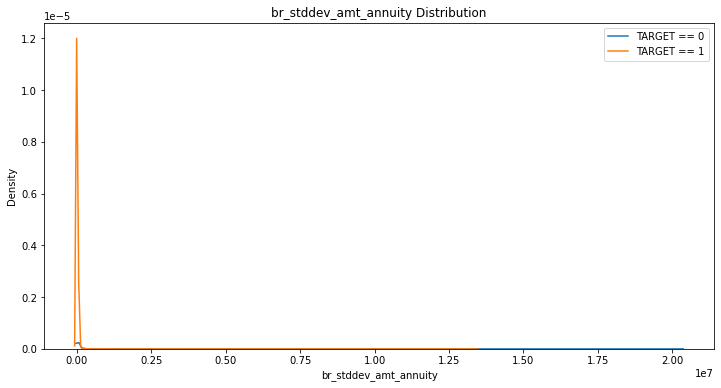

In [539]:
## 特徴量の分布
kde_target('br_stddev_amt_annuity', app_train)

In [540]:
## Yao-Johnson変換
num_cols = ['br_stddev_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_stddev_amt_annuity'] = pt.transform(app_test[num_cols])

In [541]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_amt_annuity']].corr()

TARGET  br_stddev_amt_annuity
TARGET                 1.000000               0.027182
br_stddev_amt_annuity  0.027182               1.000000

The correlation between br_stddev_amt_annuity and the TARGET is 0.0272
Median value for loan that was not repaid = 0.6873
Median value for loan that was repaid =     -0.9877


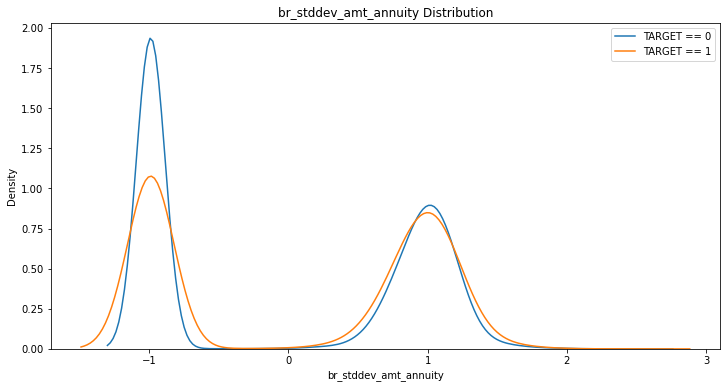

In [542]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_amt_annuity', app_train)

### br_stddev_pop_amt_annuity

In [543]:
## 目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_annuity']].corr()

TARGET  br_stddev_pop_amt_annuity
TARGET                     1.000000                   0.001385
br_stddev_pop_amt_annuity  0.001385                   1.000000

The correlation between br_stddev_pop_amt_annuity and the TARGET is 0.0014
Median value for loan that was not repaid = 1471.8765
Median value for loan that was repaid =     0.0000


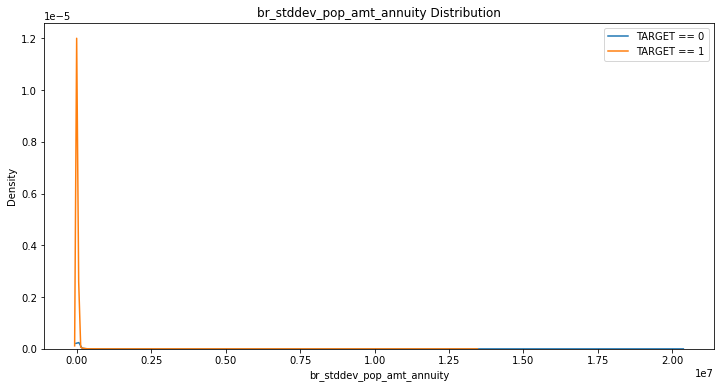

In [544]:
## 特徴量の分布
kde_target('br_stddev_pop_amt_annuity', app_train)

In [545]:
## Yao-Johnson変換
num_cols = ['br_stddev_pop_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_stddev_pop_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_stddev_pop_amt_annuity'] = pt.transform(app_test[num_cols])

In [546]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_stddev_pop_amt_annuity']].corr()

TARGET  br_stddev_pop_amt_annuity
TARGET                     1.000000                   0.027182
br_stddev_pop_amt_annuity  0.027182                   1.000000

The correlation between br_stddev_pop_amt_annuity and the TARGET is 0.0272
Median value for loan that was not repaid = 0.6873
Median value for loan that was repaid =     -0.9877


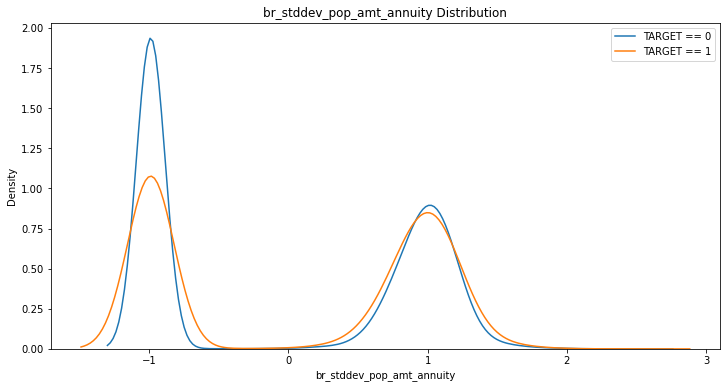

In [547]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_stddev_pop_amt_annuity', app_train)

### br_var_pop_amt_annuity

In [548]:
## 目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_annuity']].corr()

TARGET  br_var_pop_amt_annuity
TARGET                  1.000000                0.001251
br_var_pop_amt_annuity  0.001251                1.000000

The correlation between br_var_pop_amt_annuity and the TARGET is 0.0013
Median value for loan that was not repaid = 2166436.2657
Median value for loan that was repaid =     0.0000


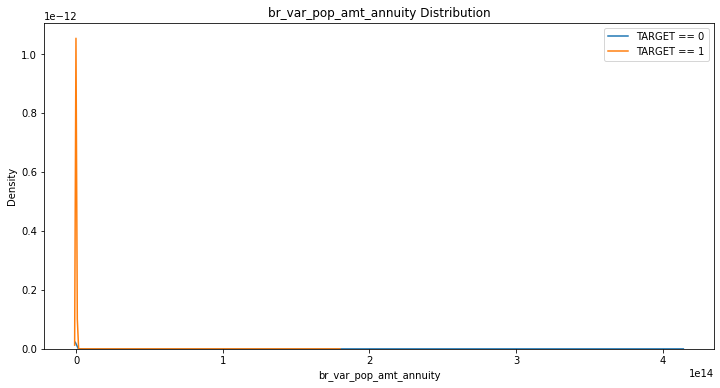

In [549]:
## 特徴量の分布
kde_target('br_var_pop_amt_annuity', app_train)

In [550]:
## Yao-Johnson変換
num_cols = ['br_var_pop_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_pop_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_var_pop_amt_annuity'] = pt.transform(app_test[num_cols])

In [551]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_pop_amt_annuity']].corr()

TARGET  br_var_pop_amt_annuity
TARGET                  1.000000                0.027169
br_var_pop_amt_annuity  0.027169                1.000000

The correlation between br_var_pop_amt_annuity and the TARGET is 0.0272
Median value for loan that was not repaid = 0.6873
Median value for loan that was repaid =     -0.9876


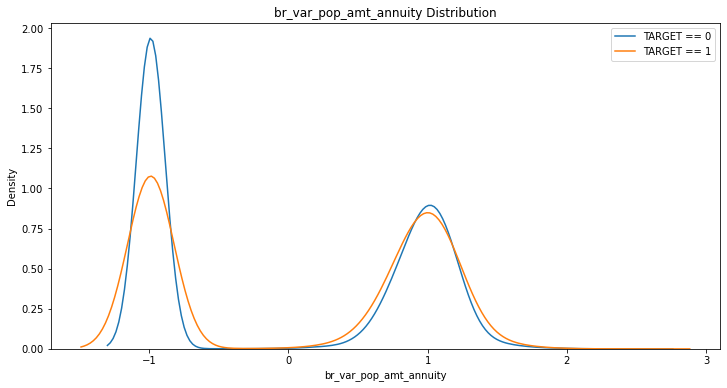

In [552]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_pop_amt_annuity', app_train)

### br_var_samp_amt_annuity

In [553]:
## 目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_annuity']].corr()

TARGET  br_var_samp_amt_annuity
TARGET                   1.000000                 0.001219
br_var_samp_amt_annuity  0.001219                 1.000000

The correlation between br_var_samp_amt_annuity and the TARGET is 0.0012
Median value for loan that was not repaid = 2210109.2466
Median value for loan that was repaid =     0.0000


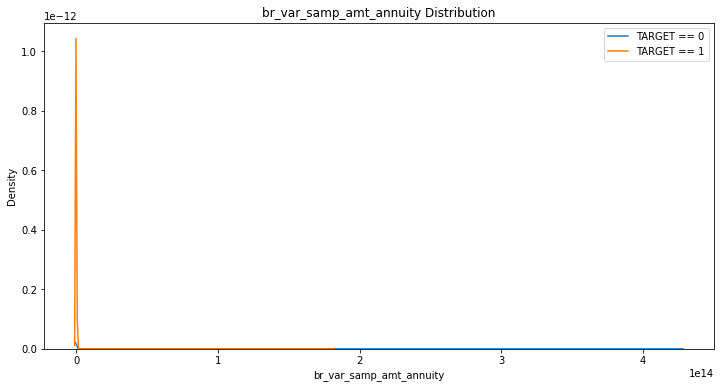

In [554]:
## 特徴量の分布
kde_target('br_var_samp_amt_annuity', app_train)

In [555]:
## Yao-Johnson変換
num_cols = ['br_var_samp_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_var_samp_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_var_samp_amt_annuity'] = pt.transform(app_test[num_cols])

In [556]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_var_samp_amt_annuity']].corr()

TARGET  br_var_samp_amt_annuity
TARGET                   1.000000                 0.027231
br_var_samp_amt_annuity  0.027231                 1.000000

The correlation between br_var_samp_amt_annuity and the TARGET is 0.0272
Median value for loan that was not repaid = 0.6877
Median value for loan that was repaid =     -0.9876


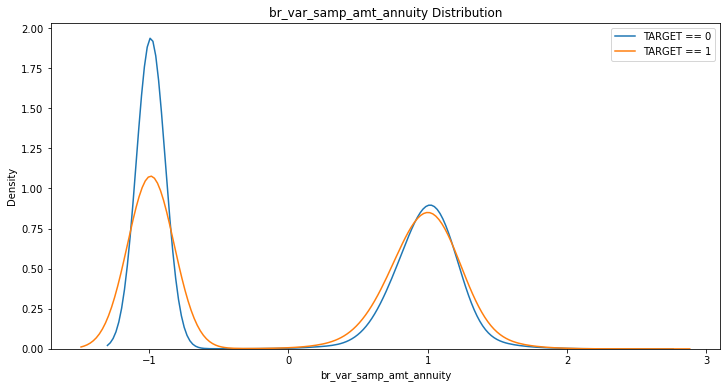

In [557]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_var_samp_amt_annuity', app_train)

### br_variance_pop_amt_annuity

In [558]:
## 目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_annuity']].corr()

TARGET  br_variance_pop_amt_annuity
TARGET                       1.000000                     0.001251
br_variance_pop_amt_annuity  0.001251                     1.000000

The correlation between br_variance_pop_amt_annuity and the TARGET is 0.0013
Median value for loan that was not repaid = 2166436.2657
Median value for loan that was repaid =     0.0000


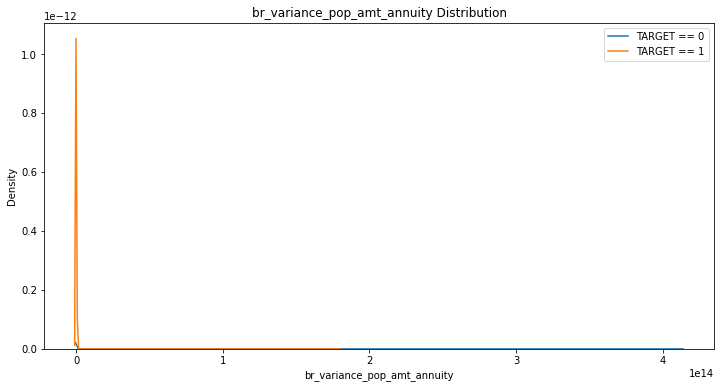

In [559]:
## 特徴量の分布
kde_target('br_variance_pop_amt_annuity', app_train)

In [560]:
## Yao-Johnson変換
num_cols = ['br_variance_pop_amt_annuity']
### 学習データに基づいてYao-Johnson変換を定義
pt = PowerTransformer(method = 'yeo-johnson')
pt.fit(app_train[num_cols].copy())

### 変換後のデータで各列を置換
app_train['br_variance_pop_amt_annuity'] = pt.transform(app_train[num_cols])
app_test['br_variance_pop_amt_annuity'] = pt.transform(app_test[num_cols])

In [561]:
## Yao-Johnson変換後の目的変数との相関
app_train[['TARGET', 'br_variance_pop_amt_annuity']].corr()

TARGET  br_variance_pop_amt_annuity
TARGET                       1.000000                     0.027169
br_variance_pop_amt_annuity  0.027169                     1.000000

The correlation between br_variance_pop_amt_annuity and the TARGET is 0.0272
Median value for loan that was not repaid = 0.6873
Median value for loan that was repaid =     -0.9876


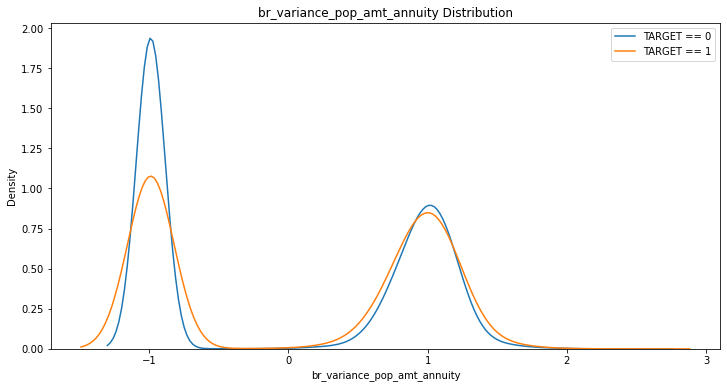

In [562]:
## Yao-Johnson変換後の特徴量の分布
kde_target('br_variance_pop_amt_annuity', app_train)

In [563]:
## CSVをEXPORT

In [564]:
### train
app_train.to_csv(
    path_or_buf="./home-credit-default-risk/exports/hc_br_train.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [565]:
### test
app_test.to_csv(
    path_or_buf="./home-credit-default-risk/exports/hc_br_test.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [566]:
columns = list(app_train.columns)
columns.remove('SK_ID_CURR')
columns.remove('TARGET')

In [567]:
data = pd.concat([app_train, app_test], sort=False)
train = data[:len(app_train)]
test = data[len(app_test):]


y_train = train['TARGET']
X_train = app_train.copy().drop('TARGET', axis=1)
X_test = app_test.copy()

In [568]:
import xgboost as xgb
from sklearn.metrics import log_loss

y_preds = []
models = []
scores = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = columns

params = {
    'booster': 'gbtree'
    ,'objective': 'binary:logistic'
    ,'silent': 1
    ,'random_state': 17
    ,'gpu_id': 0
    ,'tree_method': 'gpu_hist'
    ,'eval_metric': 'auc'
    ,'eta': 0.1
    #,'max_round': 100
    ,'max_depth': 8
    ,'subsample': 0.8
    ,'colsample_state': 71
    ,'colsample_bytree': 1.0
    ,'colsample_bylevel': 0.3
    ,'subsumple': 0.9
    ,'gamma': 0
    ,'lambda': 1
    ,'alpha': 0
    ,'min_child_weight': 1
}

num_round = 50

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist)
    
    va_pred = model.predict(dvalid)
    score = log_loss(y_val, va_pred)
    oof_train[valid_index] = va_pred
    
    y_pred = model.predict(dtest) 
    
    
    #oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    #y_pred = model.predict(X_test, num_iteration=model.best_iteration)##

    y_preds.append(y_pred)
    models.append(model)
    scores.append(score)

[19:30:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_state", "silent", "subsumple" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.54956	eval-auc:0.53550
[1]	train-auc:0.56359	eval-auc:0.54242
[2]	train-auc:0.57037	eval-auc:0.53995
[3]	train-auc:0.57453	eval-auc:0.54100
[4]	train-auc:0.57854	eval-auc:0.54280
[5]	train-auc:0.58108	eval-auc:0.54373
[6]	train-auc:0.58389	eval-auc:0.54592
[7]	train-auc:0.58640	eval-auc:0.54705
[8]	train-auc:0.58803	eval-auc:0.54626
[9]	train-auc:0.58947	eval-auc:0.54439
[10]	train-auc:0.59112	eval-auc:0.54434
[11]	train-auc:0.59284	eval-auc:0.54556
[12]	train-auc:0.59393	eval-auc:0.54360
[13]	train-auc:0.59461	eval-auc:0.54546
[14

[12]	train-auc:0.59309	eval-auc:0.55308
[13]	train-auc:0.59405	eval-auc:0.55344
[14]	train-auc:0.59578	eval-auc:0.55221
[15]	train-auc:0.59795	eval-auc:0.55250
[16]	train-auc:0.59884	eval-auc:0.55190
[17]	train-auc:0.60028	eval-auc:0.55228
[18]	train-auc:0.60316	eval-auc:0.55331
[19]	train-auc:0.60467	eval-auc:0.55329
[20]	train-auc:0.60639	eval-auc:0.55356
[21]	train-auc:0.60673	eval-auc:0.55208
[22]	train-auc:0.60730	eval-auc:0.55312
[23]	train-auc:0.60834	eval-auc:0.55288
[24]	train-auc:0.60992	eval-auc:0.55305
[25]	train-auc:0.61024	eval-auc:0.55261
[26]	train-auc:0.61037	eval-auc:0.55164
[27]	train-auc:0.61288	eval-auc:0.55139
[28]	train-auc:0.61441	eval-auc:0.55243
[29]	train-auc:0.61596	eval-auc:0.55345
[30]	train-auc:0.61637	eval-auc:0.55254
[31]	train-auc:0.61794	eval-auc:0.55259
[32]	train-auc:0.61961	eval-auc:0.55365
[33]	train-auc:0.62121	eval-auc:0.55468
[34]	train-auc:0.62184	eval-auc:0.55466
[35]	train-auc:0.62242	eval-auc:0.55418
[36]	train-auc:0.62603	eval-auc:0.55324


In [569]:
app_train = app_train.drop('TARGET', axis=1)

In [570]:
# trainへマージ
app_train = pd.merge(app_train_origin.copy(), app_br_train, on='SK_ID_CURR', how='left')
# testへマージ
app_test = pd.merge(app_test_origin.copy(), app_br_test, on='SK_ID_CURR', how='left')
len(app_test)

48744

In [571]:
columns = list(app_train.columns)
columns.remove('SK_ID_CURR')
columns.remove('TARGET')

In [572]:
data = pd.concat([app_train, app_test], sort=False)
train = data[:len(app_train)]
test = data[len(app_test):]

y_train = train['TARGET']
X_train = app_train.copy().drop('TARGET', axis=1)
X_test = app_test.copy()

In [573]:
import xgboost as xgb
from sklearn.metrics import log_loss

y_preds = []
models = []
scores = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = columns

params = {
    'booster': 'gbtree'
    ,'objective': 'binary:logistic'
    ,'silent': 1
    ,'random_state': 17
    ,'gpu_id': 0
    ,'tree_method': 'gpu_hist'
    ,'eval_metric': 'auc'
    ,'eta': 0.1
    #,'max_round': 100
    ,'max_depth': 8
    ,'subsample': 0.8
    ,'colsample_state': 71
    ,'colsample_bytree': 1.0
    ,'colsample_bylevel': 0.3
    ,'subsumple': 0.9
    ,'gamma': 0
    ,'lambda': 1
    ,'alpha': 0
    ,'min_child_weight': 1
}

num_round = 50

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist)
    
    va_pred = model.predict(dvalid)
    score = log_loss(y_val, va_pred)
    oof_train[valid_index] = va_pred
    
    y_pred = model.predict(dtest) 
    
    
    #oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    #y_pred = model.predict(X_test, num_iteration=model.best_iteration)##

    y_preds.append(y_pred)
    models.append(model)
    scores.append(score)

[19:31:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_state", "silent", "subsumple" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.72632	eval-auc:0.71374
[1]	train-auc:0.74203	eval-auc:0.72657
[2]	train-auc:0.75062	eval-auc:0.73215
[3]	train-auc:0.75475	eval-auc:0.73412
[4]	train-auc:0.75889	eval-auc:0.73567
[5]	train-auc:0.76510	eval-auc:0.73937
[6]	train-auc:0.76693	eval-auc:0.73948
[7]	train-auc:0.76772	eval-auc:0.74035
[8]	train-auc:0.76856	eval-auc:0.74093
[9]	train-auc:0.77085	eval-auc:0.74160
[10]	train-auc:0.77372	eval-auc:0.74292
[11]	train-auc:0.77428	eval-auc:0.74300
[12]	train-auc:0.77687	eval-auc:0.74418
[13]	train-auc:0.77774	eval-auc:0.74400
[14

[12]	train-auc:0.77732	eval-auc:0.74079
[13]	train-auc:0.77914	eval-auc:0.74141
[14]	train-auc:0.78070	eval-auc:0.74193
[15]	train-auc:0.78127	eval-auc:0.74162
[16]	train-auc:0.78274	eval-auc:0.74207
[17]	train-auc:0.78395	eval-auc:0.74300
[18]	train-auc:0.78556	eval-auc:0.74338
[19]	train-auc:0.78781	eval-auc:0.74416
[20]	train-auc:0.78902	eval-auc:0.74463
[21]	train-auc:0.79044	eval-auc:0.74471
[22]	train-auc:0.79202	eval-auc:0.74576
[23]	train-auc:0.79319	eval-auc:0.74628
[24]	train-auc:0.79426	eval-auc:0.74721
[25]	train-auc:0.79522	eval-auc:0.74827
[26]	train-auc:0.79675	eval-auc:0.74816
[27]	train-auc:0.79803	eval-auc:0.74879
[28]	train-auc:0.79972	eval-auc:0.74925
[29]	train-auc:0.80109	eval-auc:0.74979
[30]	train-auc:0.80217	eval-auc:0.74979
[31]	train-auc:0.80408	eval-auc:0.75037
[32]	train-auc:0.80554	eval-auc:0.75075
[33]	train-auc:0.80659	eval-auc:0.75107
[34]	train-auc:0.80805	eval-auc:0.75134
[35]	train-auc:0.80921	eval-auc:0.75154
[36]	train-auc:0.80982	eval-auc:0.75158


In [574]:
# CSV-00
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[0]
submit_all.isnull().sum()

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_00.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [575]:
# CSV-01
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[1]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_01.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [576]:
# CSV-02
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[2]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_02.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [577]:
# CSV-03
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[3]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_03.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [578]:
# CSV-04
submit_all = app_test[["SK_ID_CURR"]].copy()
# 予測確率の変数名はTARGET
submit_all["TARGET"] = y_preds[4]

# Submit File
submit_all.to_csv(
    path_or_buf="./home-credit-default-risk/submit/submit_all_04.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [579]:
submit_all_00 = pd.read_csv('./home-credit-default-risk/submit/submit_all_00.csv')
submit_all_01 = pd.read_csv('./home-credit-default-risk/submit/submit_all_01.csv')
submit_all_02 = pd.read_csv('./home-credit-default-risk/submit/submit_all_02.csv')
submit_all_03 = pd.read_csv('./home-credit-default-risk/submit/submit_all_03.csv')
submit_all_04 = pd.read_csv('./home-credit-default-risk/submit/submit_all_04.csv')

In [580]:
submit_all = pd.DataFrame({
    'submit_all_00': submit_all_00['TARGET'].values
    ,'submit_all_01': submit_all_01['TARGET'].values
    ,'submit_all_02': submit_all_02['TARGET'].values
    ,'submit_all_03': submit_all_03['TARGET'].values
    ,'submit_all_04': submit_all_04['TARGET'].values
    })
submit_all.head()

submit_all_00  submit_all_01  submit_all_02  submit_all_03  submit_all_04
0       0.042196       0.051412       0.050625       0.044280       0.061972
1       0.108745       0.130456       0.091951       0.086898       0.155873
2       0.025288       0.026080       0.022243       0.027126       0.032331
3       0.035292       0.042122       0.033985       0.070439       0.022582
4       0.139536       0.123782       0.117850       0.133705       0.151308

In [581]:
submit_all = app_test[["SK_ID_CURR"]].copy()
submit_all['TARGET'] = (submit_all_00['TARGET'] + submit_all_01['TARGET'] + submit_all_02['TARGET'] + submit_all_03['TARGET'] + submit_all_04['TARGET'])/5
submit_all.head()

SK_ID_CURR    TARGET
0      100001  0.050097
1      100005  0.114784
2      100013  0.026613
3      100028  0.040884
4      100038  0.133236

In [582]:
submit_all['TARGET'] = (submit_all['TARGET'] / 5)
submit_all.to_csv('./home-credit-default-risk/submit/submit_br_main_test.csv', index=False)
submit_all.head()

SK_ID_CURR    TARGET
0      100001  0.010019
1      100005  0.022957
2      100013  0.005323
3      100028  0.008177
4      100038  0.026647

In [583]:
submit_all.count()

SK_ID_CURR    48744
TARGET        48744
dtype: int64